In [65]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report

In [66]:
import os

DATA_DIR = 'data_processed/filtered/New'
print(os.listdir(DATA_DIR))

['disgust']


In [67]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [68]:
image_size = 64
batch_size = 4
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (0.5,), (0.5,)

In [69]:

# train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     transforms.Grayscale(num_output_channels=1),
#     T.ToTensor(),
#     T.Normalize(*stats)]))


# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

import os
import random
from PIL import Image



# # define the path to the folder containing the original images
# data_dir = "data_processed/filtered/New/disgust"

# # define the number of augmented images to generate
# num_augmented_images = 1000

# # define the data augmentation transforms
# augmentations = T.Compose([
#     T.RandomResizedCrop(224),
#     T.RandomHorizontalFlip(),
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     T.RandomRotation(degrees=15),
#     T.ToTensor(),
#     T.Normalize([0.5], [0.5])
# ])

# # loop over the original images in the folder and perform data augmentation on a random subset
# for filename in os.listdir(data_dir):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         img_path = os.path.join(data_dir, filename)
#         img = Image.open(img_path)
#         if random.random() < 0.5:
#             # apply data augmentation to the image
#             augmented_img = augmentations(img)
#             # convert tensor to PIL image
#             augmented_img_pil = T.ToPILImage()(augmented_img)
#             # save the augmented image to the same folder
#             new_filename = "augmented_" + filename
#             augmented_img_pil.save(os.path.join(data_dir, new_filename))
#             num_augmented_images -= 1
#             if num_augmented_images == 0:
#                 break



train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    transforms.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

# # create the data loader for the augmented training dataset
# train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=3, pin_memory=True)



In [70]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [72]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

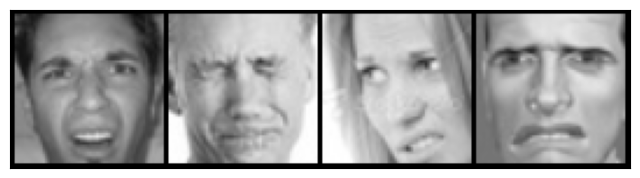

In [73]:
show_batch(train_dl)

In [74]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [75]:
device = get_default_device()
device

device(type='cuda')

In [76]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [77]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [78]:
discriminator = to_device(discriminator, device)

In [79]:
latent_size = 128

In [80]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([4, 1, 64, 64])


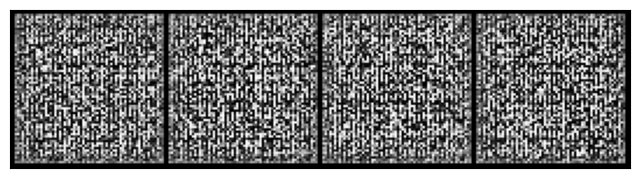

In [81]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [82]:
generator = to_device(generator, device)

In [83]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [84]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [85]:
from torchvision.utils import save_image

In [86]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [87]:
# def save_samples(index, latent_tensors, show=True):
#     fake_images = generator(latent_tensors)
#     fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
#     save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
#     print('Saving', fake_fname)
#     if show:
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))






def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    
    for i in range(fake_images.shape[0]):
        fake_fname = 'generated-image-{0:0=4d}-{1:0=2d}.png'.format(index, i)
        save_image(denorm(fake_images[i]), os.path.join(sample_dir, fake_fname))
        print('Saving', fake_fname)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(fake_images[i].cpu().detach().permute(1, 2, 0))
            plt.show()


In [88]:
fixed_latent = torch.randn(100, latent_size, 1, 1, device=device)

Saving generated-image-0000-00.png


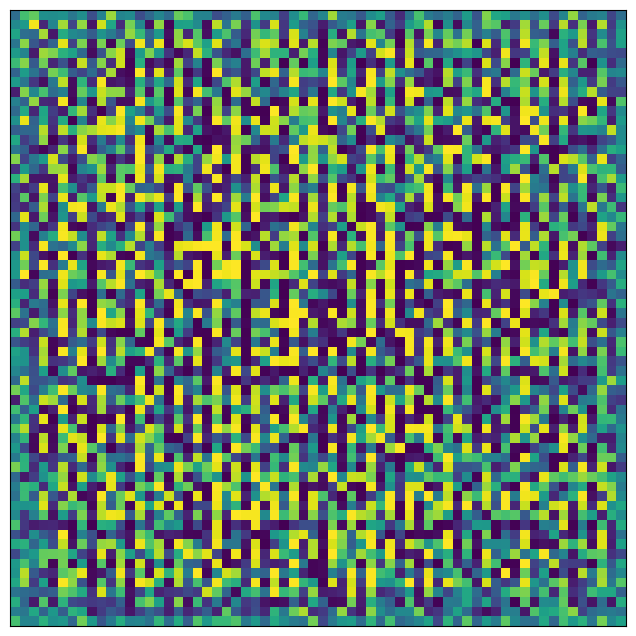

Saving generated-image-0000-01.png


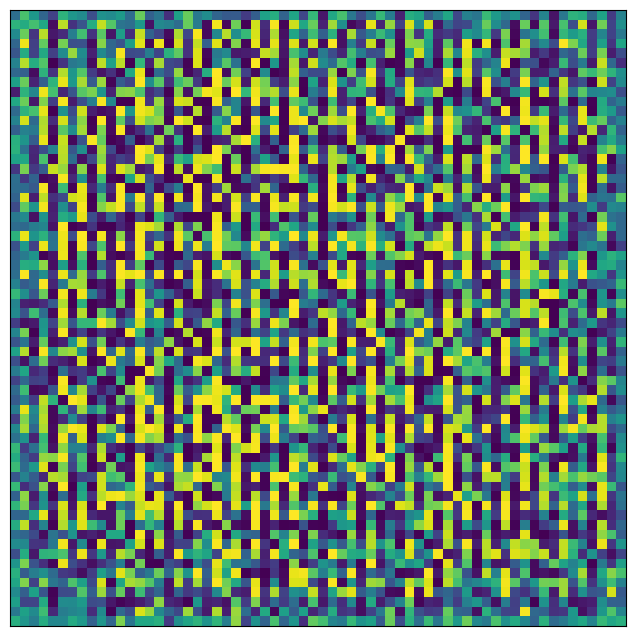

Saving generated-image-0000-02.png


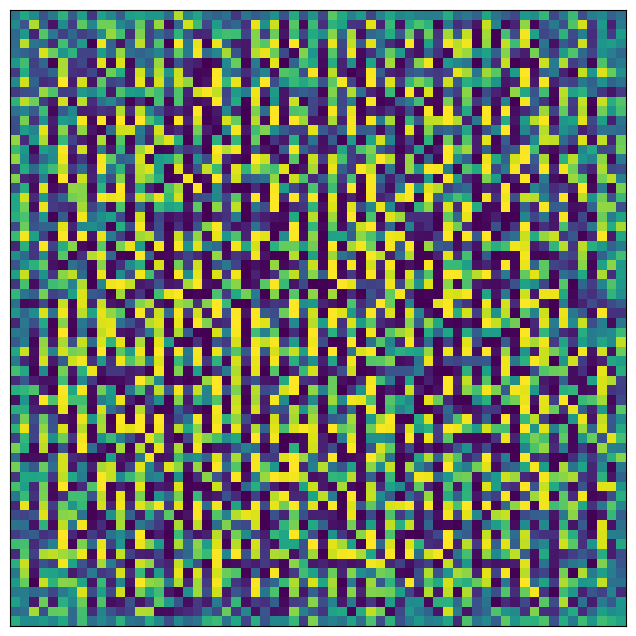

Saving generated-image-0000-03.png


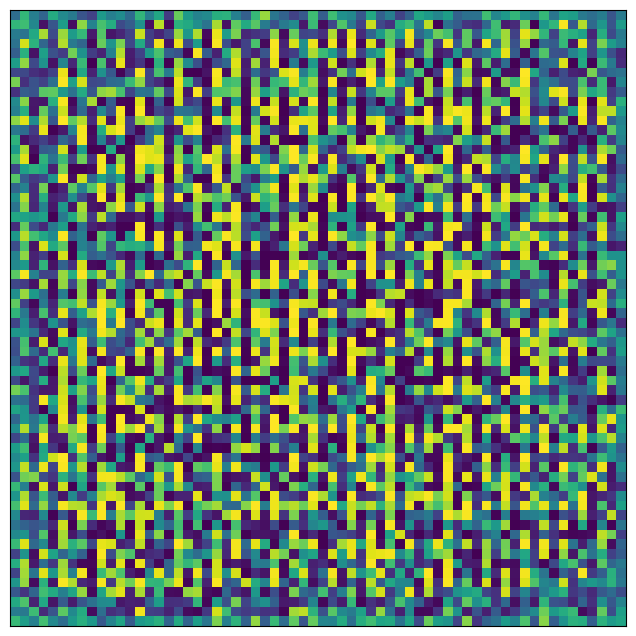

Saving generated-image-0000-04.png


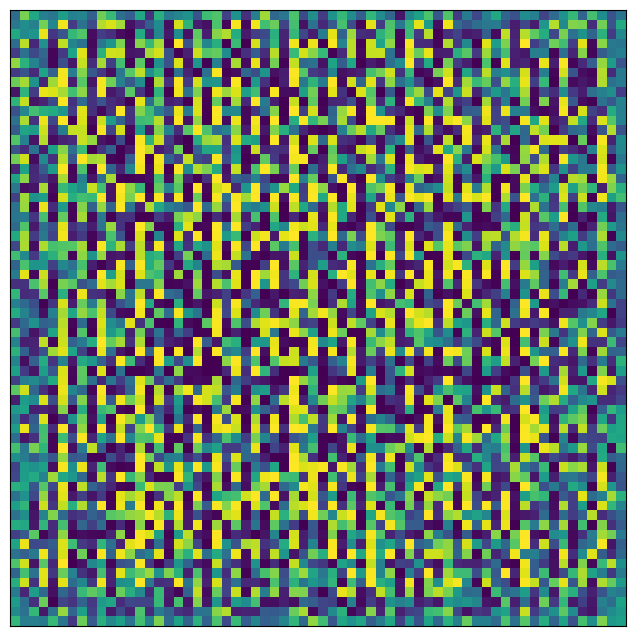

Saving generated-image-0000-05.png


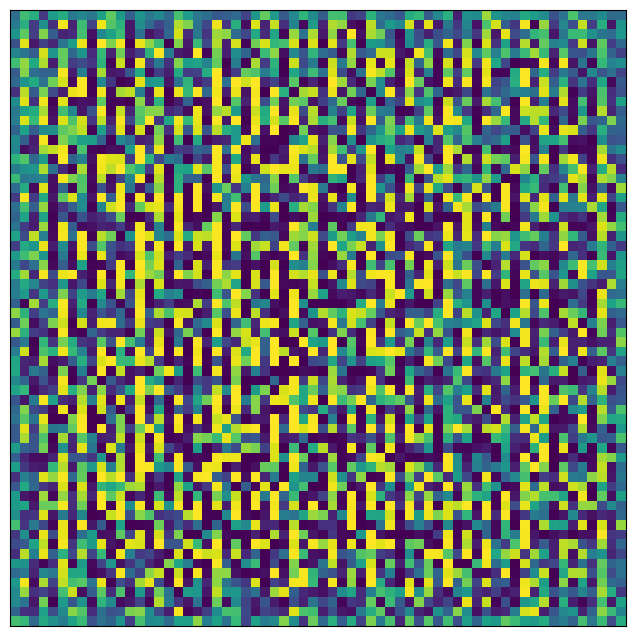

Saving generated-image-0000-06.png


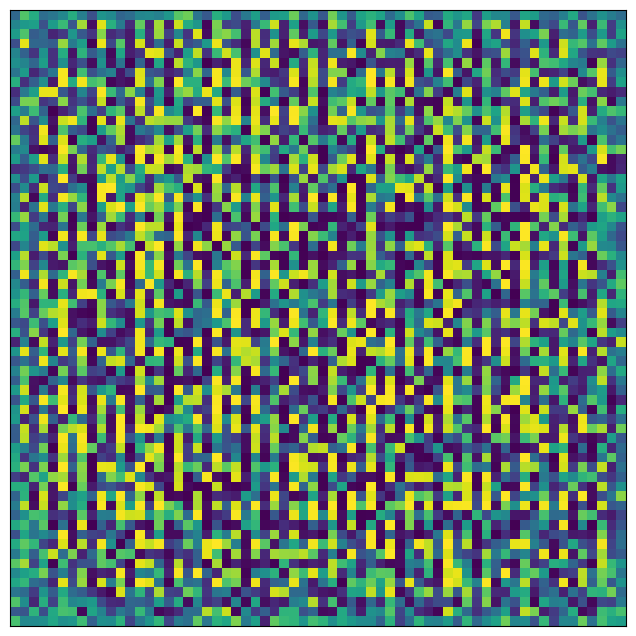

Saving generated-image-0000-07.png


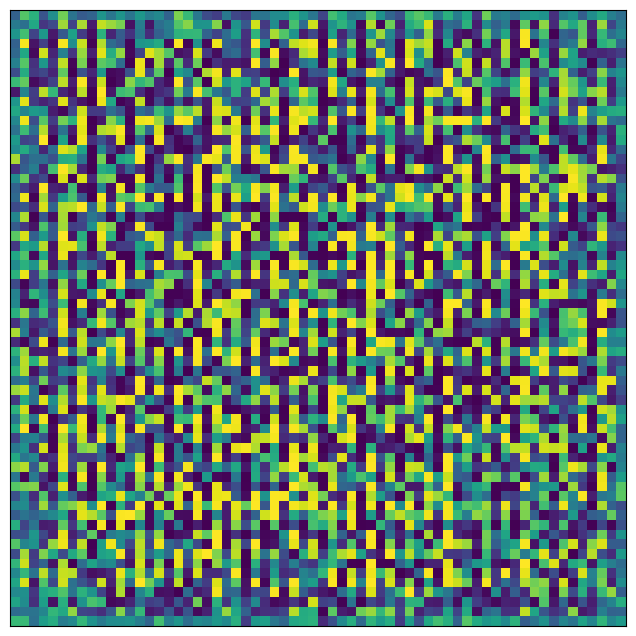

Saving generated-image-0000-08.png


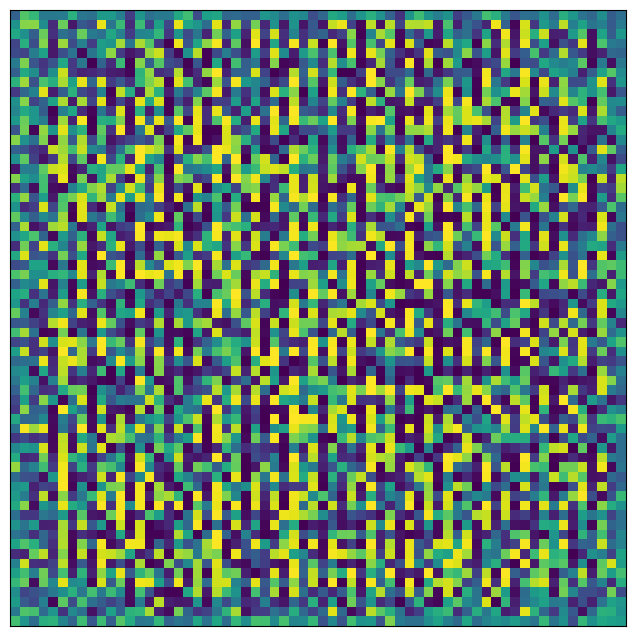

Saving generated-image-0000-09.png


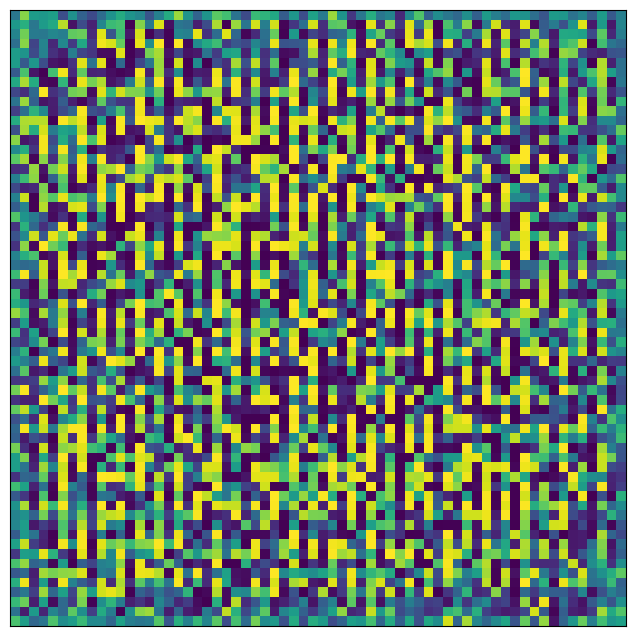

Saving generated-image-0000-10.png


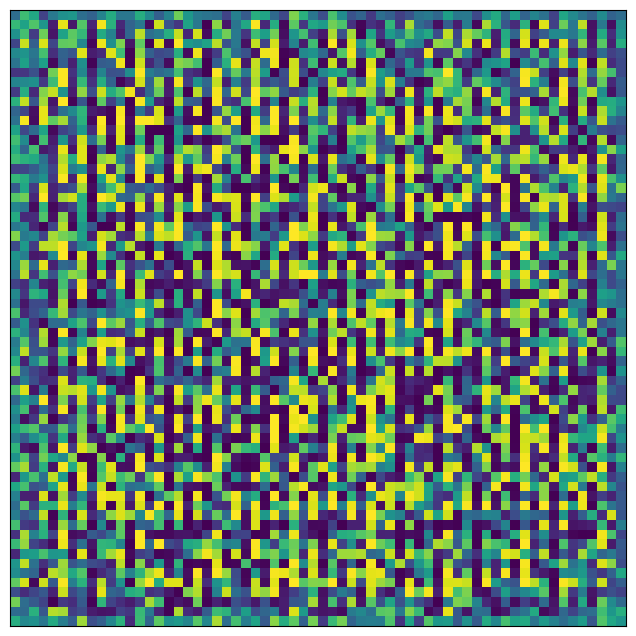

Saving generated-image-0000-11.png


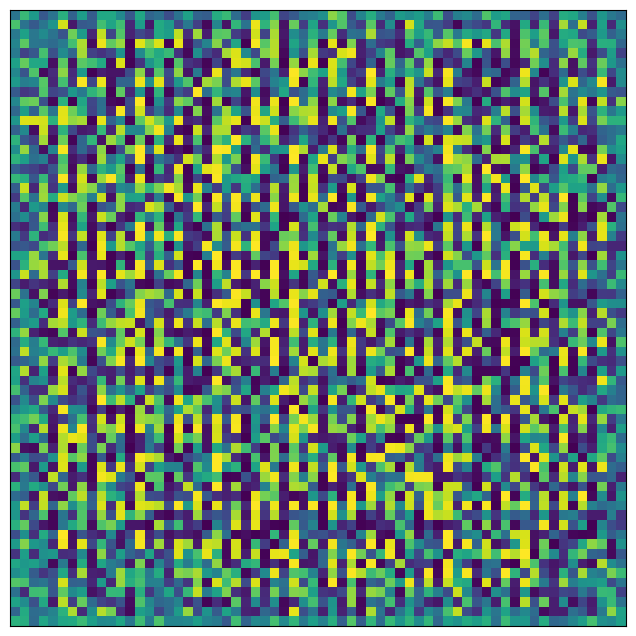

Saving generated-image-0000-12.png


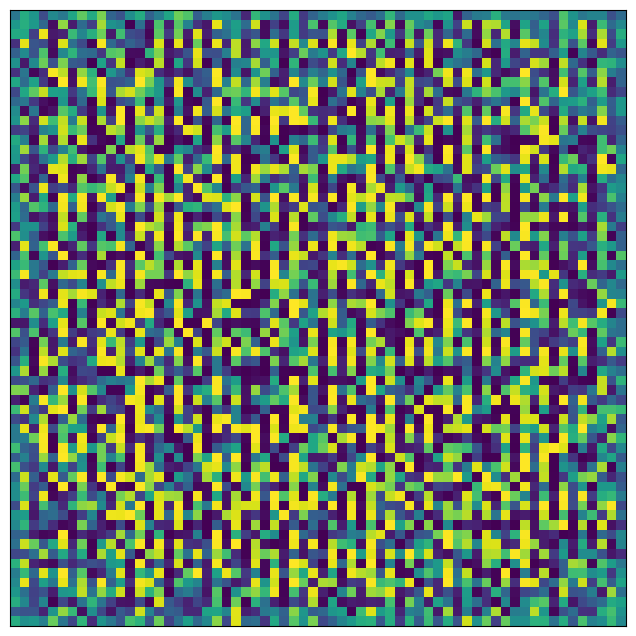

Saving generated-image-0000-13.png


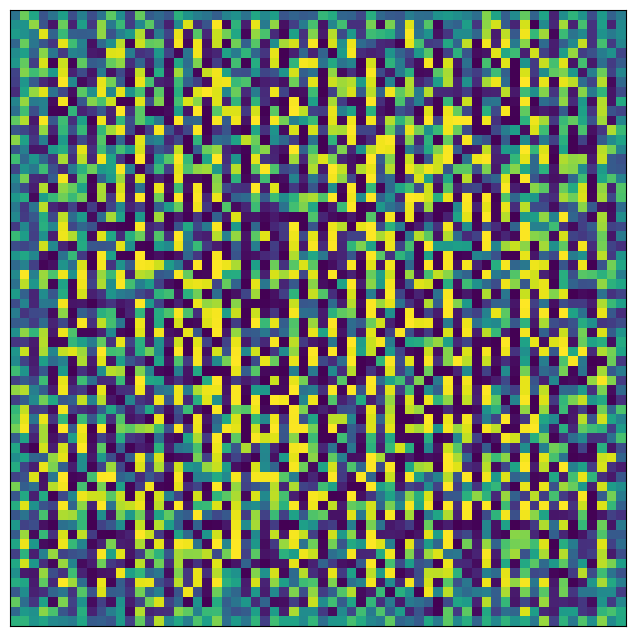

Saving generated-image-0000-14.png


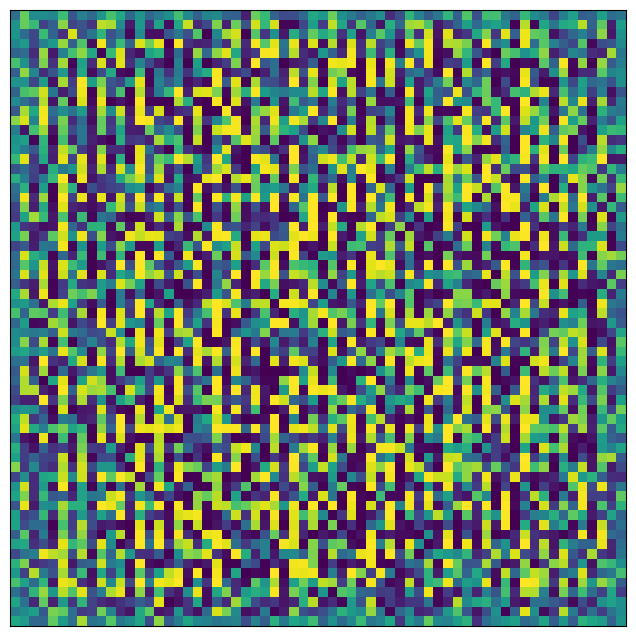

Saving generated-image-0000-15.png


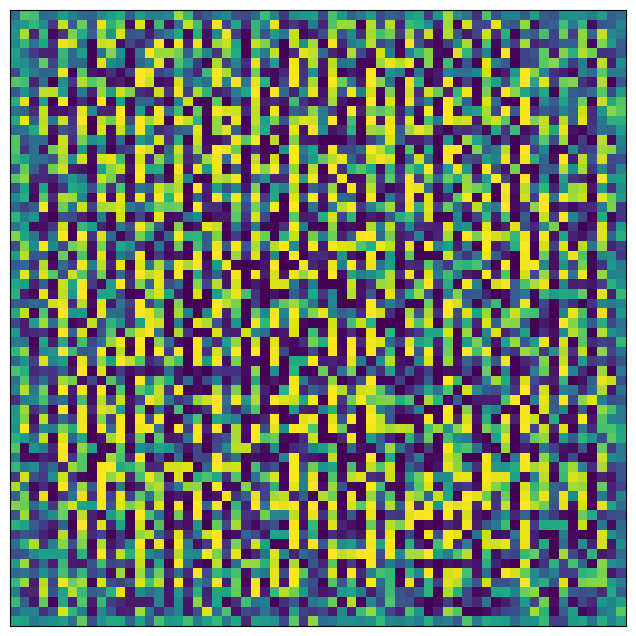

Saving generated-image-0000-16.png


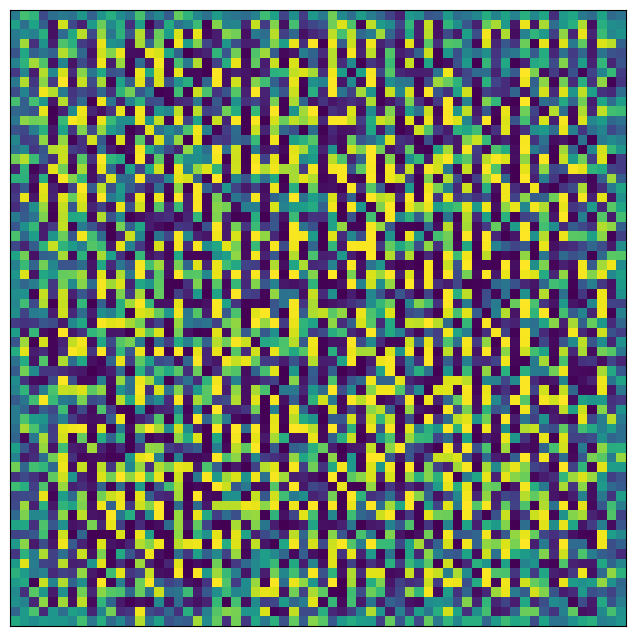

Saving generated-image-0000-17.png


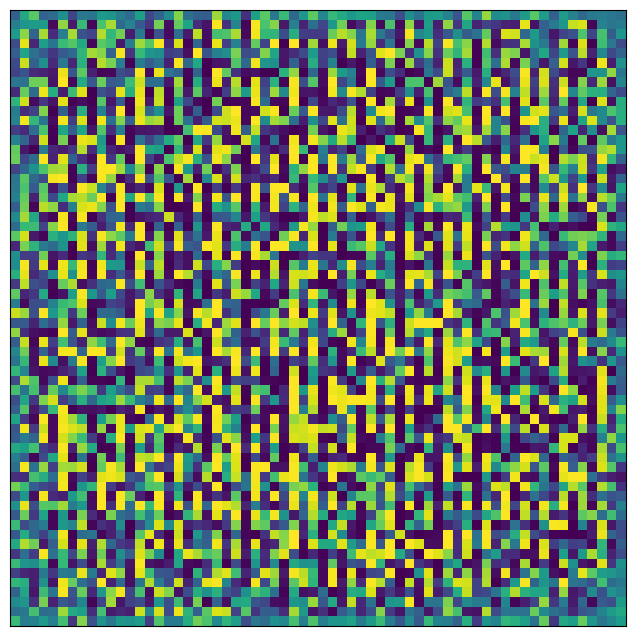

Saving generated-image-0000-18.png


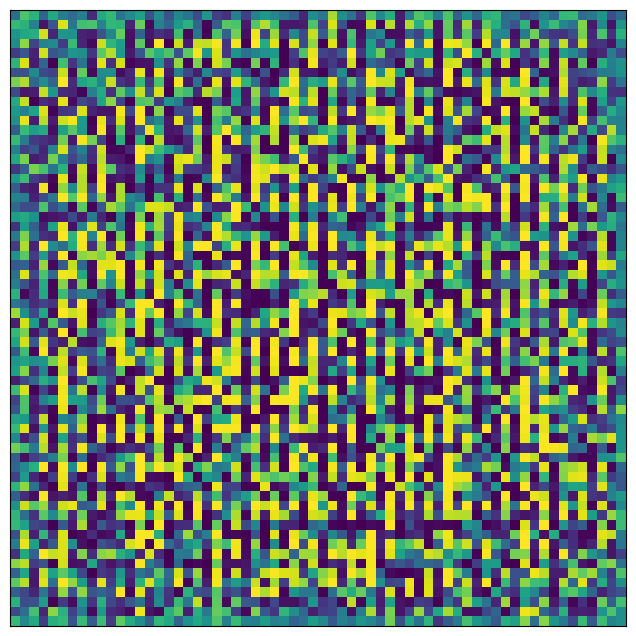

Saving generated-image-0000-19.png


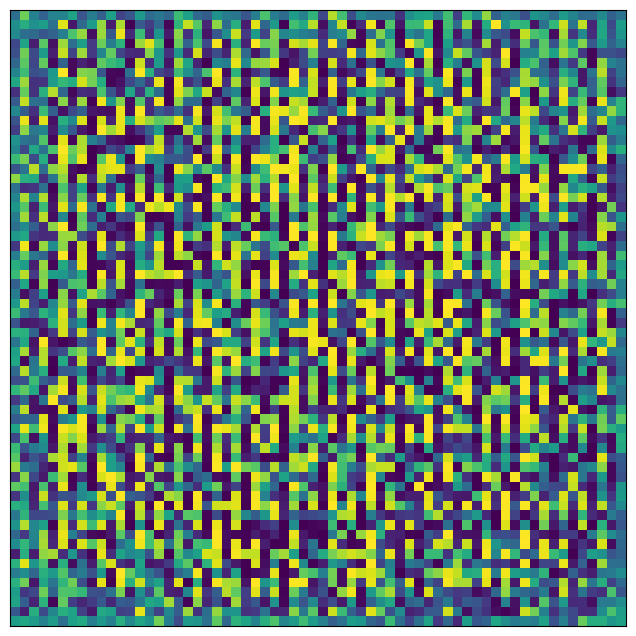

Saving generated-image-0000-20.png


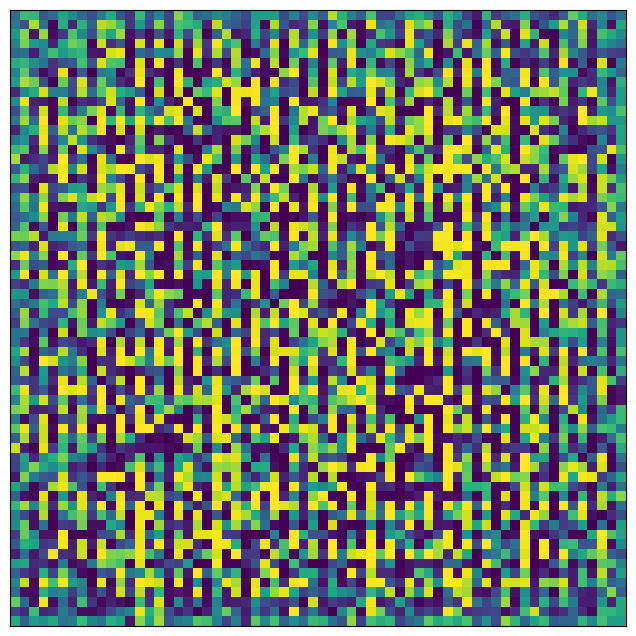

Saving generated-image-0000-21.png


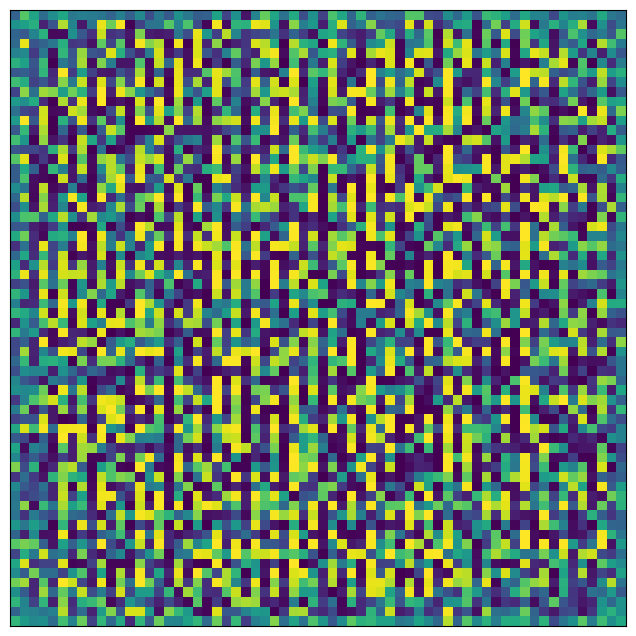

Saving generated-image-0000-22.png


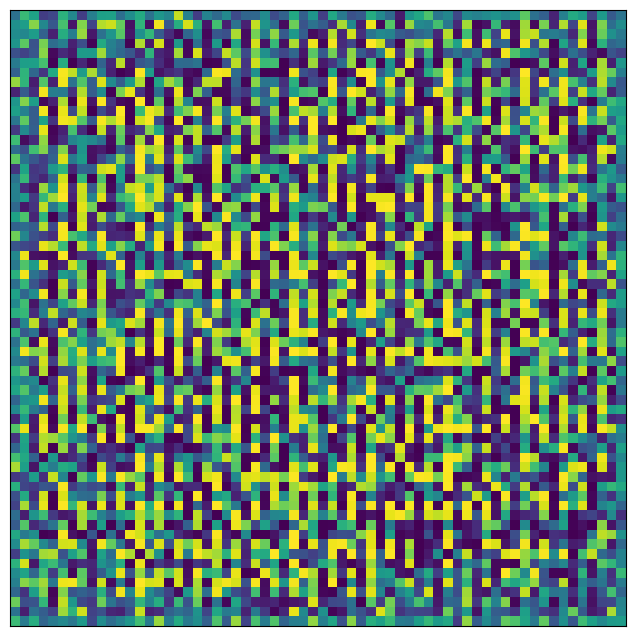

Saving generated-image-0000-23.png


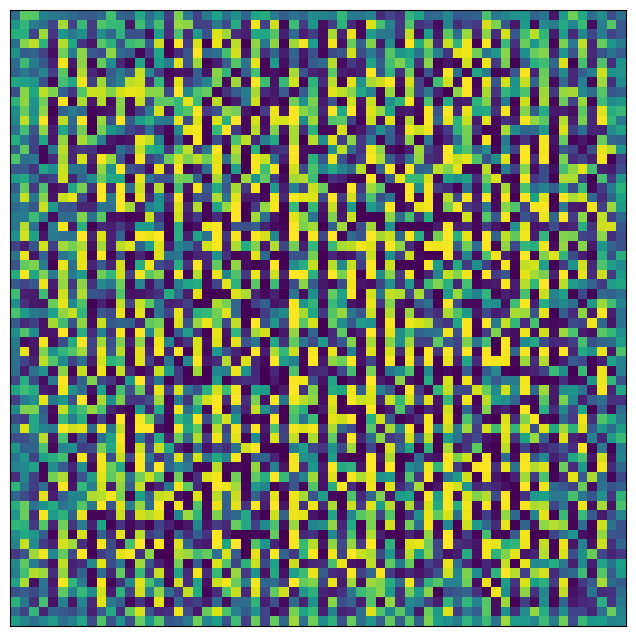

Saving generated-image-0000-24.png


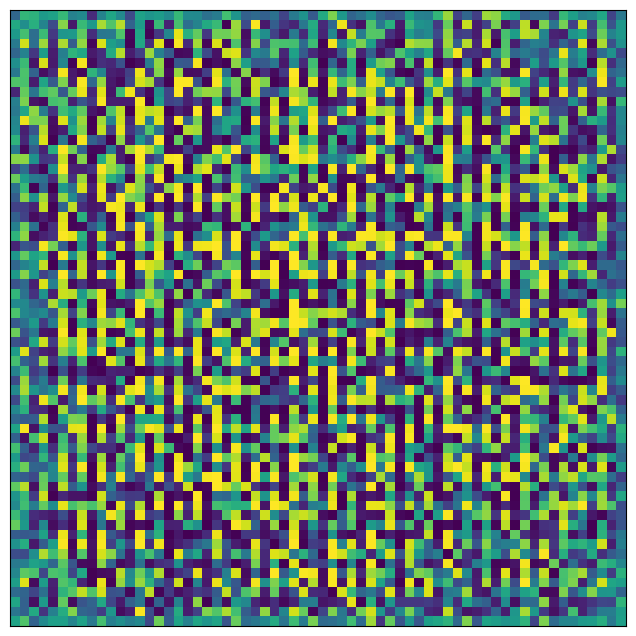

Saving generated-image-0000-25.png


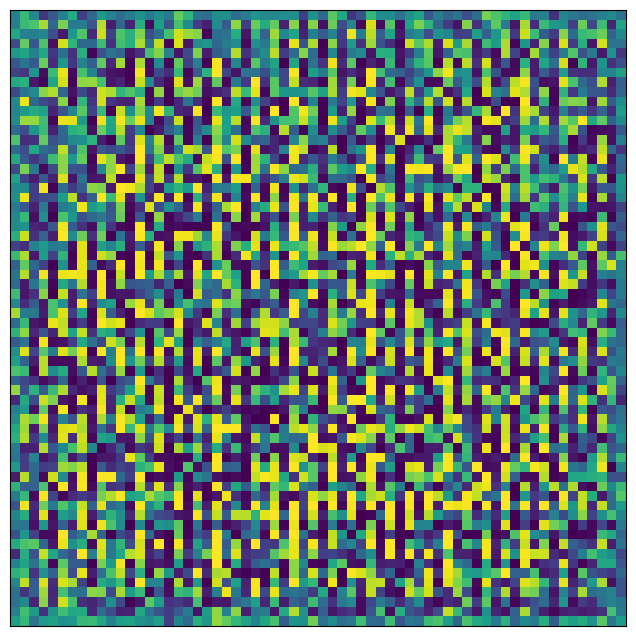

Saving generated-image-0000-26.png


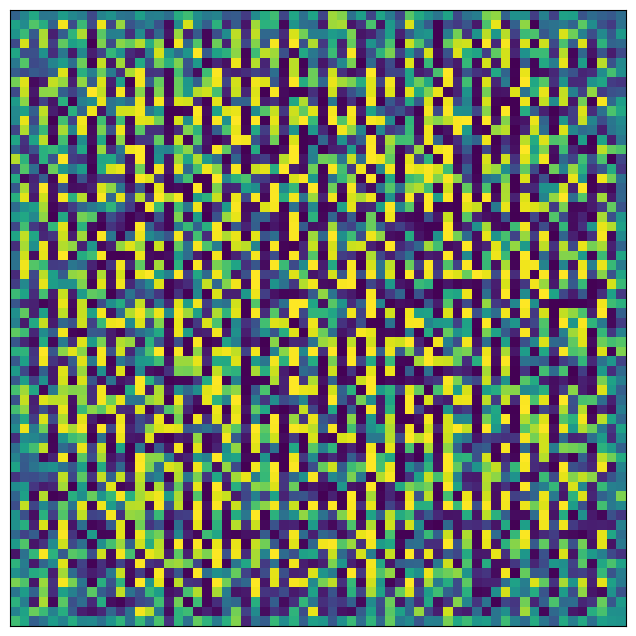

Saving generated-image-0000-27.png


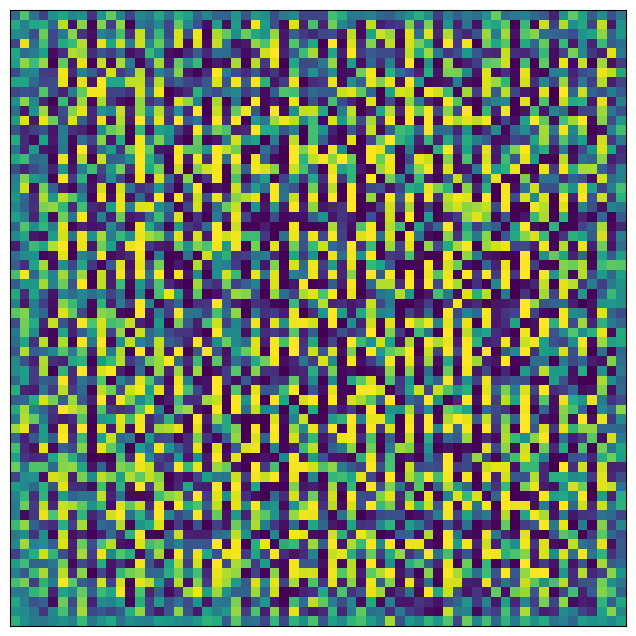

Saving generated-image-0000-28.png


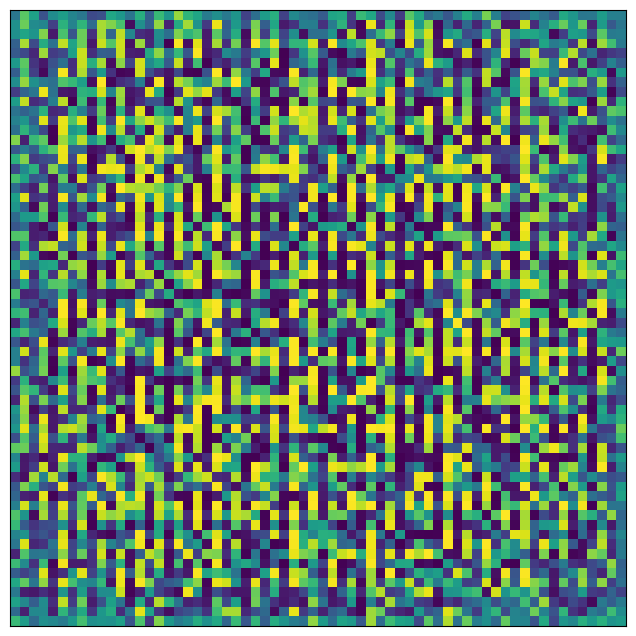

Saving generated-image-0000-29.png


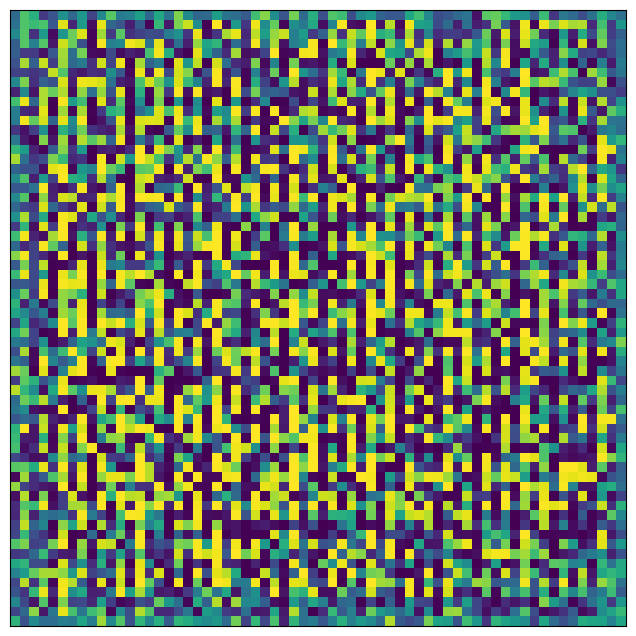

Saving generated-image-0000-30.png


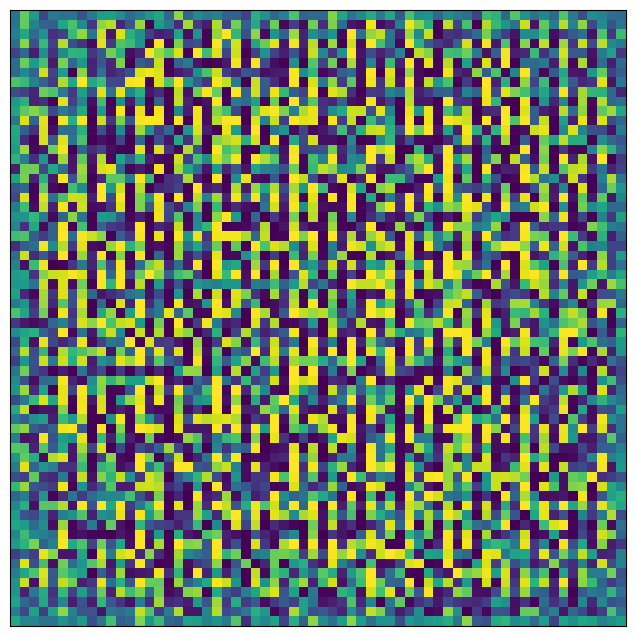

Saving generated-image-0000-31.png


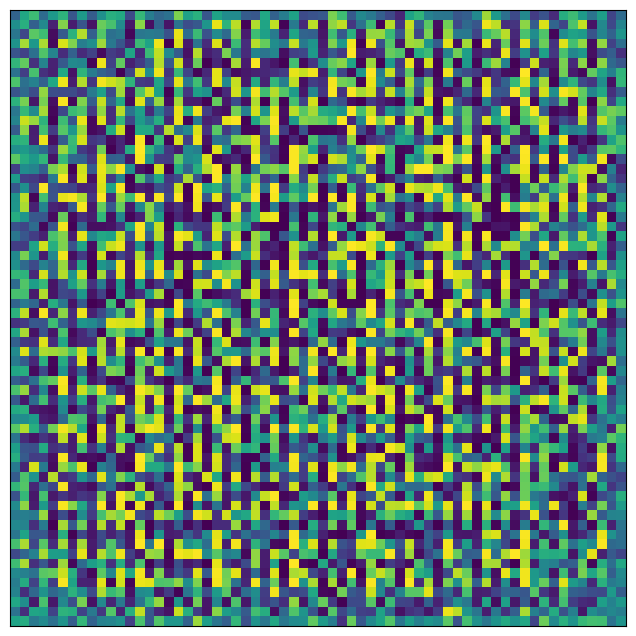

Saving generated-image-0000-32.png


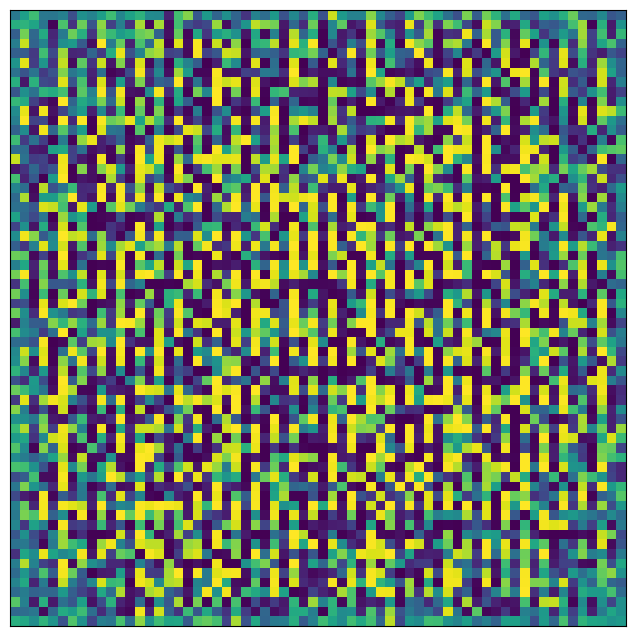

Saving generated-image-0000-33.png


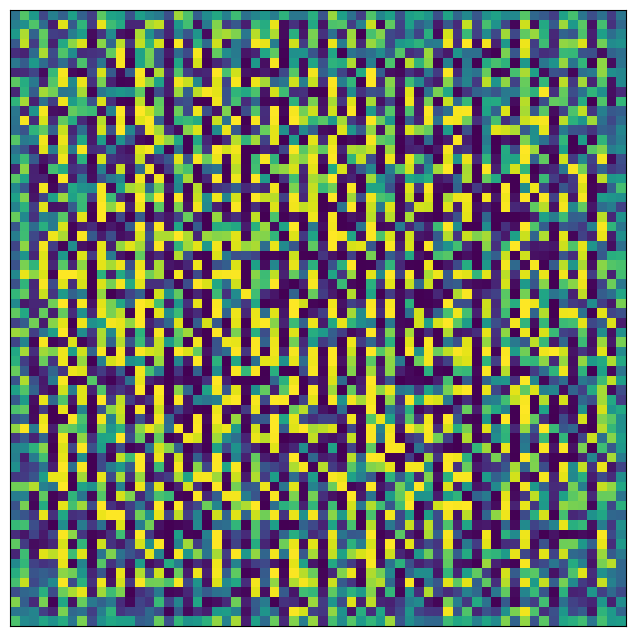

Saving generated-image-0000-34.png


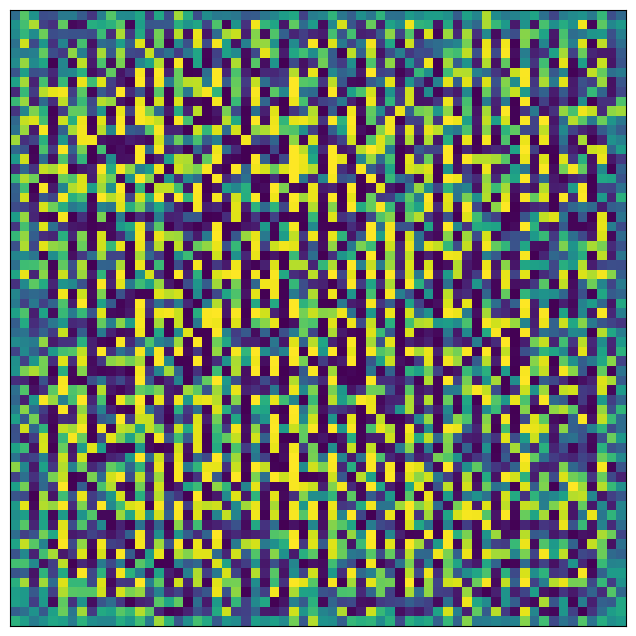

Saving generated-image-0000-35.png


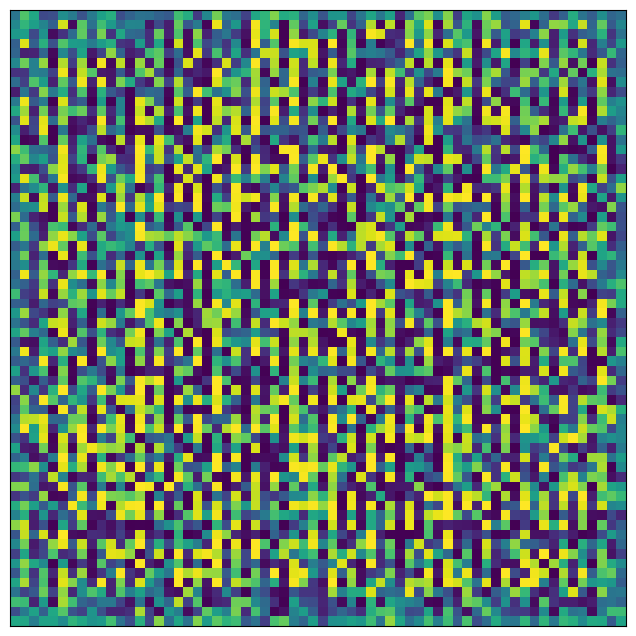

Saving generated-image-0000-36.png


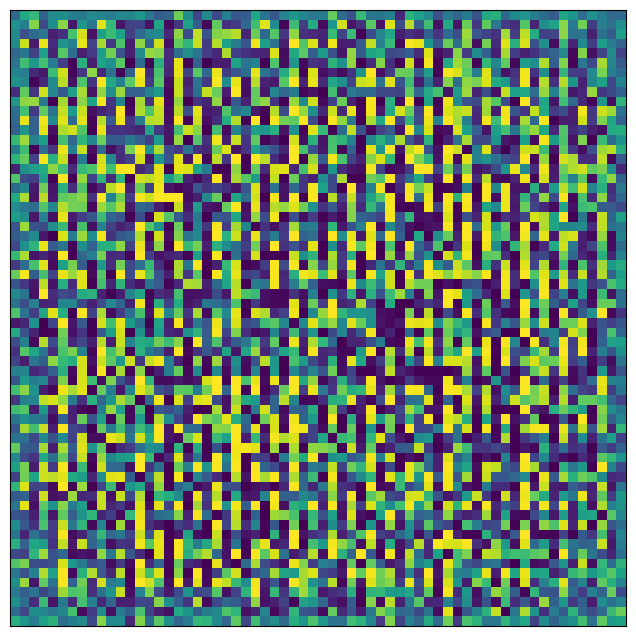

Saving generated-image-0000-37.png


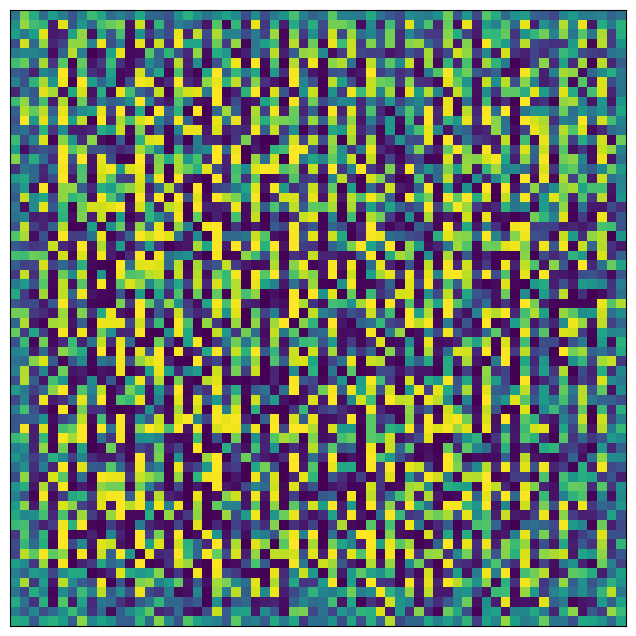

Saving generated-image-0000-38.png


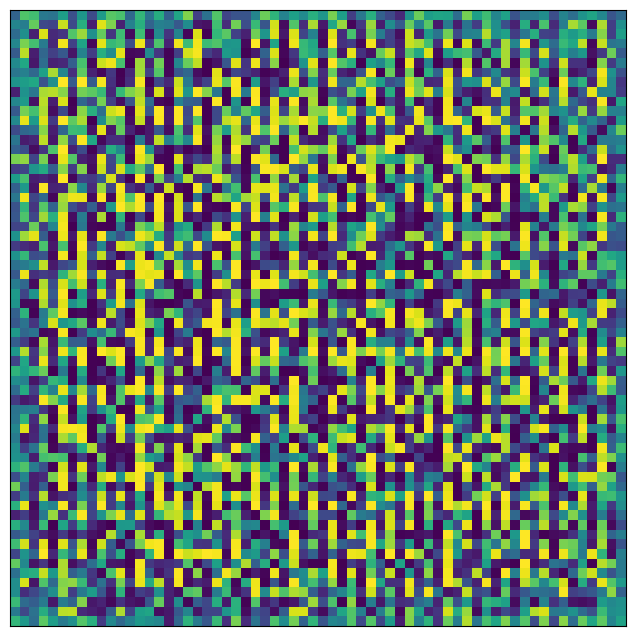

Saving generated-image-0000-39.png


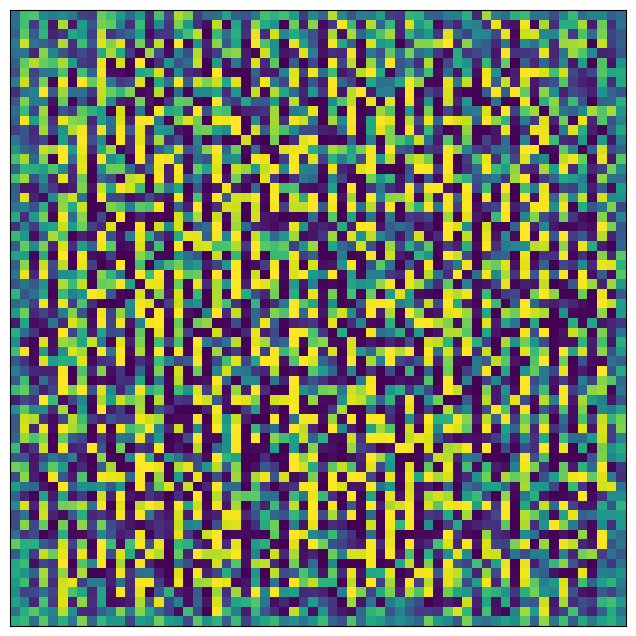

Saving generated-image-0000-40.png


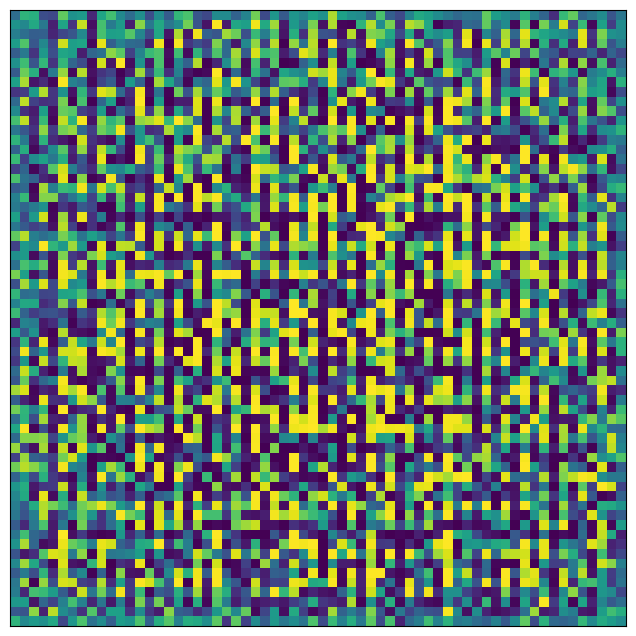

Saving generated-image-0000-41.png


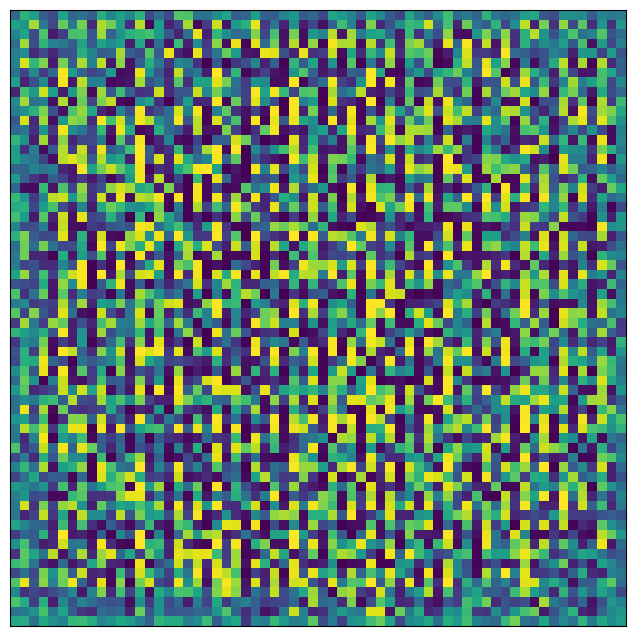

Saving generated-image-0000-42.png


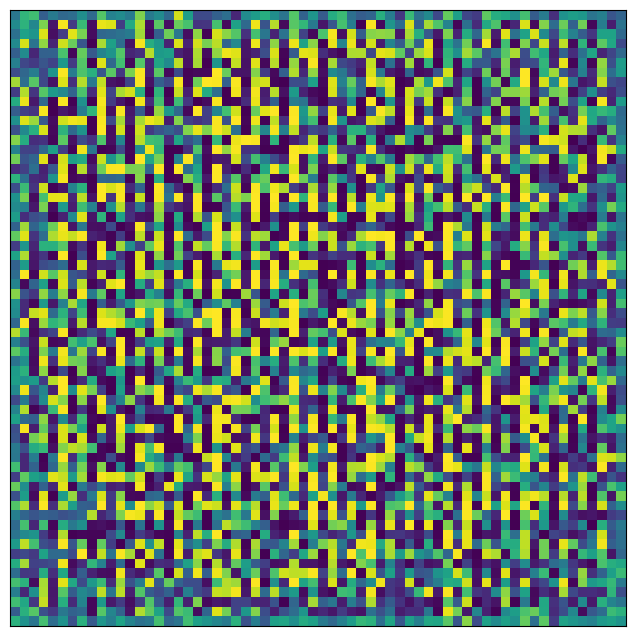

Saving generated-image-0000-43.png


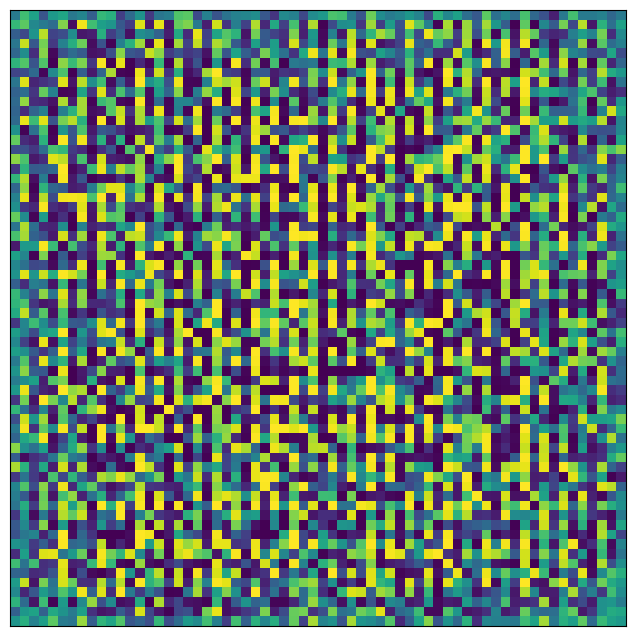

Saving generated-image-0000-44.png


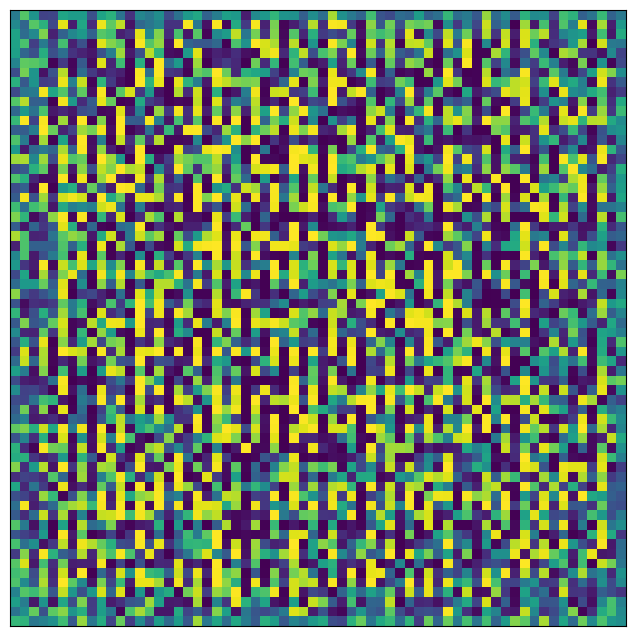

Saving generated-image-0000-45.png


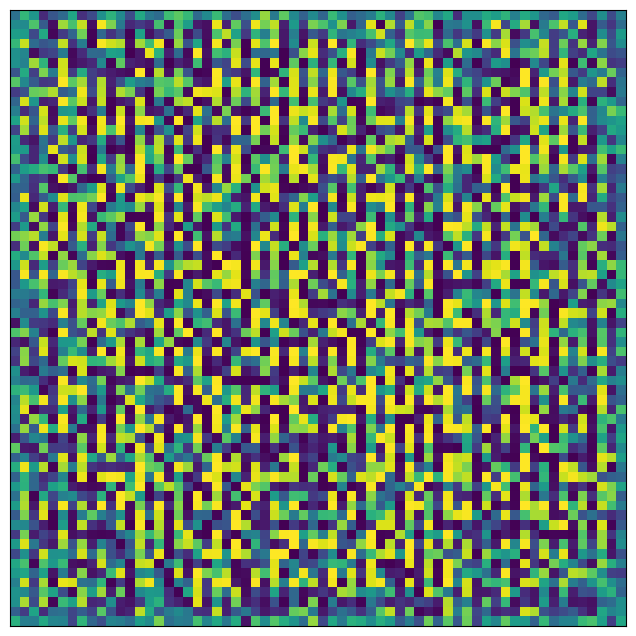

Saving generated-image-0000-46.png


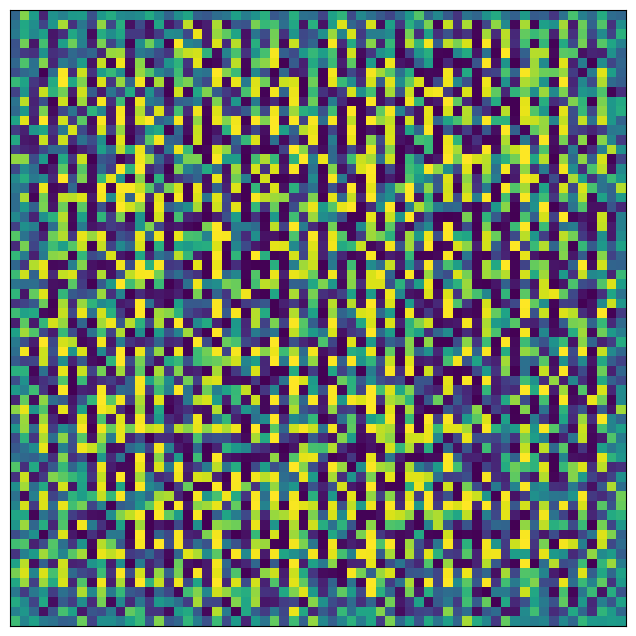

Saving generated-image-0000-47.png


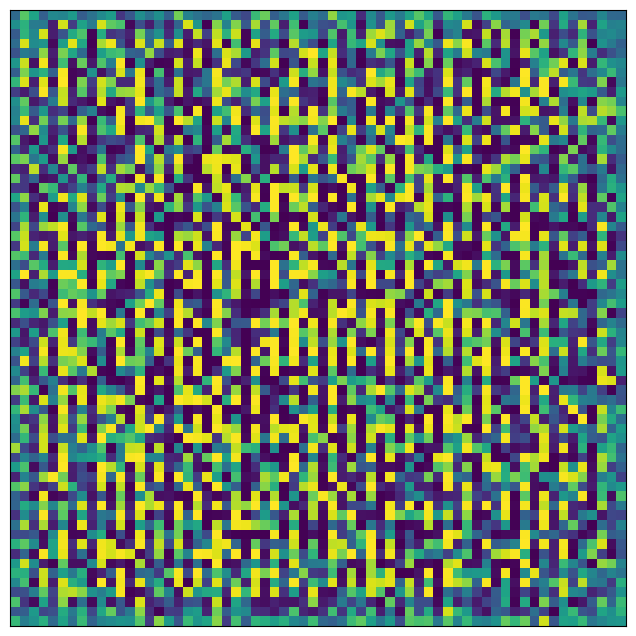

Saving generated-image-0000-48.png


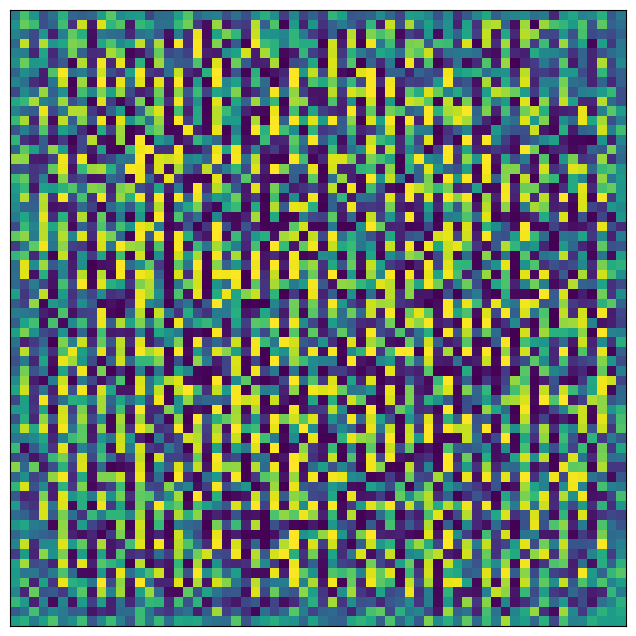

Saving generated-image-0000-49.png


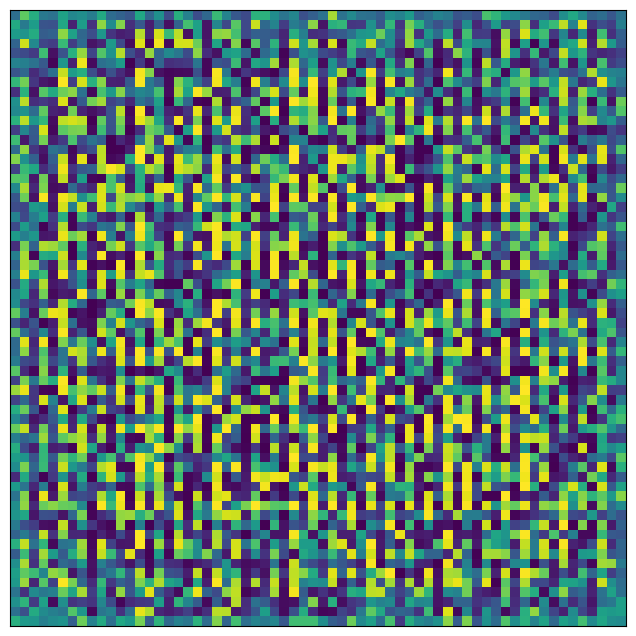

Saving generated-image-0000-50.png


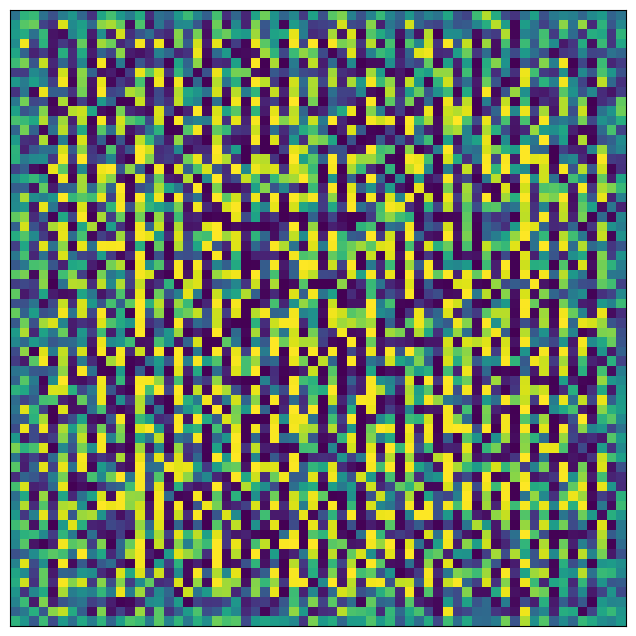

Saving generated-image-0000-51.png


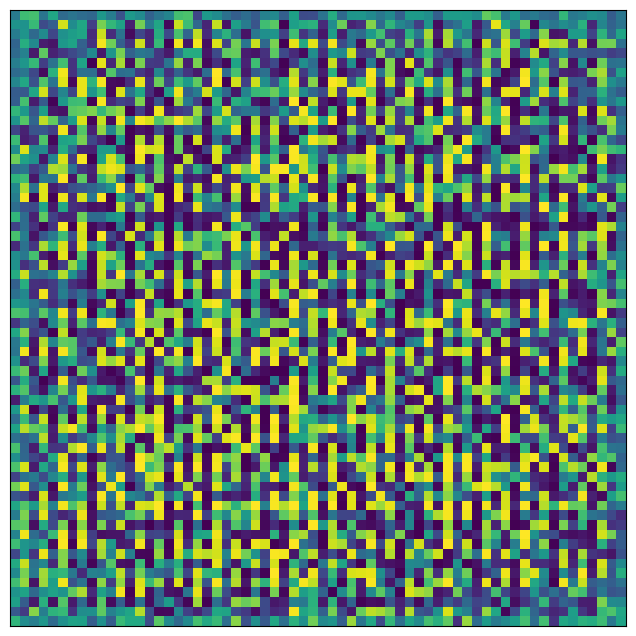

Saving generated-image-0000-52.png


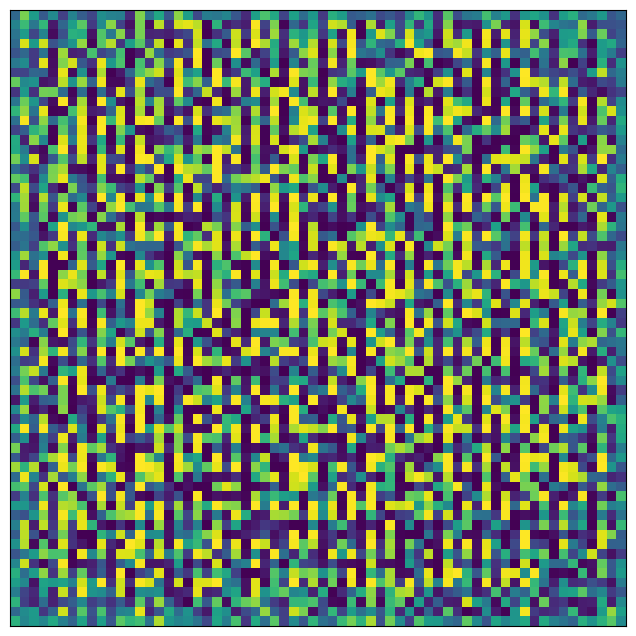

Saving generated-image-0000-53.png


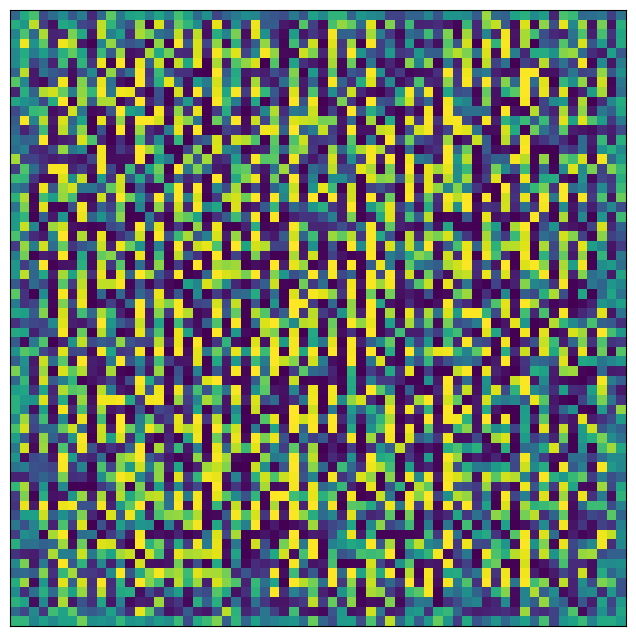

Saving generated-image-0000-54.png


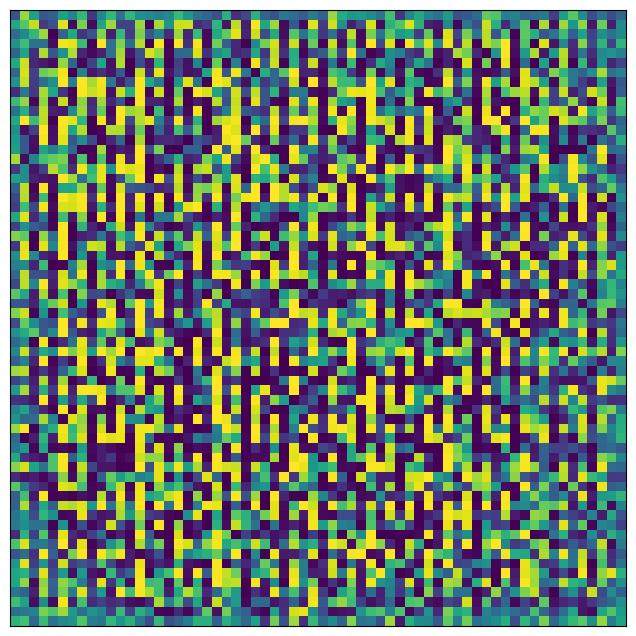

Saving generated-image-0000-55.png


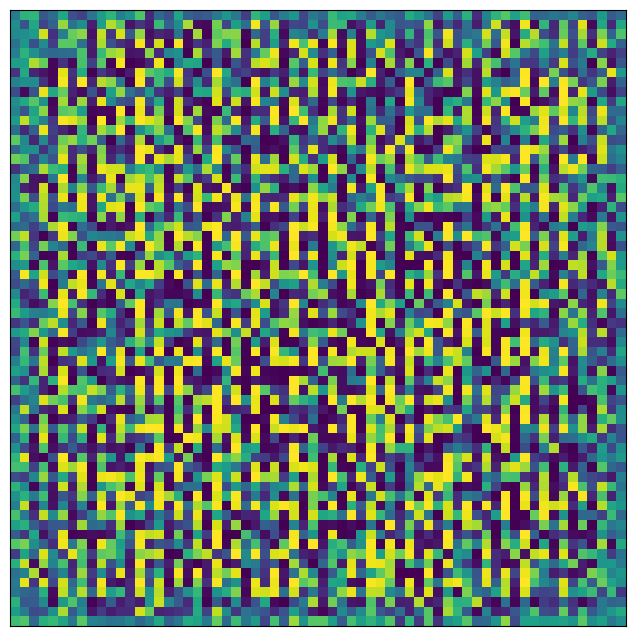

Saving generated-image-0000-56.png


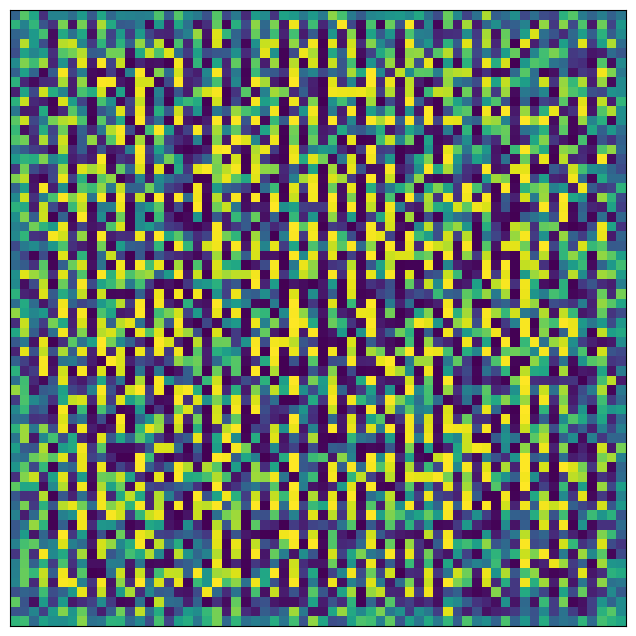

Saving generated-image-0000-57.png


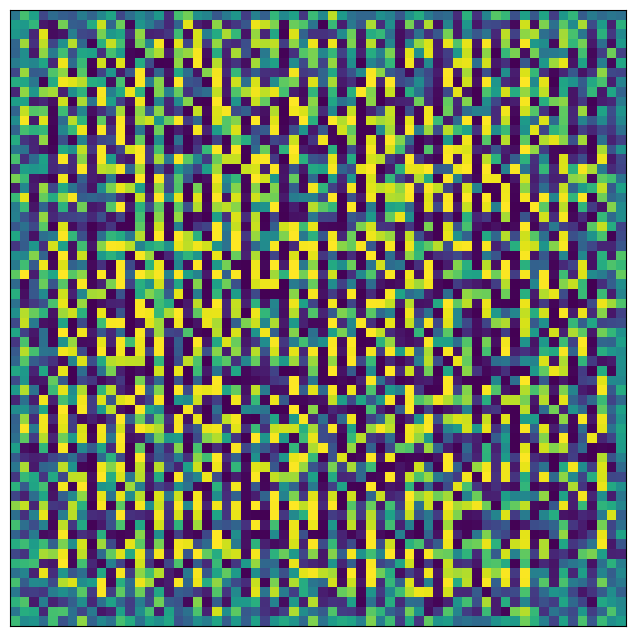

Saving generated-image-0000-58.png


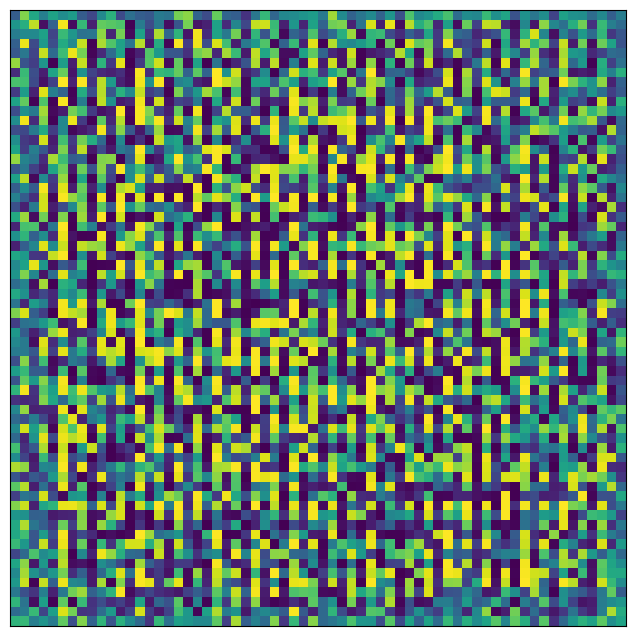

Saving generated-image-0000-59.png


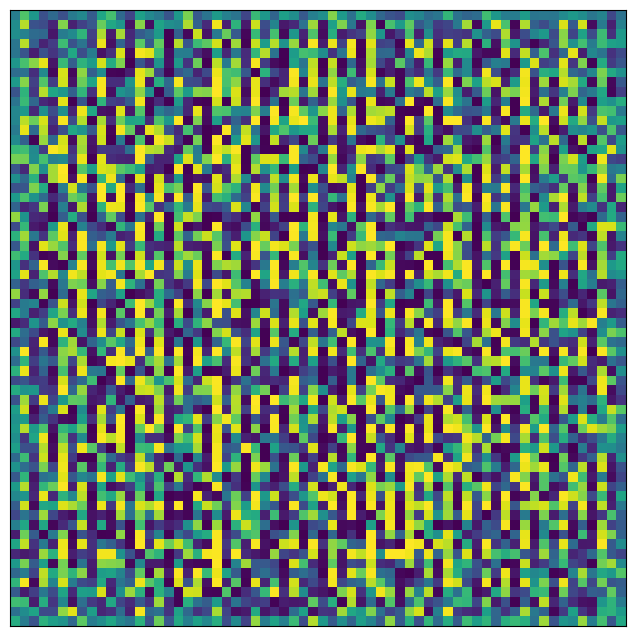

Saving generated-image-0000-60.png


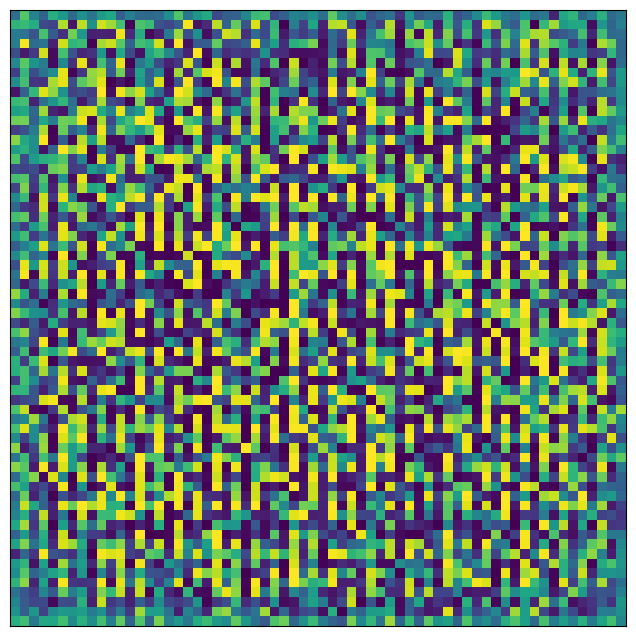

Saving generated-image-0000-61.png


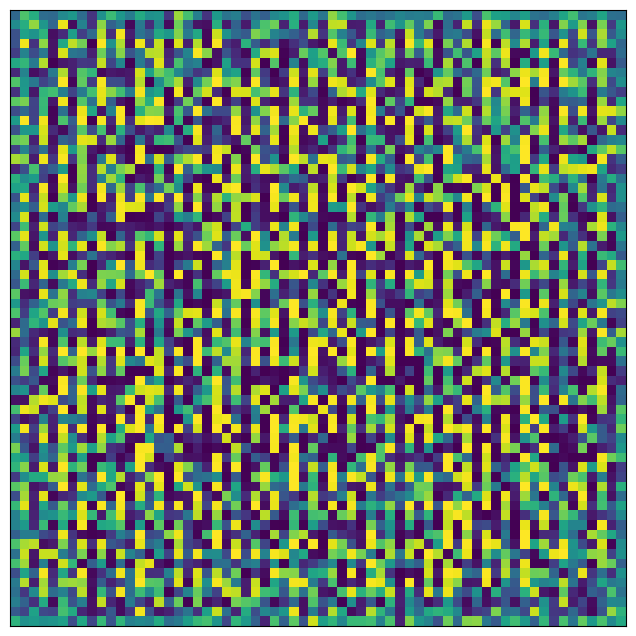

Saving generated-image-0000-62.png


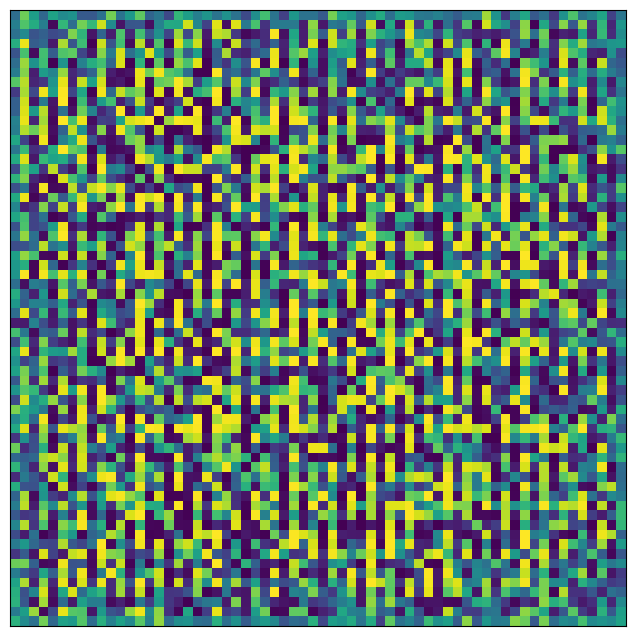

Saving generated-image-0000-63.png


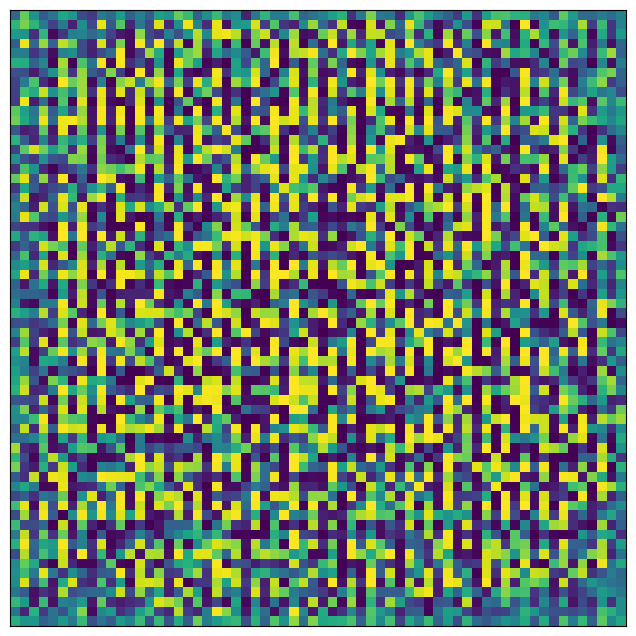

Saving generated-image-0000-64.png


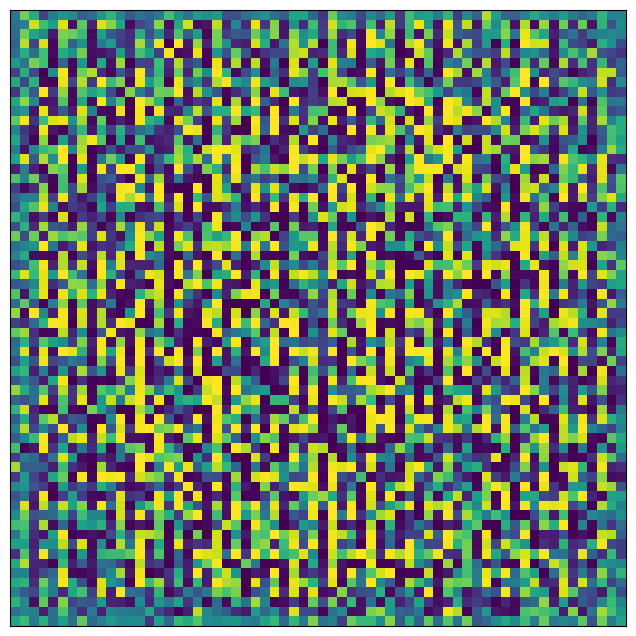

Saving generated-image-0000-65.png


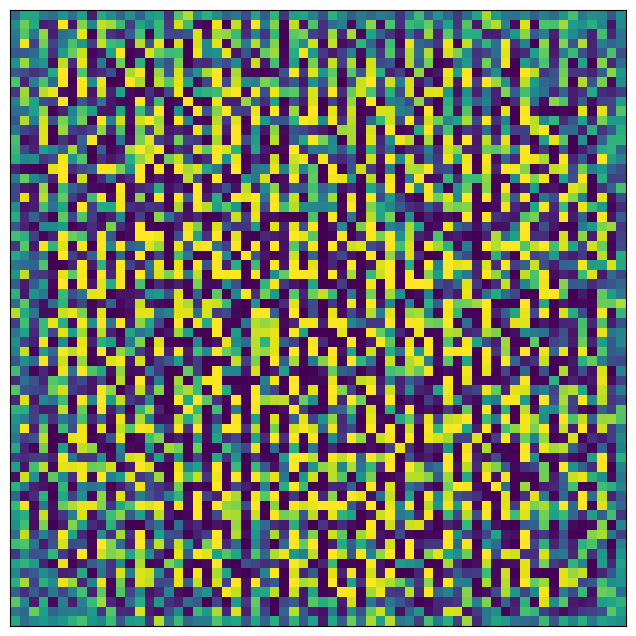

Saving generated-image-0000-66.png


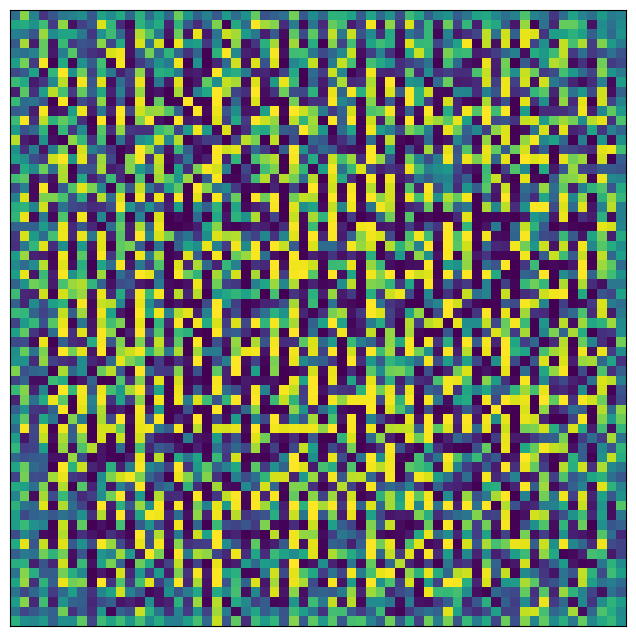

Saving generated-image-0000-67.png


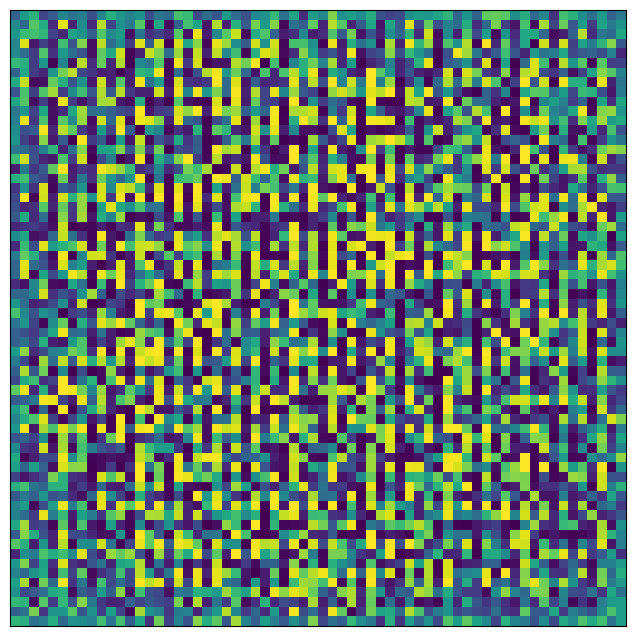

Saving generated-image-0000-68.png


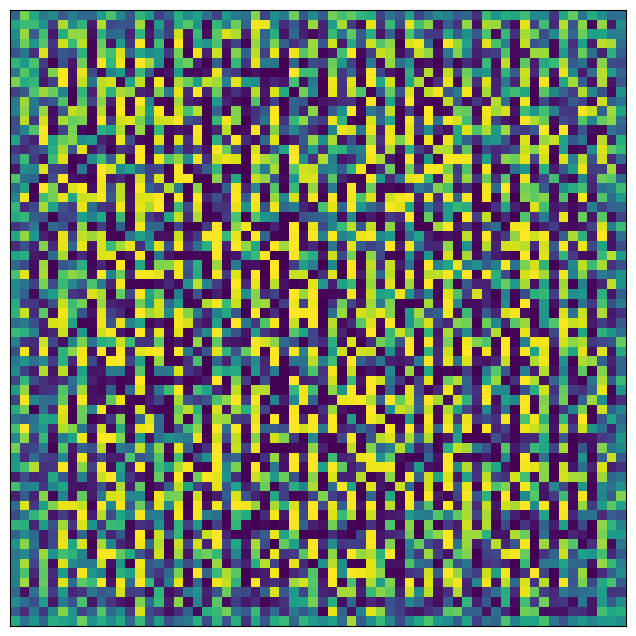

Saving generated-image-0000-69.png


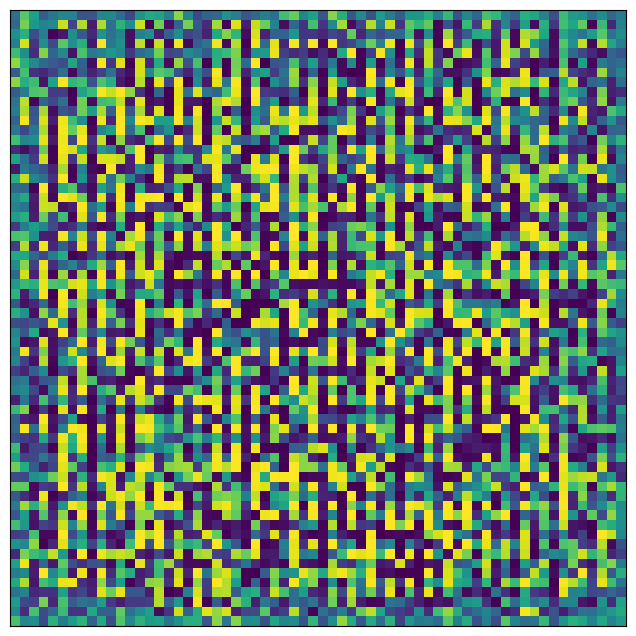

Saving generated-image-0000-70.png


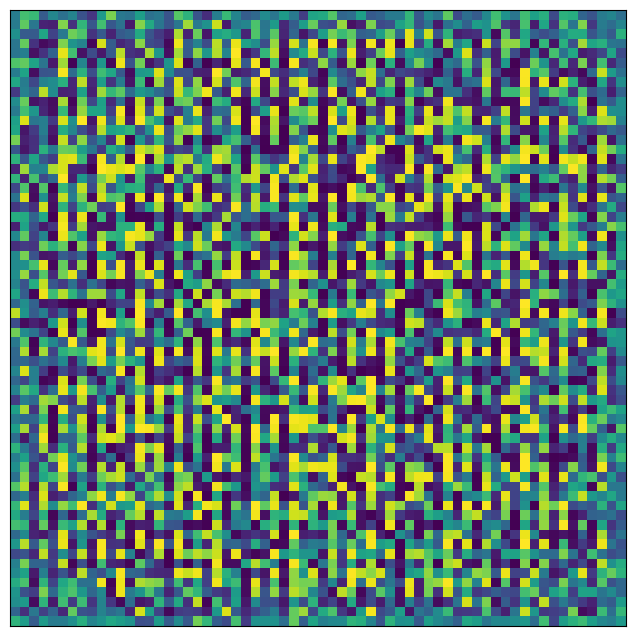

Saving generated-image-0000-71.png


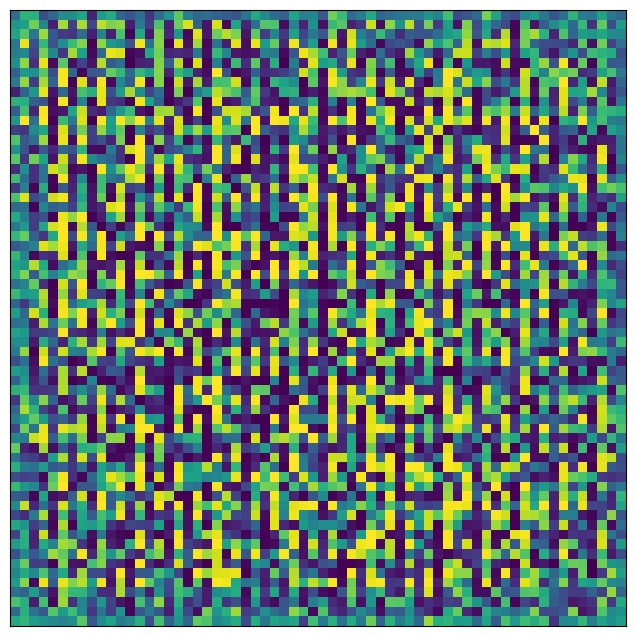

Saving generated-image-0000-72.png


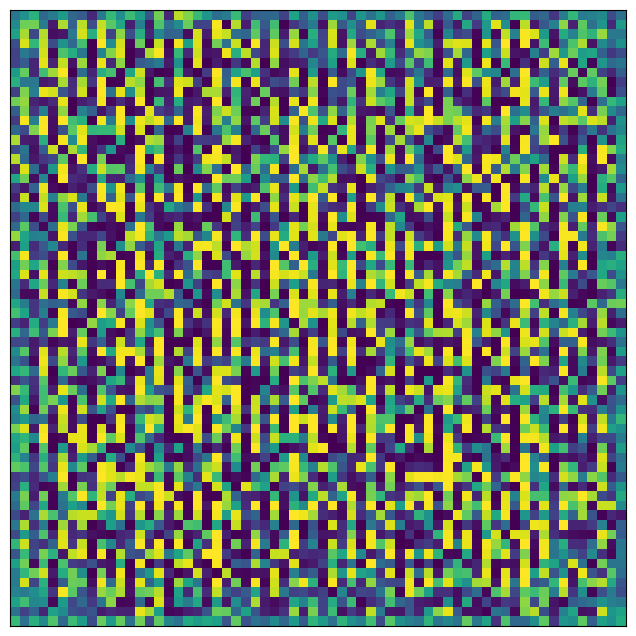

Saving generated-image-0000-73.png


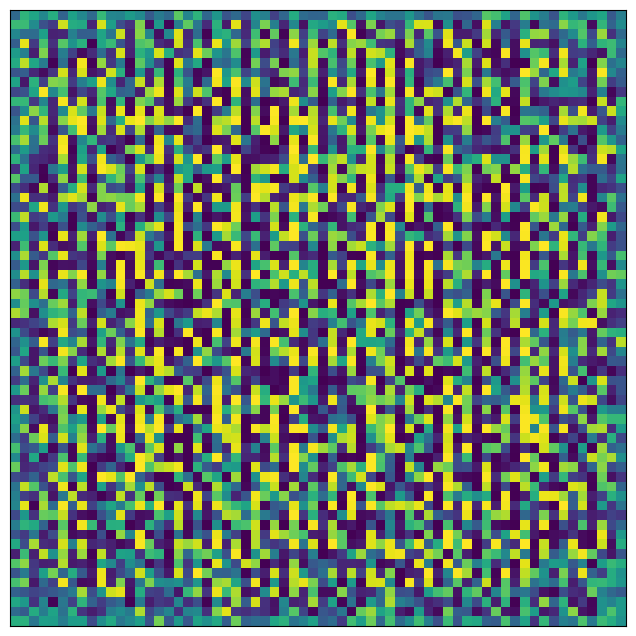

Saving generated-image-0000-74.png


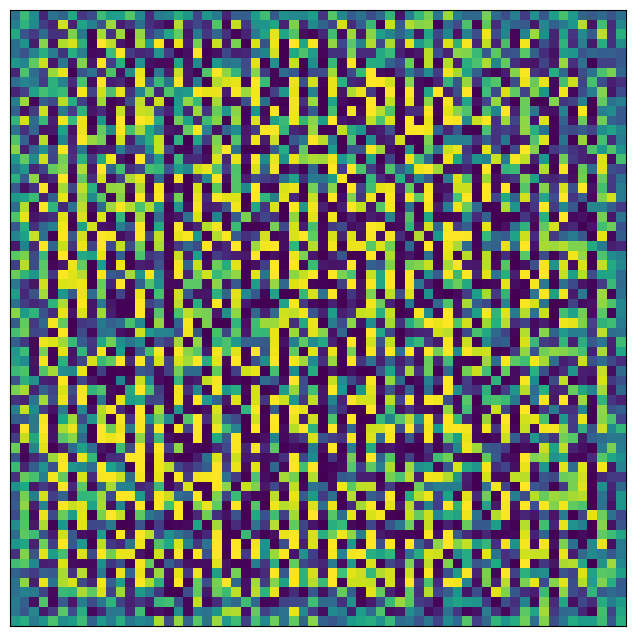

Saving generated-image-0000-75.png


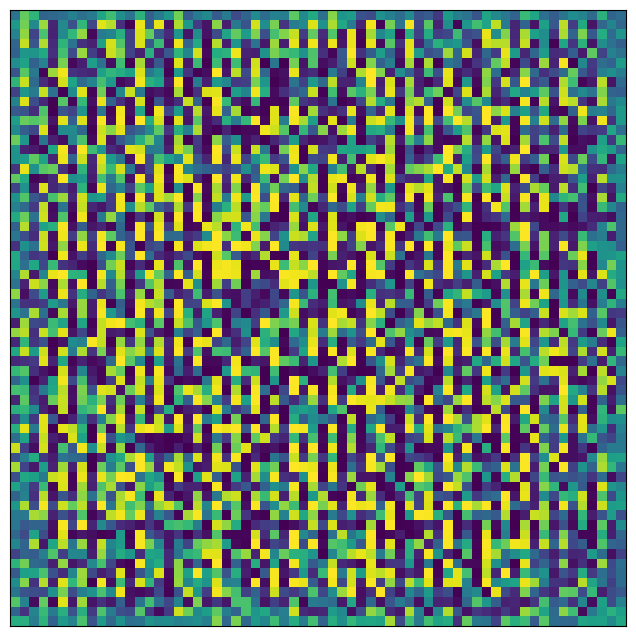

Saving generated-image-0000-76.png


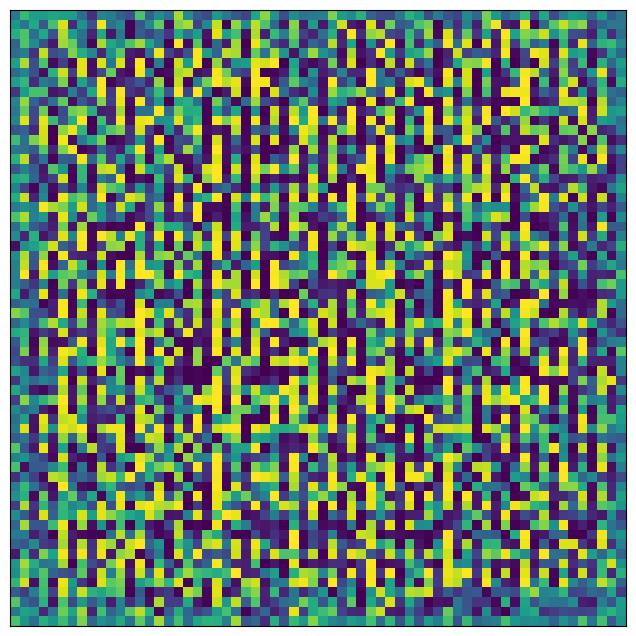

Saving generated-image-0000-77.png


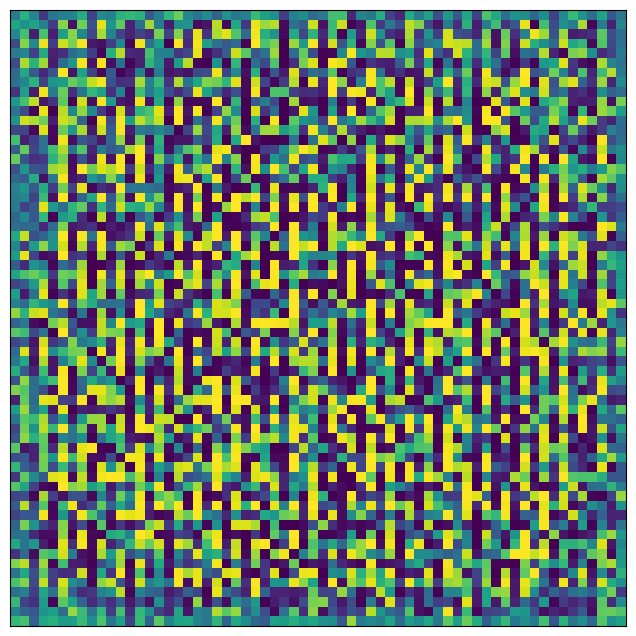

Saving generated-image-0000-78.png


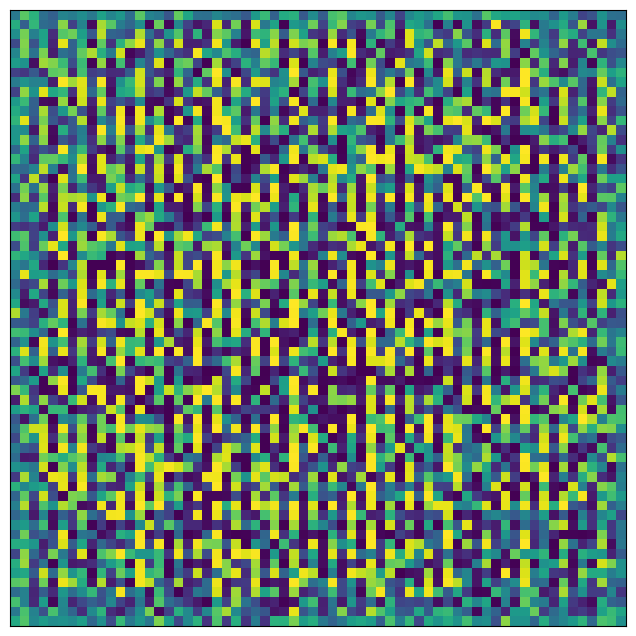

Saving generated-image-0000-79.png


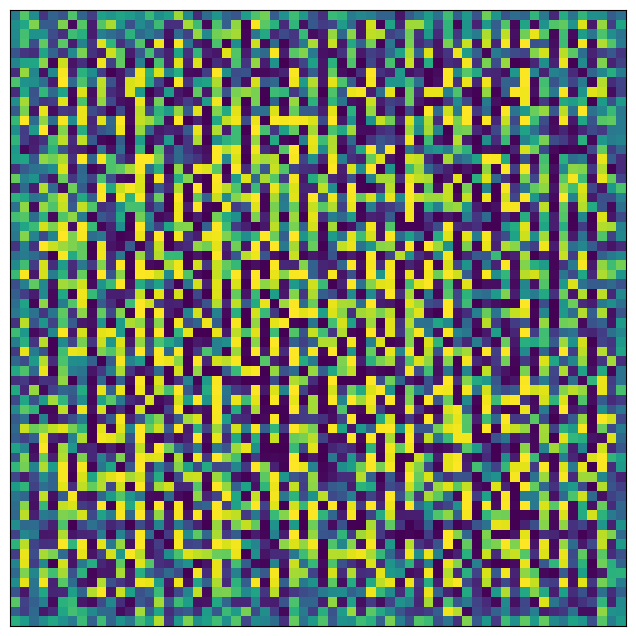

Saving generated-image-0000-80.png


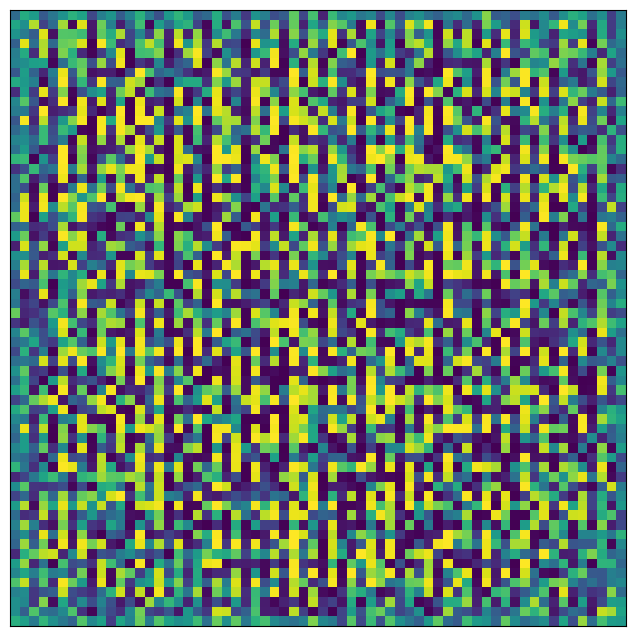

Saving generated-image-0000-81.png


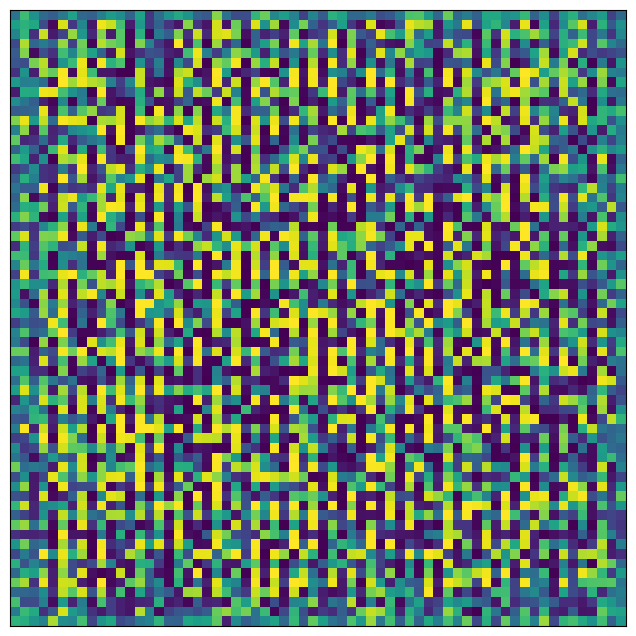

Saving generated-image-0000-82.png


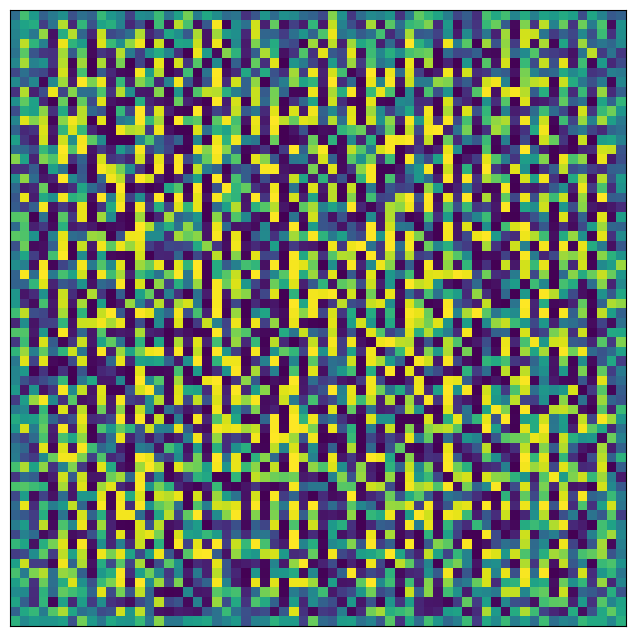

Saving generated-image-0000-83.png


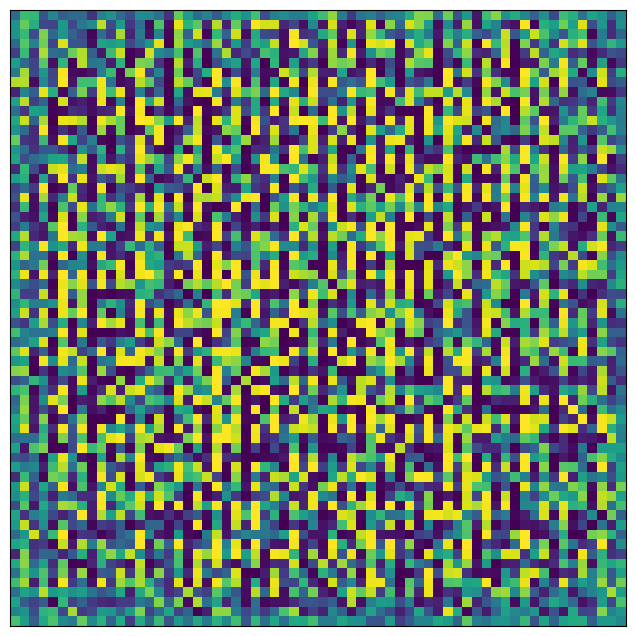

Saving generated-image-0000-84.png


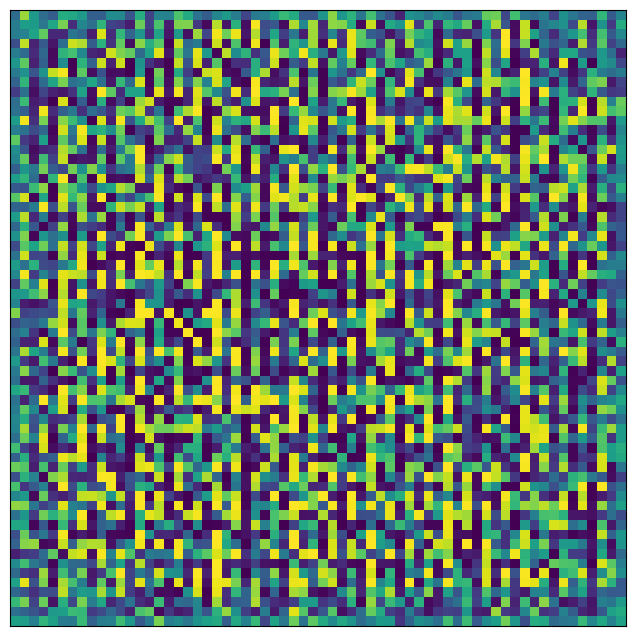

Saving generated-image-0000-85.png


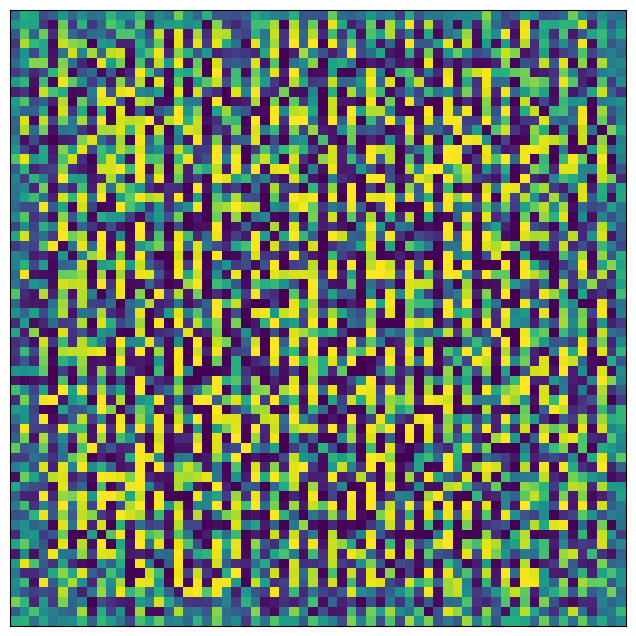

Saving generated-image-0000-86.png


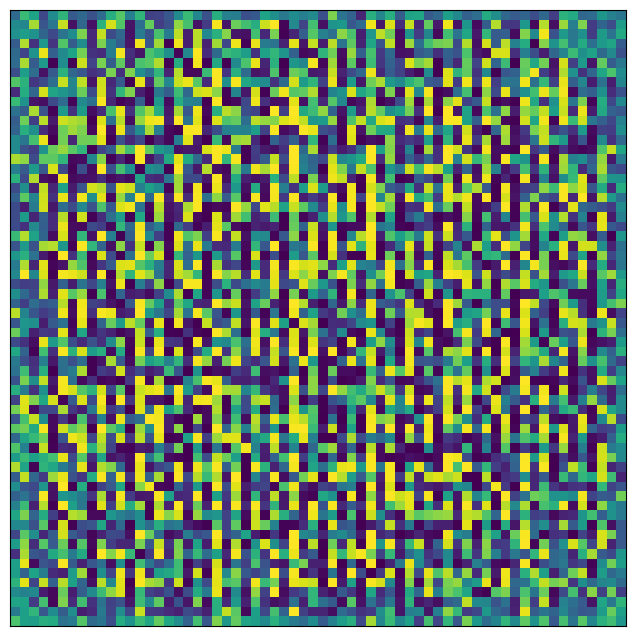

Saving generated-image-0000-87.png


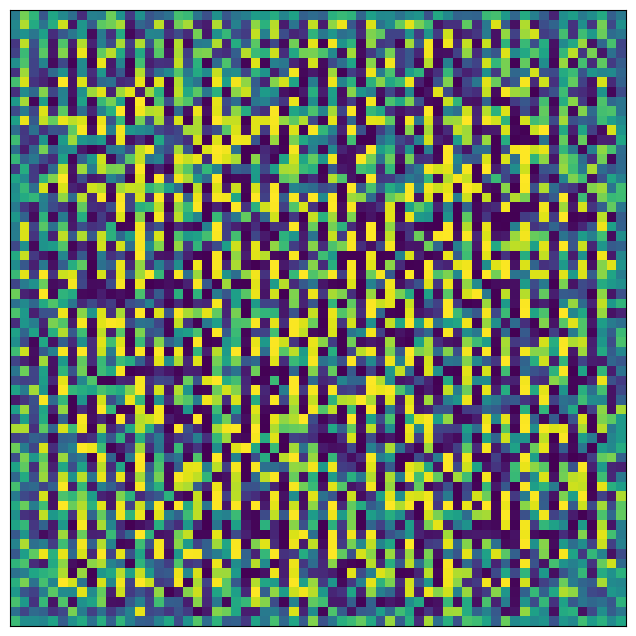

Saving generated-image-0000-88.png


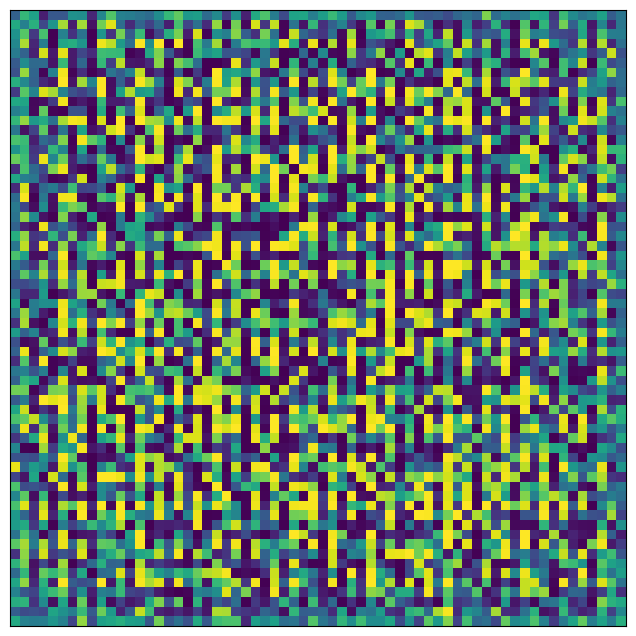

Saving generated-image-0000-89.png


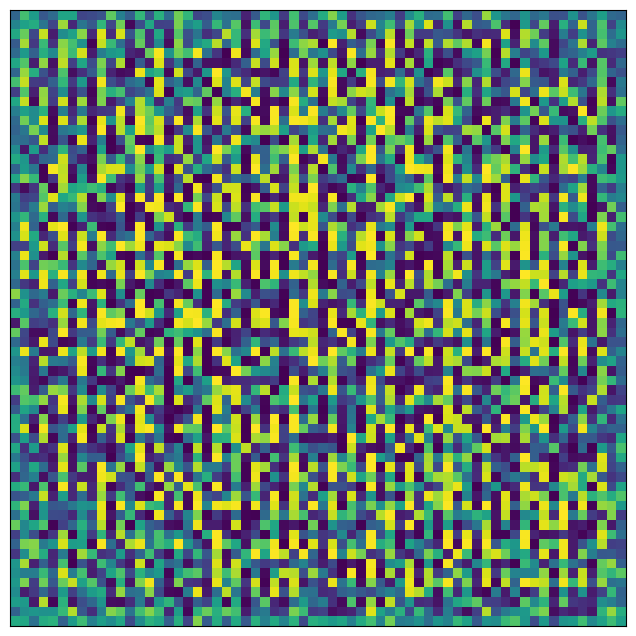

Saving generated-image-0000-90.png


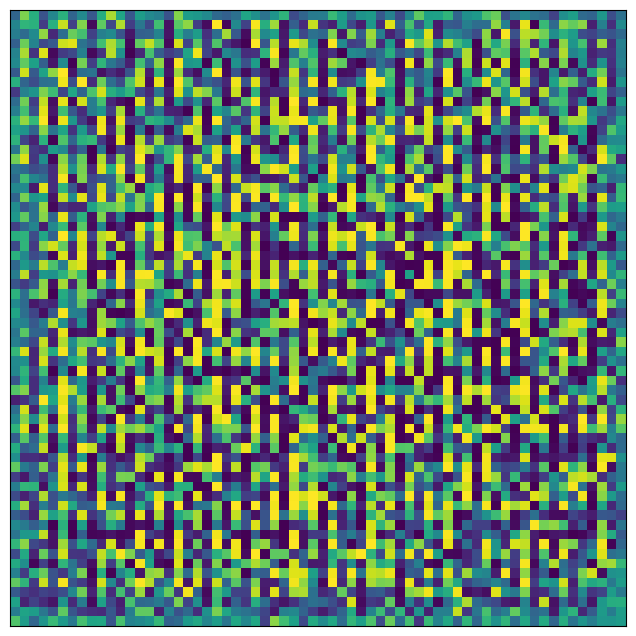

Saving generated-image-0000-91.png


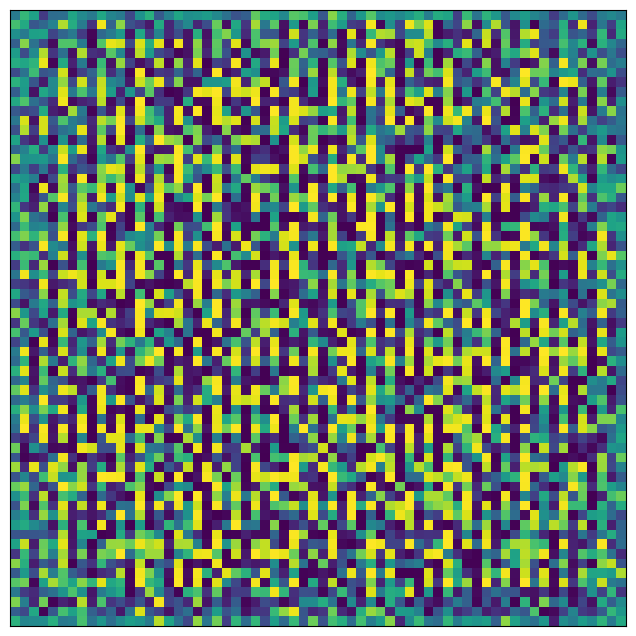

Saving generated-image-0000-92.png


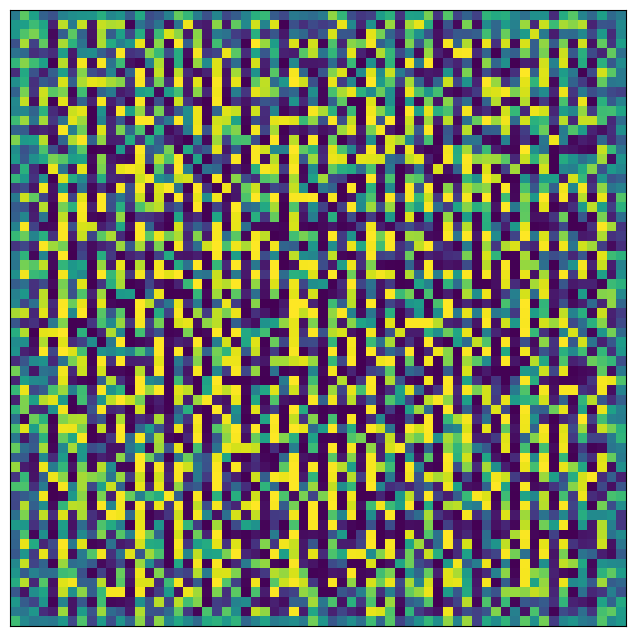

Saving generated-image-0000-93.png


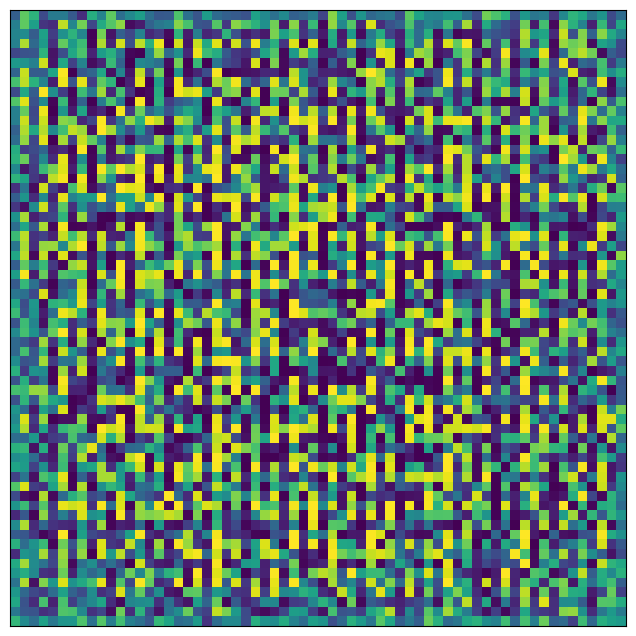

Saving generated-image-0000-94.png


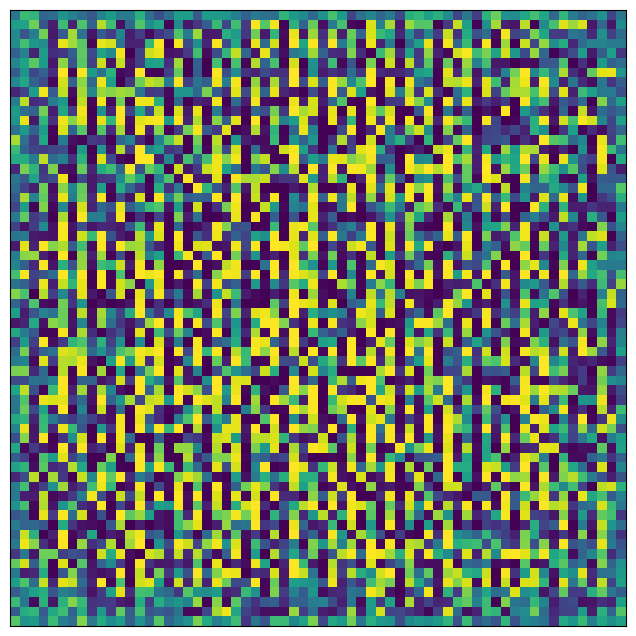

Saving generated-image-0000-95.png


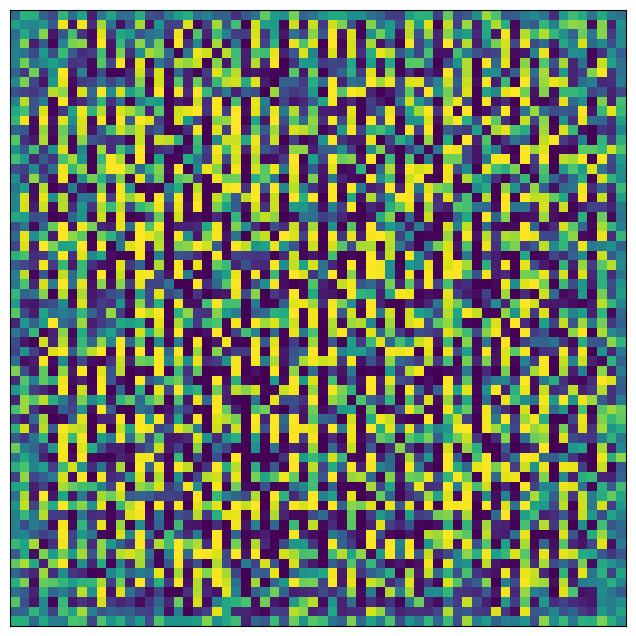

Saving generated-image-0000-96.png


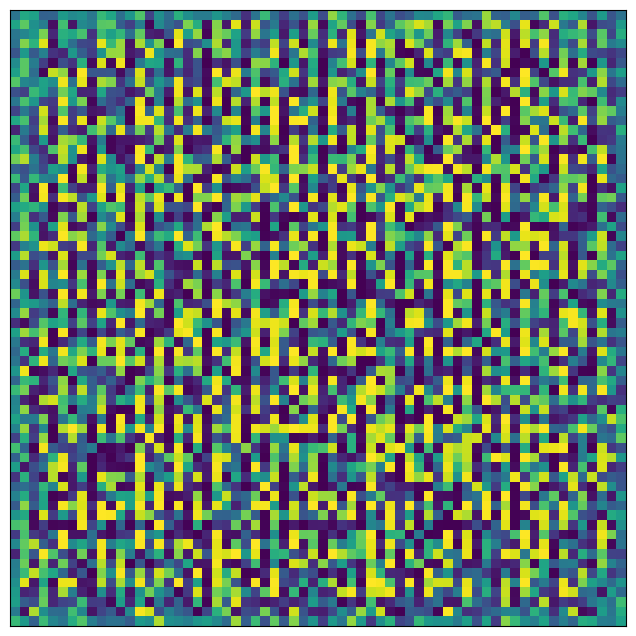

Saving generated-image-0000-97.png


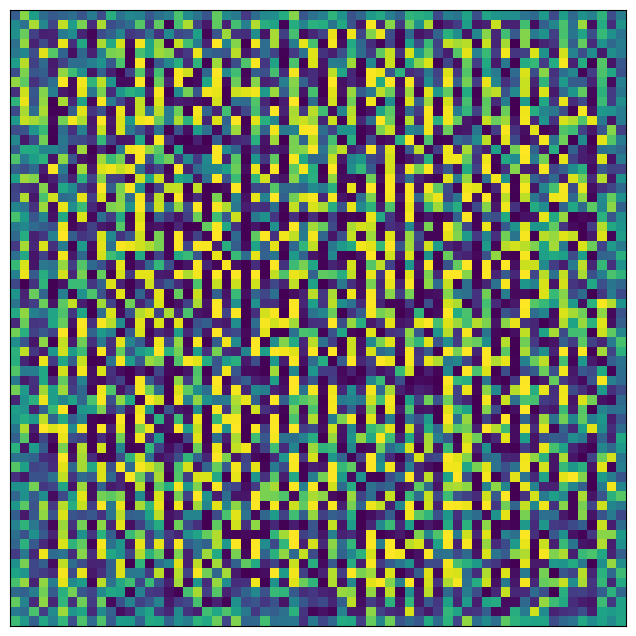

Saving generated-image-0000-98.png


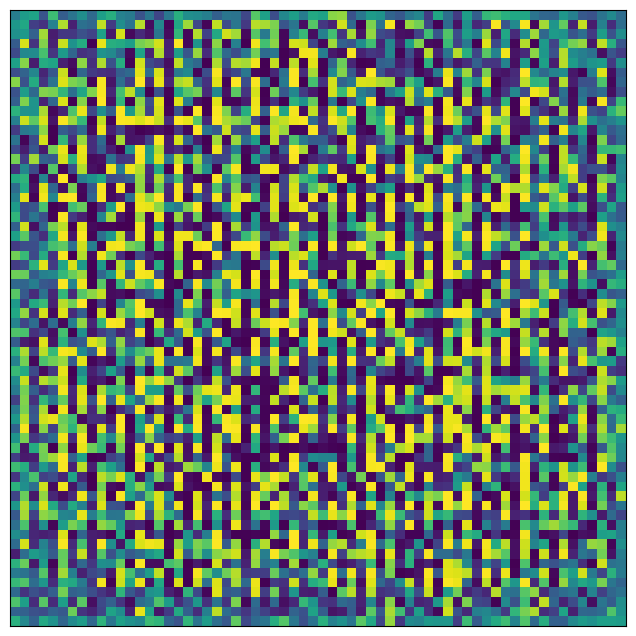

Saving generated-image-0000-99.png


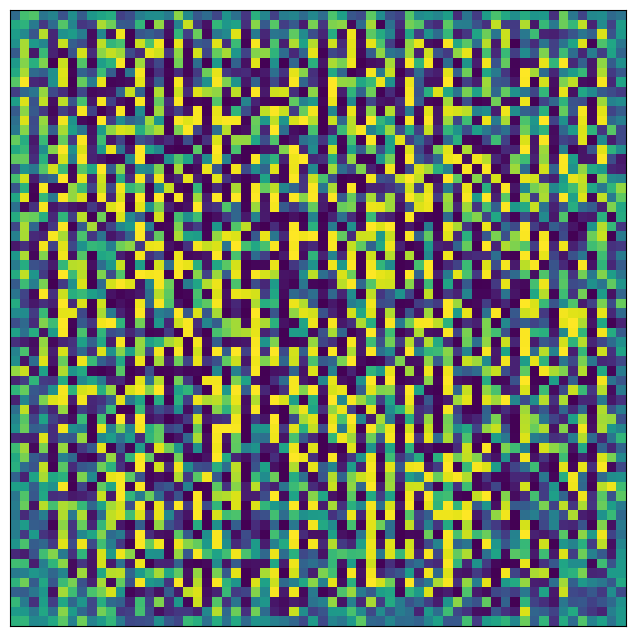

In [89]:
save_samples(0, fixed_latent)

In [90]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [91]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [92]:
lr = 0.0002
epochs = 100

In [93]:
history = fit(epochs, lr)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 8.3155, loss_d: 0.0477, real_score: 0.9771, fake_score: 0.0234
Saving generated-image-0001-00.png
Saving generated-image-0001-01.png
Saving generated-image-0001-02.png
Saving generated-image-0001-03.png
Saving generated-image-0001-04.png
Saving generated-image-0001-05.png
Saving generated-image-0001-06.png
Saving generated-image-0001-07.png
Saving generated-image-0001-08.png
Saving generated-image-0001-09.png
Saving generated-image-0001-10.png
Saving generated-image-0001-11.png
Saving generated-image-0001-12.png
Saving generated-image-0001-13.png
Saving generated-image-0001-14.png
Saving generated-image-0001-15.png
Saving generated-image-0001-16.png
Saving generated-image-0001-17.png
Saving generated-image-0001-18.png
Saving generated-image-0001-19.png
Saving generated-image-0001-20.png
Saving generated-image-0001-21.png
Saving generated-image-0001-22.png
Saving generated-image-0001-23.png
Saving generated-image-0001-24.png
Saving generated-image-0001-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.4231, loss_d: 0.0380, real_score: 0.9917, fake_score: 0.0289
Saving generated-image-0002-00.png
Saving generated-image-0002-01.png
Saving generated-image-0002-02.png
Saving generated-image-0002-03.png
Saving generated-image-0002-04.png
Saving generated-image-0002-05.png
Saving generated-image-0002-06.png
Saving generated-image-0002-07.png
Saving generated-image-0002-08.png
Saving generated-image-0002-09.png
Saving generated-image-0002-10.png
Saving generated-image-0002-11.png
Saving generated-image-0002-12.png
Saving generated-image-0002-13.png
Saving generated-image-0002-14.png
Saving generated-image-0002-15.png
Saving generated-image-0002-16.png
Saving generated-image-0002-17.png
Saving generated-image-0002-18.png
Saving generated-image-0002-19.png
Saving generated-image-0002-20.png
Saving generated-image-0002-21.png
Saving generated-image-0002-22.png
Saving generated-image-0002-23.png
Saving generated-image-0002-24.png
Saving generated-image-0002-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 11.1197, loss_d: 0.1093, real_score: 1.0000, fake_score: 0.1006
Saving generated-image-0003-00.png
Saving generated-image-0003-01.png
Saving generated-image-0003-02.png
Saving generated-image-0003-03.png
Saving generated-image-0003-04.png
Saving generated-image-0003-05.png
Saving generated-image-0003-06.png
Saving generated-image-0003-07.png
Saving generated-image-0003-08.png
Saving generated-image-0003-09.png
Saving generated-image-0003-10.png
Saving generated-image-0003-11.png
Saving generated-image-0003-12.png
Saving generated-image-0003-13.png
Saving generated-image-0003-14.png
Saving generated-image-0003-15.png
Saving generated-image-0003-16.png
Saving generated-image-0003-17.png
Saving generated-image-0003-18.png
Saving generated-image-0003-19.png
Saving generated-image-0003-20.png
Saving generated-image-0003-21.png
Saving generated-image-0003-22.png
Saving generated-image-0003-23.png
Saving generated-image-0003-24.png
Saving generated-image-0003-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 7.9644, loss_d: 0.0020, real_score: 0.9997, fake_score: 0.0017
Saving generated-image-0004-00.png
Saving generated-image-0004-01.png
Saving generated-image-0004-02.png
Saving generated-image-0004-03.png
Saving generated-image-0004-04.png
Saving generated-image-0004-05.png
Saving generated-image-0004-06.png
Saving generated-image-0004-07.png
Saving generated-image-0004-08.png
Saving generated-image-0004-09.png
Saving generated-image-0004-10.png
Saving generated-image-0004-11.png
Saving generated-image-0004-12.png
Saving generated-image-0004-13.png
Saving generated-image-0004-14.png
Saving generated-image-0004-15.png
Saving generated-image-0004-16.png
Saving generated-image-0004-17.png
Saving generated-image-0004-18.png
Saving generated-image-0004-19.png
Saving generated-image-0004-20.png
Saving generated-image-0004-21.png
Saving generated-image-0004-22.png
Saving generated-image-0004-23.png
Saving generated-image-0004-24.png
Saving generated-image-0004-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 16.1906, loss_d: 0.9864, real_score: 0.6640, fake_score: 0.0000
Saving generated-image-0005-00.png
Saving generated-image-0005-01.png
Saving generated-image-0005-02.png
Saving generated-image-0005-03.png
Saving generated-image-0005-04.png
Saving generated-image-0005-05.png
Saving generated-image-0005-06.png
Saving generated-image-0005-07.png
Saving generated-image-0005-08.png
Saving generated-image-0005-09.png
Saving generated-image-0005-10.png
Saving generated-image-0005-11.png
Saving generated-image-0005-12.png
Saving generated-image-0005-13.png
Saving generated-image-0005-14.png
Saving generated-image-0005-15.png
Saving generated-image-0005-16.png
Saving generated-image-0005-17.png
Saving generated-image-0005-18.png
Saving generated-image-0005-19.png
Saving generated-image-0005-20.png
Saving generated-image-0005-21.png
Saving generated-image-0005-22.png
Saving generated-image-0005-23.png
Saving generated-image-0005-24.png
Saving generated-image-0005-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.0863, loss_d: 0.0447, real_score: 0.9690, fake_score: 0.0121
Saving generated-image-0006-00.png
Saving generated-image-0006-01.png
Saving generated-image-0006-02.png
Saving generated-image-0006-03.png
Saving generated-image-0006-04.png
Saving generated-image-0006-05.png
Saving generated-image-0006-06.png
Saving generated-image-0006-07.png
Saving generated-image-0006-08.png
Saving generated-image-0006-09.png
Saving generated-image-0006-10.png
Saving generated-image-0006-11.png
Saving generated-image-0006-12.png
Saving generated-image-0006-13.png
Saving generated-image-0006-14.png
Saving generated-image-0006-15.png
Saving generated-image-0006-16.png
Saving generated-image-0006-17.png
Saving generated-image-0006-18.png
Saving generated-image-0006-19.png
Saving generated-image-0006-20.png
Saving generated-image-0006-21.png
Saving generated-image-0006-22.png
Saving generated-image-0006-23.png
Saving generated-image-0006-24.png
Saving generated-image-0006-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.3429, loss_d: 0.8679, real_score: 0.7947, fake_score: 0.4104
Saving generated-image-0007-00.png
Saving generated-image-0007-01.png
Saving generated-image-0007-02.png
Saving generated-image-0007-03.png
Saving generated-image-0007-04.png
Saving generated-image-0007-05.png
Saving generated-image-0007-06.png
Saving generated-image-0007-07.png
Saving generated-image-0007-08.png
Saving generated-image-0007-09.png
Saving generated-image-0007-10.png
Saving generated-image-0007-11.png
Saving generated-image-0007-12.png
Saving generated-image-0007-13.png
Saving generated-image-0007-14.png
Saving generated-image-0007-15.png
Saving generated-image-0007-16.png
Saving generated-image-0007-17.png
Saving generated-image-0007-18.png
Saving generated-image-0007-19.png
Saving generated-image-0007-20.png
Saving generated-image-0007-21.png
Saving generated-image-0007-22.png
Saving generated-image-0007-23.png
Saving generated-image-0007-24.png
Saving generated-image-0007-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 1.7750, loss_d: 0.1998, real_score: 0.9987, fake_score: 0.1703
Saving generated-image-0008-00.png
Saving generated-image-0008-01.png
Saving generated-image-0008-02.png
Saving generated-image-0008-03.png
Saving generated-image-0008-04.png
Saving generated-image-0008-05.png
Saving generated-image-0008-06.png
Saving generated-image-0008-07.png
Saving generated-image-0008-08.png
Saving generated-image-0008-09.png
Saving generated-image-0008-10.png
Saving generated-image-0008-11.png
Saving generated-image-0008-12.png
Saving generated-image-0008-13.png
Saving generated-image-0008-14.png
Saving generated-image-0008-15.png
Saving generated-image-0008-16.png
Saving generated-image-0008-17.png
Saving generated-image-0008-18.png
Saving generated-image-0008-19.png
Saving generated-image-0008-20.png
Saving generated-image-0008-21.png
Saving generated-image-0008-22.png
Saving generated-image-0008-23.png
Saving generated-image-0008-24.png
Saving generated-image-0008-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.4070, loss_d: 0.8045, real_score: 0.9595, fake_score: 0.3173
Saving generated-image-0009-00.png
Saving generated-image-0009-01.png
Saving generated-image-0009-02.png
Saving generated-image-0009-03.png
Saving generated-image-0009-04.png
Saving generated-image-0009-05.png
Saving generated-image-0009-06.png
Saving generated-image-0009-07.png
Saving generated-image-0009-08.png
Saving generated-image-0009-09.png
Saving generated-image-0009-10.png
Saving generated-image-0009-11.png
Saving generated-image-0009-12.png
Saving generated-image-0009-13.png
Saving generated-image-0009-14.png
Saving generated-image-0009-15.png
Saving generated-image-0009-16.png
Saving generated-image-0009-17.png
Saving generated-image-0009-18.png
Saving generated-image-0009-19.png
Saving generated-image-0009-20.png
Saving generated-image-0009-21.png
Saving generated-image-0009-22.png
Saving generated-image-0009-23.png
Saving generated-image-0009-24.png
Saving generated-image-0009-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.8313, loss_d: 1.2522, real_score: 0.5580, fake_score: 0.2715
Saving generated-image-0010-00.png
Saving generated-image-0010-01.png
Saving generated-image-0010-02.png
Saving generated-image-0010-03.png
Saving generated-image-0010-04.png
Saving generated-image-0010-05.png
Saving generated-image-0010-06.png
Saving generated-image-0010-07.png
Saving generated-image-0010-08.png
Saving generated-image-0010-09.png
Saving generated-image-0010-10.png
Saving generated-image-0010-11.png
Saving generated-image-0010-12.png
Saving generated-image-0010-13.png
Saving generated-image-0010-14.png
Saving generated-image-0010-15.png
Saving generated-image-0010-16.png
Saving generated-image-0010-17.png
Saving generated-image-0010-18.png
Saving generated-image-0010-19.png
Saving generated-image-0010-20.png
Saving generated-image-0010-21.png
Saving generated-image-0010-22.png
Saving generated-image-0010-23.png
Saving generated-image-0010-24.png
Saving generated-image-0010-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 2.2693, loss_d: 0.3491, real_score: 0.7320, fake_score: 0.0102
Saving generated-image-0011-00.png
Saving generated-image-0011-01.png
Saving generated-image-0011-02.png
Saving generated-image-0011-03.png
Saving generated-image-0011-04.png
Saving generated-image-0011-05.png
Saving generated-image-0011-06.png
Saving generated-image-0011-07.png
Saving generated-image-0011-08.png
Saving generated-image-0011-09.png
Saving generated-image-0011-10.png
Saving generated-image-0011-11.png
Saving generated-image-0011-12.png
Saving generated-image-0011-13.png
Saving generated-image-0011-14.png
Saving generated-image-0011-15.png
Saving generated-image-0011-16.png
Saving generated-image-0011-17.png
Saving generated-image-0011-18.png
Saving generated-image-0011-19.png
Saving generated-image-0011-20.png
Saving generated-image-0011-21.png
Saving generated-image-0011-22.png
Saving generated-image-0011-23.png
Saving generated-image-0011-24.png
Saving generated-image-0011-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 2.6044, loss_d: 0.5986, real_score: 0.9891, fake_score: 0.3620
Saving generated-image-0012-00.png
Saving generated-image-0012-01.png
Saving generated-image-0012-02.png
Saving generated-image-0012-03.png
Saving generated-image-0012-04.png
Saving generated-image-0012-05.png
Saving generated-image-0012-06.png
Saving generated-image-0012-07.png
Saving generated-image-0012-08.png
Saving generated-image-0012-09.png
Saving generated-image-0012-10.png
Saving generated-image-0012-11.png
Saving generated-image-0012-12.png
Saving generated-image-0012-13.png
Saving generated-image-0012-14.png
Saving generated-image-0012-15.png
Saving generated-image-0012-16.png
Saving generated-image-0012-17.png
Saving generated-image-0012-18.png
Saving generated-image-0012-19.png
Saving generated-image-0012-20.png
Saving generated-image-0012-21.png
Saving generated-image-0012-22.png
Saving generated-image-0012-23.png
Saving generated-image-0012-24.png
Saving generated-image-0012-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.0758, loss_d: 0.0542, real_score: 0.9718, fake_score: 0.0249
Saving generated-image-0013-00.png
Saving generated-image-0013-01.png
Saving generated-image-0013-02.png
Saving generated-image-0013-03.png
Saving generated-image-0013-04.png
Saving generated-image-0013-05.png
Saving generated-image-0013-06.png
Saving generated-image-0013-07.png
Saving generated-image-0013-08.png
Saving generated-image-0013-09.png
Saving generated-image-0013-10.png
Saving generated-image-0013-11.png
Saving generated-image-0013-12.png
Saving generated-image-0013-13.png
Saving generated-image-0013-14.png
Saving generated-image-0013-15.png
Saving generated-image-0013-16.png
Saving generated-image-0013-17.png
Saving generated-image-0013-18.png
Saving generated-image-0013-19.png
Saving generated-image-0013-20.png
Saving generated-image-0013-21.png
Saving generated-image-0013-22.png
Saving generated-image-0013-23.png
Saving generated-image-0013-24.png
Saving generated-image-0013-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 7.9307, loss_d: 0.0955, real_score: 0.9162, fake_score: 0.0015
Saving generated-image-0014-00.png
Saving generated-image-0014-01.png
Saving generated-image-0014-02.png
Saving generated-image-0014-03.png
Saving generated-image-0014-04.png
Saving generated-image-0014-05.png
Saving generated-image-0014-06.png
Saving generated-image-0014-07.png
Saving generated-image-0014-08.png
Saving generated-image-0014-09.png
Saving generated-image-0014-10.png
Saving generated-image-0014-11.png
Saving generated-image-0014-12.png
Saving generated-image-0014-13.png
Saving generated-image-0014-14.png
Saving generated-image-0014-15.png
Saving generated-image-0014-16.png
Saving generated-image-0014-17.png
Saving generated-image-0014-18.png
Saving generated-image-0014-19.png
Saving generated-image-0014-20.png
Saving generated-image-0014-21.png
Saving generated-image-0014-22.png
Saving generated-image-0014-23.png
Saving generated-image-0014-24.png
Saving generated-image-0014-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 5.1246, loss_d: 0.0629, real_score: 0.9652, fake_score: 0.0259
Saving generated-image-0015-00.png
Saving generated-image-0015-01.png
Saving generated-image-0015-02.png
Saving generated-image-0015-03.png
Saving generated-image-0015-04.png
Saving generated-image-0015-05.png
Saving generated-image-0015-06.png
Saving generated-image-0015-07.png
Saving generated-image-0015-08.png
Saving generated-image-0015-09.png
Saving generated-image-0015-10.png
Saving generated-image-0015-11.png
Saving generated-image-0015-12.png
Saving generated-image-0015-13.png
Saving generated-image-0015-14.png
Saving generated-image-0015-15.png
Saving generated-image-0015-16.png
Saving generated-image-0015-17.png
Saving generated-image-0015-18.png
Saving generated-image-0015-19.png
Saving generated-image-0015-20.png
Saving generated-image-0015-21.png
Saving generated-image-0015-22.png
Saving generated-image-0015-23.png
Saving generated-image-0015-24.png
Saving generated-image-0015-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 8.4125, loss_d: 0.0490, real_score: 0.9534, fake_score: 0.0009
Saving generated-image-0016-00.png
Saving generated-image-0016-01.png
Saving generated-image-0016-02.png
Saving generated-image-0016-03.png
Saving generated-image-0016-04.png
Saving generated-image-0016-05.png
Saving generated-image-0016-06.png
Saving generated-image-0016-07.png
Saving generated-image-0016-08.png
Saving generated-image-0016-09.png
Saving generated-image-0016-10.png
Saving generated-image-0016-11.png
Saving generated-image-0016-12.png
Saving generated-image-0016-13.png
Saving generated-image-0016-14.png
Saving generated-image-0016-15.png
Saving generated-image-0016-16.png
Saving generated-image-0016-17.png
Saving generated-image-0016-18.png
Saving generated-image-0016-19.png
Saving generated-image-0016-20.png
Saving generated-image-0016-21.png
Saving generated-image-0016-22.png
Saving generated-image-0016-23.png
Saving generated-image-0016-24.png
Saving generated-image-0016-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.3435, loss_d: 0.1043, real_score: 0.9639, fake_score: 0.0629
Saving generated-image-0017-00.png
Saving generated-image-0017-01.png
Saving generated-image-0017-02.png
Saving generated-image-0017-03.png
Saving generated-image-0017-04.png
Saving generated-image-0017-05.png
Saving generated-image-0017-06.png
Saving generated-image-0017-07.png
Saving generated-image-0017-08.png
Saving generated-image-0017-09.png
Saving generated-image-0017-10.png
Saving generated-image-0017-11.png
Saving generated-image-0017-12.png
Saving generated-image-0017-13.png
Saving generated-image-0017-14.png
Saving generated-image-0017-15.png
Saving generated-image-0017-16.png
Saving generated-image-0017-17.png
Saving generated-image-0017-18.png
Saving generated-image-0017-19.png
Saving generated-image-0017-20.png
Saving generated-image-0017-21.png
Saving generated-image-0017-22.png
Saving generated-image-0017-23.png
Saving generated-image-0017-24.png
Saving generated-image-0017-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 8.2348, loss_d: 0.0509, real_score: 0.9537, fake_score: 0.0031
Saving generated-image-0018-00.png
Saving generated-image-0018-01.png
Saving generated-image-0018-02.png
Saving generated-image-0018-03.png
Saving generated-image-0018-04.png
Saving generated-image-0018-05.png
Saving generated-image-0018-06.png
Saving generated-image-0018-07.png
Saving generated-image-0018-08.png
Saving generated-image-0018-09.png
Saving generated-image-0018-10.png
Saving generated-image-0018-11.png
Saving generated-image-0018-12.png
Saving generated-image-0018-13.png
Saving generated-image-0018-14.png
Saving generated-image-0018-15.png
Saving generated-image-0018-16.png
Saving generated-image-0018-17.png
Saving generated-image-0018-18.png
Saving generated-image-0018-19.png
Saving generated-image-0018-20.png
Saving generated-image-0018-21.png
Saving generated-image-0018-22.png
Saving generated-image-0018-23.png
Saving generated-image-0018-24.png
Saving generated-image-0018-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 5.7101, loss_d: 0.1027, real_score: 0.9188, fake_score: 0.0160
Saving generated-image-0019-00.png
Saving generated-image-0019-01.png
Saving generated-image-0019-02.png
Saving generated-image-0019-03.png
Saving generated-image-0019-04.png
Saving generated-image-0019-05.png
Saving generated-image-0019-06.png
Saving generated-image-0019-07.png
Saving generated-image-0019-08.png
Saving generated-image-0019-09.png
Saving generated-image-0019-10.png
Saving generated-image-0019-11.png
Saving generated-image-0019-12.png
Saving generated-image-0019-13.png
Saving generated-image-0019-14.png
Saving generated-image-0019-15.png
Saving generated-image-0019-16.png
Saving generated-image-0019-17.png
Saving generated-image-0019-18.png
Saving generated-image-0019-19.png
Saving generated-image-0019-20.png
Saving generated-image-0019-21.png
Saving generated-image-0019-22.png
Saving generated-image-0019-23.png
Saving generated-image-0019-24.png
Saving generated-image-0019-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 6.5340, loss_d: 1.3367, real_score: 0.7492, fake_score: 0.5828
Saving generated-image-0020-00.png
Saving generated-image-0020-01.png
Saving generated-image-0020-02.png
Saving generated-image-0020-03.png
Saving generated-image-0020-04.png
Saving generated-image-0020-05.png
Saving generated-image-0020-06.png
Saving generated-image-0020-07.png
Saving generated-image-0020-08.png
Saving generated-image-0020-09.png
Saving generated-image-0020-10.png
Saving generated-image-0020-11.png
Saving generated-image-0020-12.png
Saving generated-image-0020-13.png
Saving generated-image-0020-14.png
Saving generated-image-0020-15.png
Saving generated-image-0020-16.png
Saving generated-image-0020-17.png
Saving generated-image-0020-18.png
Saving generated-image-0020-19.png
Saving generated-image-0020-20.png
Saving generated-image-0020-21.png
Saving generated-image-0020-22.png
Saving generated-image-0020-23.png
Saving generated-image-0020-24.png
Saving generated-image-0020-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.7555, loss_d: 0.3410, real_score: 0.7629, fake_score: 0.0321
Saving generated-image-0021-00.png
Saving generated-image-0021-01.png
Saving generated-image-0021-02.png
Saving generated-image-0021-03.png
Saving generated-image-0021-04.png
Saving generated-image-0021-05.png
Saving generated-image-0021-06.png
Saving generated-image-0021-07.png
Saving generated-image-0021-08.png
Saving generated-image-0021-09.png
Saving generated-image-0021-10.png
Saving generated-image-0021-11.png
Saving generated-image-0021-12.png
Saving generated-image-0021-13.png
Saving generated-image-0021-14.png
Saving generated-image-0021-15.png
Saving generated-image-0021-16.png
Saving generated-image-0021-17.png
Saving generated-image-0021-18.png
Saving generated-image-0021-19.png
Saving generated-image-0021-20.png
Saving generated-image-0021-21.png
Saving generated-image-0021-22.png
Saving generated-image-0021-23.png
Saving generated-image-0021-24.png
Saving generated-image-0021-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.4839, loss_d: 0.0626, real_score: 0.9969, fake_score: 0.0552
Saving generated-image-0022-00.png
Saving generated-image-0022-01.png
Saving generated-image-0022-02.png
Saving generated-image-0022-03.png
Saving generated-image-0022-04.png
Saving generated-image-0022-05.png
Saving generated-image-0022-06.png
Saving generated-image-0022-07.png
Saving generated-image-0022-08.png
Saving generated-image-0022-09.png
Saving generated-image-0022-10.png
Saving generated-image-0022-11.png
Saving generated-image-0022-12.png
Saving generated-image-0022-13.png
Saving generated-image-0022-14.png
Saving generated-image-0022-15.png
Saving generated-image-0022-16.png
Saving generated-image-0022-17.png
Saving generated-image-0022-18.png
Saving generated-image-0022-19.png
Saving generated-image-0022-20.png
Saving generated-image-0022-21.png
Saving generated-image-0022-22.png
Saving generated-image-0022-23.png
Saving generated-image-0022-24.png
Saving generated-image-0022-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.7987, loss_d: 1.4512, real_score: 0.3545, fake_score: 0.0051
Saving generated-image-0023-00.png
Saving generated-image-0023-01.png
Saving generated-image-0023-02.png
Saving generated-image-0023-03.png
Saving generated-image-0023-04.png
Saving generated-image-0023-05.png
Saving generated-image-0023-06.png
Saving generated-image-0023-07.png
Saving generated-image-0023-08.png
Saving generated-image-0023-09.png
Saving generated-image-0023-10.png
Saving generated-image-0023-11.png
Saving generated-image-0023-12.png
Saving generated-image-0023-13.png
Saving generated-image-0023-14.png
Saving generated-image-0023-15.png
Saving generated-image-0023-16.png
Saving generated-image-0023-17.png
Saving generated-image-0023-18.png
Saving generated-image-0023-19.png
Saving generated-image-0023-20.png
Saving generated-image-0023-21.png
Saving generated-image-0023-22.png
Saving generated-image-0023-23.png
Saving generated-image-0023-24.png
Saving generated-image-0023-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 7.4647, loss_d: 0.5576, real_score: 0.9983, fake_score: 0.4139
Saving generated-image-0024-00.png
Saving generated-image-0024-01.png
Saving generated-image-0024-02.png
Saving generated-image-0024-03.png
Saving generated-image-0024-04.png
Saving generated-image-0024-05.png
Saving generated-image-0024-06.png
Saving generated-image-0024-07.png
Saving generated-image-0024-08.png
Saving generated-image-0024-09.png
Saving generated-image-0024-10.png
Saving generated-image-0024-11.png
Saving generated-image-0024-12.png
Saving generated-image-0024-13.png
Saving generated-image-0024-14.png
Saving generated-image-0024-15.png
Saving generated-image-0024-16.png
Saving generated-image-0024-17.png
Saving generated-image-0024-18.png
Saving generated-image-0024-19.png
Saving generated-image-0024-20.png
Saving generated-image-0024-21.png
Saving generated-image-0024-22.png
Saving generated-image-0024-23.png
Saving generated-image-0024-24.png
Saving generated-image-0024-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 9.2172, loss_d: 0.0016, real_score: 0.9989, fake_score: 0.0005
Saving generated-image-0025-00.png
Saving generated-image-0025-01.png
Saving generated-image-0025-02.png
Saving generated-image-0025-03.png
Saving generated-image-0025-04.png
Saving generated-image-0025-05.png
Saving generated-image-0025-06.png
Saving generated-image-0025-07.png
Saving generated-image-0025-08.png
Saving generated-image-0025-09.png
Saving generated-image-0025-10.png
Saving generated-image-0025-11.png
Saving generated-image-0025-12.png
Saving generated-image-0025-13.png
Saving generated-image-0025-14.png
Saving generated-image-0025-15.png
Saving generated-image-0025-16.png
Saving generated-image-0025-17.png
Saving generated-image-0025-18.png
Saving generated-image-0025-19.png
Saving generated-image-0025-20.png
Saving generated-image-0025-21.png
Saving generated-image-0025-22.png
Saving generated-image-0025-23.png
Saving generated-image-0025-24.png
Saving generated-image-0025-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.5556, loss_d: 1.2639, real_score: 0.6918, fake_score: 0.5049
Saving generated-image-0026-00.png
Saving generated-image-0026-01.png
Saving generated-image-0026-02.png
Saving generated-image-0026-03.png
Saving generated-image-0026-04.png
Saving generated-image-0026-05.png
Saving generated-image-0026-06.png
Saving generated-image-0026-07.png
Saving generated-image-0026-08.png
Saving generated-image-0026-09.png
Saving generated-image-0026-10.png
Saving generated-image-0026-11.png
Saving generated-image-0026-12.png
Saving generated-image-0026-13.png
Saving generated-image-0026-14.png
Saving generated-image-0026-15.png
Saving generated-image-0026-16.png
Saving generated-image-0026-17.png
Saving generated-image-0026-18.png
Saving generated-image-0026-19.png
Saving generated-image-0026-20.png
Saving generated-image-0026-21.png
Saving generated-image-0026-22.png
Saving generated-image-0026-23.png
Saving generated-image-0026-24.png
Saving generated-image-0026-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.5023, loss_d: 0.2348, real_score: 0.9780, fake_score: 0.1507
Saving generated-image-0027-00.png
Saving generated-image-0027-01.png
Saving generated-image-0027-02.png
Saving generated-image-0027-03.png
Saving generated-image-0027-04.png
Saving generated-image-0027-05.png
Saving generated-image-0027-06.png
Saving generated-image-0027-07.png
Saving generated-image-0027-08.png
Saving generated-image-0027-09.png
Saving generated-image-0027-10.png
Saving generated-image-0027-11.png
Saving generated-image-0027-12.png
Saving generated-image-0027-13.png
Saving generated-image-0027-14.png
Saving generated-image-0027-15.png
Saving generated-image-0027-16.png
Saving generated-image-0027-17.png
Saving generated-image-0027-18.png
Saving generated-image-0027-19.png
Saving generated-image-0027-20.png
Saving generated-image-0027-21.png
Saving generated-image-0027-22.png
Saving generated-image-0027-23.png
Saving generated-image-0027-24.png
Saving generated-image-0027-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 8.1525, loss_d: 1.7451, real_score: 0.2372, fake_score: 0.0001
Saving generated-image-0028-00.png
Saving generated-image-0028-01.png
Saving generated-image-0028-02.png
Saving generated-image-0028-03.png
Saving generated-image-0028-04.png
Saving generated-image-0028-05.png
Saving generated-image-0028-06.png
Saving generated-image-0028-07.png
Saving generated-image-0028-08.png
Saving generated-image-0028-09.png
Saving generated-image-0028-10.png
Saving generated-image-0028-11.png
Saving generated-image-0028-12.png
Saving generated-image-0028-13.png
Saving generated-image-0028-14.png
Saving generated-image-0028-15.png
Saving generated-image-0028-16.png
Saving generated-image-0028-17.png
Saving generated-image-0028-18.png
Saving generated-image-0028-19.png
Saving generated-image-0028-20.png
Saving generated-image-0028-21.png
Saving generated-image-0028-22.png
Saving generated-image-0028-23.png
Saving generated-image-0028-24.png
Saving generated-image-0028-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.3314, loss_d: 0.1114, real_score: 0.9449, fake_score: 0.0510
Saving generated-image-0029-00.png
Saving generated-image-0029-01.png
Saving generated-image-0029-02.png
Saving generated-image-0029-03.png
Saving generated-image-0029-04.png
Saving generated-image-0029-05.png
Saving generated-image-0029-06.png
Saving generated-image-0029-07.png
Saving generated-image-0029-08.png
Saving generated-image-0029-09.png
Saving generated-image-0029-10.png
Saving generated-image-0029-11.png
Saving generated-image-0029-12.png
Saving generated-image-0029-13.png
Saving generated-image-0029-14.png
Saving generated-image-0029-15.png
Saving generated-image-0029-16.png
Saving generated-image-0029-17.png
Saving generated-image-0029-18.png
Saving generated-image-0029-19.png
Saving generated-image-0029-20.png
Saving generated-image-0029-21.png
Saving generated-image-0029-22.png
Saving generated-image-0029-23.png
Saving generated-image-0029-24.png
Saving generated-image-0029-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 7.2463, loss_d: 0.1229, real_score: 0.8895, fake_score: 0.0029
Saving generated-image-0030-00.png
Saving generated-image-0030-01.png
Saving generated-image-0030-02.png
Saving generated-image-0030-03.png
Saving generated-image-0030-04.png
Saving generated-image-0030-05.png
Saving generated-image-0030-06.png
Saving generated-image-0030-07.png
Saving generated-image-0030-08.png
Saving generated-image-0030-09.png
Saving generated-image-0030-10.png
Saving generated-image-0030-11.png
Saving generated-image-0030-12.png
Saving generated-image-0030-13.png
Saving generated-image-0030-14.png
Saving generated-image-0030-15.png
Saving generated-image-0030-16.png
Saving generated-image-0030-17.png
Saving generated-image-0030-18.png
Saving generated-image-0030-19.png
Saving generated-image-0030-20.png
Saving generated-image-0030-21.png
Saving generated-image-0030-22.png
Saving generated-image-0030-23.png
Saving generated-image-0030-24.png
Saving generated-image-0030-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 6.4803, loss_d: 0.3565, real_score: 0.9889, fake_score: 0.2342
Saving generated-image-0031-00.png
Saving generated-image-0031-01.png
Saving generated-image-0031-02.png
Saving generated-image-0031-03.png
Saving generated-image-0031-04.png
Saving generated-image-0031-05.png
Saving generated-image-0031-06.png
Saving generated-image-0031-07.png
Saving generated-image-0031-08.png
Saving generated-image-0031-09.png
Saving generated-image-0031-10.png
Saving generated-image-0031-11.png
Saving generated-image-0031-12.png
Saving generated-image-0031-13.png
Saving generated-image-0031-14.png
Saving generated-image-0031-15.png
Saving generated-image-0031-16.png
Saving generated-image-0031-17.png
Saving generated-image-0031-18.png
Saving generated-image-0031-19.png
Saving generated-image-0031-20.png
Saving generated-image-0031-21.png
Saving generated-image-0031-22.png
Saving generated-image-0031-23.png
Saving generated-image-0031-24.png
Saving generated-image-0031-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.2597, loss_d: 0.1299, real_score: 0.9075, fake_score: 0.0310
Saving generated-image-0032-00.png
Saving generated-image-0032-01.png
Saving generated-image-0032-02.png
Saving generated-image-0032-03.png
Saving generated-image-0032-04.png
Saving generated-image-0032-05.png
Saving generated-image-0032-06.png
Saving generated-image-0032-07.png
Saving generated-image-0032-08.png
Saving generated-image-0032-09.png
Saving generated-image-0032-10.png
Saving generated-image-0032-11.png
Saving generated-image-0032-12.png
Saving generated-image-0032-13.png
Saving generated-image-0032-14.png
Saving generated-image-0032-15.png
Saving generated-image-0032-16.png
Saving generated-image-0032-17.png
Saving generated-image-0032-18.png
Saving generated-image-0032-19.png
Saving generated-image-0032-20.png
Saving generated-image-0032-21.png
Saving generated-image-0032-22.png
Saving generated-image-0032-23.png
Saving generated-image-0032-24.png
Saving generated-image-0032-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.4867, loss_d: 0.0444, real_score: 0.9798, fake_score: 0.0229
Saving generated-image-0033-00.png
Saving generated-image-0033-01.png
Saving generated-image-0033-02.png
Saving generated-image-0033-03.png
Saving generated-image-0033-04.png
Saving generated-image-0033-05.png
Saving generated-image-0033-06.png
Saving generated-image-0033-07.png
Saving generated-image-0033-08.png
Saving generated-image-0033-09.png
Saving generated-image-0033-10.png
Saving generated-image-0033-11.png
Saving generated-image-0033-12.png
Saving generated-image-0033-13.png
Saving generated-image-0033-14.png
Saving generated-image-0033-15.png
Saving generated-image-0033-16.png
Saving generated-image-0033-17.png
Saving generated-image-0033-18.png
Saving generated-image-0033-19.png
Saving generated-image-0033-20.png
Saving generated-image-0033-21.png
Saving generated-image-0033-22.png
Saving generated-image-0033-23.png
Saving generated-image-0033-24.png
Saving generated-image-0033-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.1249, loss_d: 0.1184, real_score: 0.8998, fake_score: 0.0122
Saving generated-image-0034-00.png
Saving generated-image-0034-01.png
Saving generated-image-0034-02.png
Saving generated-image-0034-03.png
Saving generated-image-0034-04.png
Saving generated-image-0034-05.png
Saving generated-image-0034-06.png
Saving generated-image-0034-07.png
Saving generated-image-0034-08.png
Saving generated-image-0034-09.png
Saving generated-image-0034-10.png
Saving generated-image-0034-11.png
Saving generated-image-0034-12.png
Saving generated-image-0034-13.png
Saving generated-image-0034-14.png
Saving generated-image-0034-15.png
Saving generated-image-0034-16.png
Saving generated-image-0034-17.png
Saving generated-image-0034-18.png
Saving generated-image-0034-19.png
Saving generated-image-0034-20.png
Saving generated-image-0034-21.png
Saving generated-image-0034-22.png
Saving generated-image-0034-23.png
Saving generated-image-0034-24.png
Saving generated-image-0034-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.8756, loss_d: 0.0118, real_score: 0.9918, fake_score: 0.0035
Saving generated-image-0035-00.png
Saving generated-image-0035-01.png
Saving generated-image-0035-02.png
Saving generated-image-0035-03.png
Saving generated-image-0035-04.png
Saving generated-image-0035-05.png
Saving generated-image-0035-06.png
Saving generated-image-0035-07.png
Saving generated-image-0035-08.png
Saving generated-image-0035-09.png
Saving generated-image-0035-10.png
Saving generated-image-0035-11.png
Saving generated-image-0035-12.png
Saving generated-image-0035-13.png
Saving generated-image-0035-14.png
Saving generated-image-0035-15.png
Saving generated-image-0035-16.png
Saving generated-image-0035-17.png
Saving generated-image-0035-18.png
Saving generated-image-0035-19.png
Saving generated-image-0035-20.png
Saving generated-image-0035-21.png
Saving generated-image-0035-22.png
Saving generated-image-0035-23.png
Saving generated-image-0035-24.png
Saving generated-image-0035-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.0724, loss_d: 0.0684, real_score: 0.9469, fake_score: 0.0116
Saving generated-image-0036-00.png
Saving generated-image-0036-01.png
Saving generated-image-0036-02.png
Saving generated-image-0036-03.png
Saving generated-image-0036-04.png
Saving generated-image-0036-05.png
Saving generated-image-0036-06.png
Saving generated-image-0036-07.png
Saving generated-image-0036-08.png
Saving generated-image-0036-09.png
Saving generated-image-0036-10.png
Saving generated-image-0036-11.png
Saving generated-image-0036-12.png
Saving generated-image-0036-13.png
Saving generated-image-0036-14.png
Saving generated-image-0036-15.png
Saving generated-image-0036-16.png
Saving generated-image-0036-17.png
Saving generated-image-0036-18.png
Saving generated-image-0036-19.png
Saving generated-image-0036-20.png
Saving generated-image-0036-21.png
Saving generated-image-0036-22.png
Saving generated-image-0036-23.png
Saving generated-image-0036-24.png
Saving generated-image-0036-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 7.3609, loss_d: 0.0196, real_score: 0.9945, fake_score: 0.0138
Saving generated-image-0037-00.png
Saving generated-image-0037-01.png
Saving generated-image-0037-02.png
Saving generated-image-0037-03.png
Saving generated-image-0037-04.png
Saving generated-image-0037-05.png
Saving generated-image-0037-06.png
Saving generated-image-0037-07.png
Saving generated-image-0037-08.png
Saving generated-image-0037-09.png
Saving generated-image-0037-10.png
Saving generated-image-0037-11.png
Saving generated-image-0037-12.png
Saving generated-image-0037-13.png
Saving generated-image-0037-14.png
Saving generated-image-0037-15.png
Saving generated-image-0037-16.png
Saving generated-image-0037-17.png
Saving generated-image-0037-18.png
Saving generated-image-0037-19.png
Saving generated-image-0037-20.png
Saving generated-image-0037-21.png
Saving generated-image-0037-22.png
Saving generated-image-0037-23.png
Saving generated-image-0037-24.png
Saving generated-image-0037-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.7867, loss_d: 0.1911, real_score: 0.9966, fake_score: 0.1447
Saving generated-image-0038-00.png
Saving generated-image-0038-01.png
Saving generated-image-0038-02.png
Saving generated-image-0038-03.png
Saving generated-image-0038-04.png
Saving generated-image-0038-05.png
Saving generated-image-0038-06.png
Saving generated-image-0038-07.png
Saving generated-image-0038-08.png
Saving generated-image-0038-09.png
Saving generated-image-0038-10.png
Saving generated-image-0038-11.png
Saving generated-image-0038-12.png
Saving generated-image-0038-13.png
Saving generated-image-0038-14.png
Saving generated-image-0038-15.png
Saving generated-image-0038-16.png
Saving generated-image-0038-17.png
Saving generated-image-0038-18.png
Saving generated-image-0038-19.png
Saving generated-image-0038-20.png
Saving generated-image-0038-21.png
Saving generated-image-0038-22.png
Saving generated-image-0038-23.png
Saving generated-image-0038-24.png
Saving generated-image-0038-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.3321, loss_d: 0.2284, real_score: 0.8412, fake_score: 0.0352
Saving generated-image-0039-00.png
Saving generated-image-0039-01.png
Saving generated-image-0039-02.png
Saving generated-image-0039-03.png
Saving generated-image-0039-04.png
Saving generated-image-0039-05.png
Saving generated-image-0039-06.png
Saving generated-image-0039-07.png
Saving generated-image-0039-08.png
Saving generated-image-0039-09.png
Saving generated-image-0039-10.png
Saving generated-image-0039-11.png
Saving generated-image-0039-12.png
Saving generated-image-0039-13.png
Saving generated-image-0039-14.png
Saving generated-image-0039-15.png
Saving generated-image-0039-16.png
Saving generated-image-0039-17.png
Saving generated-image-0039-18.png
Saving generated-image-0039-19.png
Saving generated-image-0039-20.png
Saving generated-image-0039-21.png
Saving generated-image-0039-22.png
Saving generated-image-0039-23.png
Saving generated-image-0039-24.png
Saving generated-image-0039-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 1.0122, loss_d: 0.8758, real_score: 0.5795, fake_score: 0.0619
Saving generated-image-0040-00.png
Saving generated-image-0040-01.png
Saving generated-image-0040-02.png
Saving generated-image-0040-03.png
Saving generated-image-0040-04.png
Saving generated-image-0040-05.png
Saving generated-image-0040-06.png
Saving generated-image-0040-07.png
Saving generated-image-0040-08.png
Saving generated-image-0040-09.png
Saving generated-image-0040-10.png
Saving generated-image-0040-11.png
Saving generated-image-0040-12.png
Saving generated-image-0040-13.png
Saving generated-image-0040-14.png
Saving generated-image-0040-15.png
Saving generated-image-0040-16.png
Saving generated-image-0040-17.png
Saving generated-image-0040-18.png
Saving generated-image-0040-19.png
Saving generated-image-0040-20.png
Saving generated-image-0040-21.png
Saving generated-image-0040-22.png
Saving generated-image-0040-23.png
Saving generated-image-0040-24.png
Saving generated-image-0040-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 5.6192, loss_d: 0.1198, real_score: 0.9997, fake_score: 0.1073
Saving generated-image-0041-00.png
Saving generated-image-0041-01.png
Saving generated-image-0041-02.png
Saving generated-image-0041-03.png
Saving generated-image-0041-04.png
Saving generated-image-0041-05.png
Saving generated-image-0041-06.png
Saving generated-image-0041-07.png
Saving generated-image-0041-08.png
Saving generated-image-0041-09.png
Saving generated-image-0041-10.png
Saving generated-image-0041-11.png
Saving generated-image-0041-12.png
Saving generated-image-0041-13.png
Saving generated-image-0041-14.png
Saving generated-image-0041-15.png
Saving generated-image-0041-16.png
Saving generated-image-0041-17.png
Saving generated-image-0041-18.png
Saving generated-image-0041-19.png
Saving generated-image-0041-20.png
Saving generated-image-0041-21.png
Saving generated-image-0041-22.png
Saving generated-image-0041-23.png
Saving generated-image-0041-24.png
Saving generated-image-0041-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 1.7514, loss_d: 1.1379, real_score: 0.4929, fake_score: 0.0654
Saving generated-image-0042-00.png
Saving generated-image-0042-01.png
Saving generated-image-0042-02.png
Saving generated-image-0042-03.png
Saving generated-image-0042-04.png
Saving generated-image-0042-05.png
Saving generated-image-0042-06.png
Saving generated-image-0042-07.png
Saving generated-image-0042-08.png
Saving generated-image-0042-09.png
Saving generated-image-0042-10.png
Saving generated-image-0042-11.png
Saving generated-image-0042-12.png
Saving generated-image-0042-13.png
Saving generated-image-0042-14.png
Saving generated-image-0042-15.png
Saving generated-image-0042-16.png
Saving generated-image-0042-17.png
Saving generated-image-0042-18.png
Saving generated-image-0042-19.png
Saving generated-image-0042-20.png
Saving generated-image-0042-21.png
Saving generated-image-0042-22.png
Saving generated-image-0042-23.png
Saving generated-image-0042-24.png
Saving generated-image-0042-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.4087, loss_d: 0.2595, real_score: 0.8055, fake_score: 0.0108
Saving generated-image-0043-00.png
Saving generated-image-0043-01.png
Saving generated-image-0043-02.png
Saving generated-image-0043-03.png
Saving generated-image-0043-04.png
Saving generated-image-0043-05.png
Saving generated-image-0043-06.png
Saving generated-image-0043-07.png
Saving generated-image-0043-08.png
Saving generated-image-0043-09.png
Saving generated-image-0043-10.png
Saving generated-image-0043-11.png
Saving generated-image-0043-12.png
Saving generated-image-0043-13.png
Saving generated-image-0043-14.png
Saving generated-image-0043-15.png
Saving generated-image-0043-16.png
Saving generated-image-0043-17.png
Saving generated-image-0043-18.png
Saving generated-image-0043-19.png
Saving generated-image-0043-20.png
Saving generated-image-0043-21.png
Saving generated-image-0043-22.png
Saving generated-image-0043-23.png
Saving generated-image-0043-24.png
Saving generated-image-0043-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 9.1174, loss_d: 0.0109, real_score: 0.9908, fake_score: 0.0016
Saving generated-image-0044-00.png
Saving generated-image-0044-01.png
Saving generated-image-0044-02.png
Saving generated-image-0044-03.png
Saving generated-image-0044-04.png
Saving generated-image-0044-05.png
Saving generated-image-0044-06.png
Saving generated-image-0044-07.png
Saving generated-image-0044-08.png
Saving generated-image-0044-09.png
Saving generated-image-0044-10.png
Saving generated-image-0044-11.png
Saving generated-image-0044-12.png
Saving generated-image-0044-13.png
Saving generated-image-0044-14.png
Saving generated-image-0044-15.png
Saving generated-image-0044-16.png
Saving generated-image-0044-17.png
Saving generated-image-0044-18.png
Saving generated-image-0044-19.png
Saving generated-image-0044-20.png
Saving generated-image-0044-21.png
Saving generated-image-0044-22.png
Saving generated-image-0044-23.png
Saving generated-image-0044-24.png
Saving generated-image-0044-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 5.8705, loss_d: 0.0234, real_score: 0.9781, fake_score: 0.0011
Saving generated-image-0045-00.png
Saving generated-image-0045-01.png
Saving generated-image-0045-02.png
Saving generated-image-0045-03.png
Saving generated-image-0045-04.png
Saving generated-image-0045-05.png
Saving generated-image-0045-06.png
Saving generated-image-0045-07.png
Saving generated-image-0045-08.png
Saving generated-image-0045-09.png
Saving generated-image-0045-10.png
Saving generated-image-0045-11.png
Saving generated-image-0045-12.png
Saving generated-image-0045-13.png
Saving generated-image-0045-14.png
Saving generated-image-0045-15.png
Saving generated-image-0045-16.png
Saving generated-image-0045-17.png
Saving generated-image-0045-18.png
Saving generated-image-0045-19.png
Saving generated-image-0045-20.png
Saving generated-image-0045-21.png
Saving generated-image-0045-22.png
Saving generated-image-0045-23.png
Saving generated-image-0045-24.png
Saving generated-image-0045-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 7.3331, loss_d: 0.3245, real_score: 0.7500, fake_score: 0.0137
Saving generated-image-0046-00.png
Saving generated-image-0046-01.png
Saving generated-image-0046-02.png
Saving generated-image-0046-03.png
Saving generated-image-0046-04.png
Saving generated-image-0046-05.png
Saving generated-image-0046-06.png
Saving generated-image-0046-07.png
Saving generated-image-0046-08.png
Saving generated-image-0046-09.png
Saving generated-image-0046-10.png
Saving generated-image-0046-11.png
Saving generated-image-0046-12.png
Saving generated-image-0046-13.png
Saving generated-image-0046-14.png
Saving generated-image-0046-15.png
Saving generated-image-0046-16.png
Saving generated-image-0046-17.png
Saving generated-image-0046-18.png
Saving generated-image-0046-19.png
Saving generated-image-0046-20.png
Saving generated-image-0046-21.png
Saving generated-image-0046-22.png
Saving generated-image-0046-23.png
Saving generated-image-0046-24.png
Saving generated-image-0046-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.5789, loss_d: 0.1635, real_score: 0.9997, fake_score: 0.1318
Saving generated-image-0047-00.png
Saving generated-image-0047-01.png
Saving generated-image-0047-02.png
Saving generated-image-0047-03.png
Saving generated-image-0047-04.png
Saving generated-image-0047-05.png
Saving generated-image-0047-06.png
Saving generated-image-0047-07.png
Saving generated-image-0047-08.png
Saving generated-image-0047-09.png
Saving generated-image-0047-10.png
Saving generated-image-0047-11.png
Saving generated-image-0047-12.png
Saving generated-image-0047-13.png
Saving generated-image-0047-14.png
Saving generated-image-0047-15.png
Saving generated-image-0047-16.png
Saving generated-image-0047-17.png
Saving generated-image-0047-18.png
Saving generated-image-0047-19.png
Saving generated-image-0047-20.png
Saving generated-image-0047-21.png
Saving generated-image-0047-22.png
Saving generated-image-0047-23.png
Saving generated-image-0047-24.png
Saving generated-image-0047-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 6.2255, loss_d: 0.2320, real_score: 0.9996, fake_score: 0.1846
Saving generated-image-0048-00.png
Saving generated-image-0048-01.png
Saving generated-image-0048-02.png
Saving generated-image-0048-03.png
Saving generated-image-0048-04.png
Saving generated-image-0048-05.png
Saving generated-image-0048-06.png
Saving generated-image-0048-07.png
Saving generated-image-0048-08.png
Saving generated-image-0048-09.png
Saving generated-image-0048-10.png
Saving generated-image-0048-11.png
Saving generated-image-0048-12.png
Saving generated-image-0048-13.png
Saving generated-image-0048-14.png
Saving generated-image-0048-15.png
Saving generated-image-0048-16.png
Saving generated-image-0048-17.png
Saving generated-image-0048-18.png
Saving generated-image-0048-19.png
Saving generated-image-0048-20.png
Saving generated-image-0048-21.png
Saving generated-image-0048-22.png
Saving generated-image-0048-23.png
Saving generated-image-0048-24.png
Saving generated-image-0048-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 7.3782, loss_d: 0.0567, real_score: 0.9821, fake_score: 0.0367
Saving generated-image-0049-00.png
Saving generated-image-0049-01.png
Saving generated-image-0049-02.png
Saving generated-image-0049-03.png
Saving generated-image-0049-04.png
Saving generated-image-0049-05.png
Saving generated-image-0049-06.png
Saving generated-image-0049-07.png
Saving generated-image-0049-08.png
Saving generated-image-0049-09.png
Saving generated-image-0049-10.png
Saving generated-image-0049-11.png
Saving generated-image-0049-12.png
Saving generated-image-0049-13.png
Saving generated-image-0049-14.png
Saving generated-image-0049-15.png
Saving generated-image-0049-16.png
Saving generated-image-0049-17.png
Saving generated-image-0049-18.png
Saving generated-image-0049-19.png
Saving generated-image-0049-20.png
Saving generated-image-0049-21.png
Saving generated-image-0049-22.png
Saving generated-image-0049-23.png
Saving generated-image-0049-24.png
Saving generated-image-0049-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 5.2632, loss_d: 0.0045, real_score: 0.9965, fake_score: 0.0010
Saving generated-image-0050-00.png
Saving generated-image-0050-01.png
Saving generated-image-0050-02.png
Saving generated-image-0050-03.png
Saving generated-image-0050-04.png
Saving generated-image-0050-05.png
Saving generated-image-0050-06.png
Saving generated-image-0050-07.png
Saving generated-image-0050-08.png
Saving generated-image-0050-09.png
Saving generated-image-0050-10.png
Saving generated-image-0050-11.png
Saving generated-image-0050-12.png
Saving generated-image-0050-13.png
Saving generated-image-0050-14.png
Saving generated-image-0050-15.png
Saving generated-image-0050-16.png
Saving generated-image-0050-17.png
Saving generated-image-0050-18.png
Saving generated-image-0050-19.png
Saving generated-image-0050-20.png
Saving generated-image-0050-21.png
Saving generated-image-0050-22.png
Saving generated-image-0050-23.png
Saving generated-image-0050-24.png
Saving generated-image-0050-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.8841, loss_d: 0.0379, real_score: 0.9990, fake_score: 0.0361
Saving generated-image-0051-00.png
Saving generated-image-0051-01.png
Saving generated-image-0051-02.png
Saving generated-image-0051-03.png
Saving generated-image-0051-04.png
Saving generated-image-0051-05.png
Saving generated-image-0051-06.png
Saving generated-image-0051-07.png
Saving generated-image-0051-08.png
Saving generated-image-0051-09.png
Saving generated-image-0051-10.png
Saving generated-image-0051-11.png
Saving generated-image-0051-12.png
Saving generated-image-0051-13.png
Saving generated-image-0051-14.png
Saving generated-image-0051-15.png
Saving generated-image-0051-16.png
Saving generated-image-0051-17.png
Saving generated-image-0051-18.png
Saving generated-image-0051-19.png
Saving generated-image-0051-20.png
Saving generated-image-0051-21.png
Saving generated-image-0051-22.png
Saving generated-image-0051-23.png
Saving generated-image-0051-24.png
Saving generated-image-0051-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 7.6921, loss_d: 0.0248, real_score: 0.9826, fake_score: 0.0068
Saving generated-image-0052-00.png
Saving generated-image-0052-01.png
Saving generated-image-0052-02.png
Saving generated-image-0052-03.png
Saving generated-image-0052-04.png
Saving generated-image-0052-05.png
Saving generated-image-0052-06.png
Saving generated-image-0052-07.png
Saving generated-image-0052-08.png
Saving generated-image-0052-09.png
Saving generated-image-0052-10.png
Saving generated-image-0052-11.png
Saving generated-image-0052-12.png
Saving generated-image-0052-13.png
Saving generated-image-0052-14.png
Saving generated-image-0052-15.png
Saving generated-image-0052-16.png
Saving generated-image-0052-17.png
Saving generated-image-0052-18.png
Saving generated-image-0052-19.png
Saving generated-image-0052-20.png
Saving generated-image-0052-21.png
Saving generated-image-0052-22.png
Saving generated-image-0052-23.png
Saving generated-image-0052-24.png
Saving generated-image-0052-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 6.7890, loss_d: 0.3133, real_score: 0.9856, fake_score: 0.2363
Saving generated-image-0053-00.png
Saving generated-image-0053-01.png
Saving generated-image-0053-02.png
Saving generated-image-0053-03.png
Saving generated-image-0053-04.png
Saving generated-image-0053-05.png
Saving generated-image-0053-06.png
Saving generated-image-0053-07.png
Saving generated-image-0053-08.png
Saving generated-image-0053-09.png
Saving generated-image-0053-10.png
Saving generated-image-0053-11.png
Saving generated-image-0053-12.png
Saving generated-image-0053-13.png
Saving generated-image-0053-14.png
Saving generated-image-0053-15.png
Saving generated-image-0053-16.png
Saving generated-image-0053-17.png
Saving generated-image-0053-18.png
Saving generated-image-0053-19.png
Saving generated-image-0053-20.png
Saving generated-image-0053-21.png
Saving generated-image-0053-22.png
Saving generated-image-0053-23.png
Saving generated-image-0053-24.png
Saving generated-image-0053-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 6.1790, loss_d: 0.1576, real_score: 0.9996, fake_score: 0.1349
Saving generated-image-0054-00.png
Saving generated-image-0054-01.png
Saving generated-image-0054-02.png
Saving generated-image-0054-03.png
Saving generated-image-0054-04.png
Saving generated-image-0054-05.png
Saving generated-image-0054-06.png
Saving generated-image-0054-07.png
Saving generated-image-0054-08.png
Saving generated-image-0054-09.png
Saving generated-image-0054-10.png
Saving generated-image-0054-11.png
Saving generated-image-0054-12.png
Saving generated-image-0054-13.png
Saving generated-image-0054-14.png
Saving generated-image-0054-15.png
Saving generated-image-0054-16.png
Saving generated-image-0054-17.png
Saving generated-image-0054-18.png
Saving generated-image-0054-19.png
Saving generated-image-0054-20.png
Saving generated-image-0054-21.png
Saving generated-image-0054-22.png
Saving generated-image-0054-23.png
Saving generated-image-0054-24.png
Saving generated-image-0054-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.5631, loss_d: 0.0637, real_score: 0.9469, fake_score: 0.0069
Saving generated-image-0055-00.png
Saving generated-image-0055-01.png
Saving generated-image-0055-02.png
Saving generated-image-0055-03.png
Saving generated-image-0055-04.png
Saving generated-image-0055-05.png
Saving generated-image-0055-06.png
Saving generated-image-0055-07.png
Saving generated-image-0055-08.png
Saving generated-image-0055-09.png
Saving generated-image-0055-10.png
Saving generated-image-0055-11.png
Saving generated-image-0055-12.png
Saving generated-image-0055-13.png
Saving generated-image-0055-14.png
Saving generated-image-0055-15.png
Saving generated-image-0055-16.png
Saving generated-image-0055-17.png
Saving generated-image-0055-18.png
Saving generated-image-0055-19.png
Saving generated-image-0055-20.png
Saving generated-image-0055-21.png
Saving generated-image-0055-22.png
Saving generated-image-0055-23.png
Saving generated-image-0055-24.png
Saving generated-image-0055-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 11.1835, loss_d: 0.0663, real_score: 0.9390, fake_score: 0.0001
Saving generated-image-0056-00.png
Saving generated-image-0056-01.png
Saving generated-image-0056-02.png
Saving generated-image-0056-03.png
Saving generated-image-0056-04.png
Saving generated-image-0056-05.png
Saving generated-image-0056-06.png
Saving generated-image-0056-07.png
Saving generated-image-0056-08.png
Saving generated-image-0056-09.png
Saving generated-image-0056-10.png
Saving generated-image-0056-11.png
Saving generated-image-0056-12.png
Saving generated-image-0056-13.png
Saving generated-image-0056-14.png
Saving generated-image-0056-15.png
Saving generated-image-0056-16.png
Saving generated-image-0056-17.png
Saving generated-image-0056-18.png
Saving generated-image-0056-19.png
Saving generated-image-0056-20.png
Saving generated-image-0056-21.png
Saving generated-image-0056-22.png
Saving generated-image-0056-23.png
Saving generated-image-0056-24.png
Saving generated-image-0056-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 6.2635, loss_d: 0.0594, real_score: 0.9842, fake_score: 0.0400
Saving generated-image-0057-00.png
Saving generated-image-0057-01.png
Saving generated-image-0057-02.png
Saving generated-image-0057-03.png
Saving generated-image-0057-04.png
Saving generated-image-0057-05.png
Saving generated-image-0057-06.png
Saving generated-image-0057-07.png
Saving generated-image-0057-08.png
Saving generated-image-0057-09.png
Saving generated-image-0057-10.png
Saving generated-image-0057-11.png
Saving generated-image-0057-12.png
Saving generated-image-0057-13.png
Saving generated-image-0057-14.png
Saving generated-image-0057-15.png
Saving generated-image-0057-16.png
Saving generated-image-0057-17.png
Saving generated-image-0057-18.png
Saving generated-image-0057-19.png
Saving generated-image-0057-20.png
Saving generated-image-0057-21.png
Saving generated-image-0057-22.png
Saving generated-image-0057-23.png
Saving generated-image-0057-24.png
Saving generated-image-0057-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.5145, loss_d: 0.0802, real_score: 0.9999, fake_score: 0.0704
Saving generated-image-0058-00.png
Saving generated-image-0058-01.png
Saving generated-image-0058-02.png
Saving generated-image-0058-03.png
Saving generated-image-0058-04.png
Saving generated-image-0058-05.png
Saving generated-image-0058-06.png
Saving generated-image-0058-07.png
Saving generated-image-0058-08.png
Saving generated-image-0058-09.png
Saving generated-image-0058-10.png
Saving generated-image-0058-11.png
Saving generated-image-0058-12.png
Saving generated-image-0058-13.png
Saving generated-image-0058-14.png
Saving generated-image-0058-15.png
Saving generated-image-0058-16.png
Saving generated-image-0058-17.png
Saving generated-image-0058-18.png
Saving generated-image-0058-19.png
Saving generated-image-0058-20.png
Saving generated-image-0058-21.png
Saving generated-image-0058-22.png
Saving generated-image-0058-23.png
Saving generated-image-0058-24.png
Saving generated-image-0058-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.4214, loss_d: 0.0504, real_score: 0.9790, fake_score: 0.0279
Saving generated-image-0059-00.png
Saving generated-image-0059-01.png
Saving generated-image-0059-02.png
Saving generated-image-0059-03.png
Saving generated-image-0059-04.png
Saving generated-image-0059-05.png
Saving generated-image-0059-06.png
Saving generated-image-0059-07.png
Saving generated-image-0059-08.png
Saving generated-image-0059-09.png
Saving generated-image-0059-10.png
Saving generated-image-0059-11.png
Saving generated-image-0059-12.png
Saving generated-image-0059-13.png
Saving generated-image-0059-14.png
Saving generated-image-0059-15.png
Saving generated-image-0059-16.png
Saving generated-image-0059-17.png
Saving generated-image-0059-18.png
Saving generated-image-0059-19.png
Saving generated-image-0059-20.png
Saving generated-image-0059-21.png
Saving generated-image-0059-22.png
Saving generated-image-0059-23.png
Saving generated-image-0059-24.png
Saving generated-image-0059-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 1.1104, loss_d: 0.0688, real_score: 0.9398, fake_score: 0.0057
Saving generated-image-0060-00.png
Saving generated-image-0060-01.png
Saving generated-image-0060-02.png
Saving generated-image-0060-03.png
Saving generated-image-0060-04.png
Saving generated-image-0060-05.png
Saving generated-image-0060-06.png
Saving generated-image-0060-07.png
Saving generated-image-0060-08.png
Saving generated-image-0060-09.png
Saving generated-image-0060-10.png
Saving generated-image-0060-11.png
Saving generated-image-0060-12.png
Saving generated-image-0060-13.png
Saving generated-image-0060-14.png
Saving generated-image-0060-15.png
Saving generated-image-0060-16.png
Saving generated-image-0060-17.png
Saving generated-image-0060-18.png
Saving generated-image-0060-19.png
Saving generated-image-0060-20.png
Saving generated-image-0060-21.png
Saving generated-image-0060-22.png
Saving generated-image-0060-23.png
Saving generated-image-0060-24.png
Saving generated-image-0060-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.9153, loss_d: 0.1135, real_score: 0.9956, fake_score: 0.0941
Saving generated-image-0061-00.png
Saving generated-image-0061-01.png
Saving generated-image-0061-02.png
Saving generated-image-0061-03.png
Saving generated-image-0061-04.png
Saving generated-image-0061-05.png
Saving generated-image-0061-06.png
Saving generated-image-0061-07.png
Saving generated-image-0061-08.png
Saving generated-image-0061-09.png
Saving generated-image-0061-10.png
Saving generated-image-0061-11.png
Saving generated-image-0061-12.png
Saving generated-image-0061-13.png
Saving generated-image-0061-14.png
Saving generated-image-0061-15.png
Saving generated-image-0061-16.png
Saving generated-image-0061-17.png
Saving generated-image-0061-18.png
Saving generated-image-0061-19.png
Saving generated-image-0061-20.png
Saving generated-image-0061-21.png
Saving generated-image-0061-22.png
Saving generated-image-0061-23.png
Saving generated-image-0061-24.png
Saving generated-image-0061-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 9.0492, loss_d: 0.2917, real_score: 0.9997, fake_score: 0.1775
Saving generated-image-0062-00.png
Saving generated-image-0062-01.png
Saving generated-image-0062-02.png
Saving generated-image-0062-03.png
Saving generated-image-0062-04.png
Saving generated-image-0062-05.png
Saving generated-image-0062-06.png
Saving generated-image-0062-07.png
Saving generated-image-0062-08.png
Saving generated-image-0062-09.png
Saving generated-image-0062-10.png
Saving generated-image-0062-11.png
Saving generated-image-0062-12.png
Saving generated-image-0062-13.png
Saving generated-image-0062-14.png
Saving generated-image-0062-15.png
Saving generated-image-0062-16.png
Saving generated-image-0062-17.png
Saving generated-image-0062-18.png
Saving generated-image-0062-19.png
Saving generated-image-0062-20.png
Saving generated-image-0062-21.png
Saving generated-image-0062-22.png
Saving generated-image-0062-23.png
Saving generated-image-0062-24.png
Saving generated-image-0062-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 10.3705, loss_d: 0.0062, real_score: 0.9941, fake_score: 0.0003
Saving generated-image-0063-00.png
Saving generated-image-0063-01.png
Saving generated-image-0063-02.png
Saving generated-image-0063-03.png
Saving generated-image-0063-04.png
Saving generated-image-0063-05.png
Saving generated-image-0063-06.png
Saving generated-image-0063-07.png
Saving generated-image-0063-08.png
Saving generated-image-0063-09.png
Saving generated-image-0063-10.png
Saving generated-image-0063-11.png
Saving generated-image-0063-12.png
Saving generated-image-0063-13.png
Saving generated-image-0063-14.png
Saving generated-image-0063-15.png
Saving generated-image-0063-16.png
Saving generated-image-0063-17.png
Saving generated-image-0063-18.png
Saving generated-image-0063-19.png
Saving generated-image-0063-20.png
Saving generated-image-0063-21.png
Saving generated-image-0063-22.png
Saving generated-image-0063-23.png
Saving generated-image-0063-24.png
Saving generated-image-0063-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 5.0040, loss_d: 0.0280, real_score: 0.9985, fake_score: 0.0260
Saving generated-image-0064-00.png
Saving generated-image-0064-01.png
Saving generated-image-0064-02.png
Saving generated-image-0064-03.png
Saving generated-image-0064-04.png
Saving generated-image-0064-05.png
Saving generated-image-0064-06.png
Saving generated-image-0064-07.png
Saving generated-image-0064-08.png
Saving generated-image-0064-09.png
Saving generated-image-0064-10.png
Saving generated-image-0064-11.png
Saving generated-image-0064-12.png
Saving generated-image-0064-13.png
Saving generated-image-0064-14.png
Saving generated-image-0064-15.png
Saving generated-image-0064-16.png
Saving generated-image-0064-17.png
Saving generated-image-0064-18.png
Saving generated-image-0064-19.png
Saving generated-image-0064-20.png
Saving generated-image-0064-21.png
Saving generated-image-0064-22.png
Saving generated-image-0064-23.png
Saving generated-image-0064-24.png
Saving generated-image-0064-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 9.7883, loss_d: 0.1223, real_score: 0.8949, fake_score: 0.0001
Saving generated-image-0065-00.png
Saving generated-image-0065-01.png
Saving generated-image-0065-02.png
Saving generated-image-0065-03.png
Saving generated-image-0065-04.png
Saving generated-image-0065-05.png
Saving generated-image-0065-06.png
Saving generated-image-0065-07.png
Saving generated-image-0065-08.png
Saving generated-image-0065-09.png
Saving generated-image-0065-10.png
Saving generated-image-0065-11.png
Saving generated-image-0065-12.png
Saving generated-image-0065-13.png
Saving generated-image-0065-14.png
Saving generated-image-0065-15.png
Saving generated-image-0065-16.png
Saving generated-image-0065-17.png
Saving generated-image-0065-18.png
Saving generated-image-0065-19.png
Saving generated-image-0065-20.png
Saving generated-image-0065-21.png
Saving generated-image-0065-22.png
Saving generated-image-0065-23.png
Saving generated-image-0065-24.png
Saving generated-image-0065-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 8.6845, loss_d: 0.1156, real_score: 0.9744, fake_score: 0.0755
Saving generated-image-0066-00.png
Saving generated-image-0066-01.png
Saving generated-image-0066-02.png
Saving generated-image-0066-03.png
Saving generated-image-0066-04.png
Saving generated-image-0066-05.png
Saving generated-image-0066-06.png
Saving generated-image-0066-07.png
Saving generated-image-0066-08.png
Saving generated-image-0066-09.png
Saving generated-image-0066-10.png
Saving generated-image-0066-11.png
Saving generated-image-0066-12.png
Saving generated-image-0066-13.png
Saving generated-image-0066-14.png
Saving generated-image-0066-15.png
Saving generated-image-0066-16.png
Saving generated-image-0066-17.png
Saving generated-image-0066-18.png
Saving generated-image-0066-19.png
Saving generated-image-0066-20.png
Saving generated-image-0066-21.png
Saving generated-image-0066-22.png
Saving generated-image-0066-23.png
Saving generated-image-0066-24.png
Saving generated-image-0066-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 7.7271, loss_d: 0.2584, real_score: 0.9448, fake_score: 0.1714
Saving generated-image-0067-00.png
Saving generated-image-0067-01.png
Saving generated-image-0067-02.png
Saving generated-image-0067-03.png
Saving generated-image-0067-04.png
Saving generated-image-0067-05.png
Saving generated-image-0067-06.png
Saving generated-image-0067-07.png
Saving generated-image-0067-08.png
Saving generated-image-0067-09.png
Saving generated-image-0067-10.png
Saving generated-image-0067-11.png
Saving generated-image-0067-12.png
Saving generated-image-0067-13.png
Saving generated-image-0067-14.png
Saving generated-image-0067-15.png
Saving generated-image-0067-16.png
Saving generated-image-0067-17.png
Saving generated-image-0067-18.png
Saving generated-image-0067-19.png
Saving generated-image-0067-20.png
Saving generated-image-0067-21.png
Saving generated-image-0067-22.png
Saving generated-image-0067-23.png
Saving generated-image-0067-24.png
Saving generated-image-0067-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.1781, loss_d: 0.0513, real_score: 0.9584, fake_score: 0.0080
Saving generated-image-0068-00.png
Saving generated-image-0068-01.png
Saving generated-image-0068-02.png
Saving generated-image-0068-03.png
Saving generated-image-0068-04.png
Saving generated-image-0068-05.png
Saving generated-image-0068-06.png
Saving generated-image-0068-07.png
Saving generated-image-0068-08.png
Saving generated-image-0068-09.png
Saving generated-image-0068-10.png
Saving generated-image-0068-11.png
Saving generated-image-0068-12.png
Saving generated-image-0068-13.png
Saving generated-image-0068-14.png
Saving generated-image-0068-15.png
Saving generated-image-0068-16.png
Saving generated-image-0068-17.png
Saving generated-image-0068-18.png
Saving generated-image-0068-19.png
Saving generated-image-0068-20.png
Saving generated-image-0068-21.png
Saving generated-image-0068-22.png
Saving generated-image-0068-23.png
Saving generated-image-0068-24.png
Saving generated-image-0068-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 6.7687, loss_d: 0.7632, real_score: 0.9995, fake_score: 0.3426
Saving generated-image-0069-00.png
Saving generated-image-0069-01.png
Saving generated-image-0069-02.png
Saving generated-image-0069-03.png
Saving generated-image-0069-04.png
Saving generated-image-0069-05.png
Saving generated-image-0069-06.png
Saving generated-image-0069-07.png
Saving generated-image-0069-08.png
Saving generated-image-0069-09.png
Saving generated-image-0069-10.png
Saving generated-image-0069-11.png
Saving generated-image-0069-12.png
Saving generated-image-0069-13.png
Saving generated-image-0069-14.png
Saving generated-image-0069-15.png
Saving generated-image-0069-16.png
Saving generated-image-0069-17.png
Saving generated-image-0069-18.png
Saving generated-image-0069-19.png
Saving generated-image-0069-20.png
Saving generated-image-0069-21.png
Saving generated-image-0069-22.png
Saving generated-image-0069-23.png
Saving generated-image-0069-24.png
Saving generated-image-0069-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 7.4140, loss_d: 0.2164, real_score: 0.8073, fake_score: 0.0000
Saving generated-image-0070-00.png
Saving generated-image-0070-01.png
Saving generated-image-0070-02.png
Saving generated-image-0070-03.png
Saving generated-image-0070-04.png
Saving generated-image-0070-05.png
Saving generated-image-0070-06.png
Saving generated-image-0070-07.png
Saving generated-image-0070-08.png
Saving generated-image-0070-09.png
Saving generated-image-0070-10.png
Saving generated-image-0070-11.png
Saving generated-image-0070-12.png
Saving generated-image-0070-13.png
Saving generated-image-0070-14.png
Saving generated-image-0070-15.png
Saving generated-image-0070-16.png
Saving generated-image-0070-17.png
Saving generated-image-0070-18.png
Saving generated-image-0070-19.png
Saving generated-image-0070-20.png
Saving generated-image-0070-21.png
Saving generated-image-0070-22.png
Saving generated-image-0070-23.png
Saving generated-image-0070-24.png
Saving generated-image-0070-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 6.3300, loss_d: 0.1000, real_score: 0.9600, fake_score: 0.0544
Saving generated-image-0071-00.png
Saving generated-image-0071-01.png
Saving generated-image-0071-02.png
Saving generated-image-0071-03.png
Saving generated-image-0071-04.png
Saving generated-image-0071-05.png
Saving generated-image-0071-06.png
Saving generated-image-0071-07.png
Saving generated-image-0071-08.png
Saving generated-image-0071-09.png
Saving generated-image-0071-10.png
Saving generated-image-0071-11.png
Saving generated-image-0071-12.png
Saving generated-image-0071-13.png
Saving generated-image-0071-14.png
Saving generated-image-0071-15.png
Saving generated-image-0071-16.png
Saving generated-image-0071-17.png
Saving generated-image-0071-18.png
Saving generated-image-0071-19.png
Saving generated-image-0071-20.png
Saving generated-image-0071-21.png
Saving generated-image-0071-22.png
Saving generated-image-0071-23.png
Saving generated-image-0071-24.png
Saving generated-image-0071-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 5.4171, loss_d: 0.2870, real_score: 0.9579, fake_score: 0.2060
Saving generated-image-0072-00.png
Saving generated-image-0072-01.png
Saving generated-image-0072-02.png
Saving generated-image-0072-03.png
Saving generated-image-0072-04.png
Saving generated-image-0072-05.png
Saving generated-image-0072-06.png
Saving generated-image-0072-07.png
Saving generated-image-0072-08.png
Saving generated-image-0072-09.png
Saving generated-image-0072-10.png
Saving generated-image-0072-11.png
Saving generated-image-0072-12.png
Saving generated-image-0072-13.png
Saving generated-image-0072-14.png
Saving generated-image-0072-15.png
Saving generated-image-0072-16.png
Saving generated-image-0072-17.png
Saving generated-image-0072-18.png
Saving generated-image-0072-19.png
Saving generated-image-0072-20.png
Saving generated-image-0072-21.png
Saving generated-image-0072-22.png
Saving generated-image-0072-23.png
Saving generated-image-0072-24.png
Saving generated-image-0072-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 6.8252, loss_d: 0.1006, real_score: 0.9146, fake_score: 0.0033
Saving generated-image-0073-00.png
Saving generated-image-0073-01.png
Saving generated-image-0073-02.png
Saving generated-image-0073-03.png
Saving generated-image-0073-04.png
Saving generated-image-0073-05.png
Saving generated-image-0073-06.png
Saving generated-image-0073-07.png
Saving generated-image-0073-08.png
Saving generated-image-0073-09.png
Saving generated-image-0073-10.png
Saving generated-image-0073-11.png
Saving generated-image-0073-12.png
Saving generated-image-0073-13.png
Saving generated-image-0073-14.png
Saving generated-image-0073-15.png
Saving generated-image-0073-16.png
Saving generated-image-0073-17.png
Saving generated-image-0073-18.png
Saving generated-image-0073-19.png
Saving generated-image-0073-20.png
Saving generated-image-0073-21.png
Saving generated-image-0073-22.png
Saving generated-image-0073-23.png
Saving generated-image-0073-24.png
Saving generated-image-0073-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.9527, loss_d: 0.0355, real_score: 0.9928, fake_score: 0.0277
Saving generated-image-0074-00.png
Saving generated-image-0074-01.png
Saving generated-image-0074-02.png
Saving generated-image-0074-03.png
Saving generated-image-0074-04.png
Saving generated-image-0074-05.png
Saving generated-image-0074-06.png
Saving generated-image-0074-07.png
Saving generated-image-0074-08.png
Saving generated-image-0074-09.png
Saving generated-image-0074-10.png
Saving generated-image-0074-11.png
Saving generated-image-0074-12.png
Saving generated-image-0074-13.png
Saving generated-image-0074-14.png
Saving generated-image-0074-15.png
Saving generated-image-0074-16.png
Saving generated-image-0074-17.png
Saving generated-image-0074-18.png
Saving generated-image-0074-19.png
Saving generated-image-0074-20.png
Saving generated-image-0074-21.png
Saving generated-image-0074-22.png
Saving generated-image-0074-23.png
Saving generated-image-0074-24.png
Saving generated-image-0074-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 9.0607, loss_d: 0.0071, real_score: 0.9932, fake_score: 0.0002
Saving generated-image-0075-00.png
Saving generated-image-0075-01.png
Saving generated-image-0075-02.png
Saving generated-image-0075-03.png
Saving generated-image-0075-04.png
Saving generated-image-0075-05.png
Saving generated-image-0075-06.png
Saving generated-image-0075-07.png
Saving generated-image-0075-08.png
Saving generated-image-0075-09.png
Saving generated-image-0075-10.png
Saving generated-image-0075-11.png
Saving generated-image-0075-12.png
Saving generated-image-0075-13.png
Saving generated-image-0075-14.png
Saving generated-image-0075-15.png
Saving generated-image-0075-16.png
Saving generated-image-0075-17.png
Saving generated-image-0075-18.png
Saving generated-image-0075-19.png
Saving generated-image-0075-20.png
Saving generated-image-0075-21.png
Saving generated-image-0075-22.png
Saving generated-image-0075-23.png
Saving generated-image-0075-24.png
Saving generated-image-0075-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.0255, loss_d: 0.0220, real_score: 0.9982, fake_score: 0.0199
Saving generated-image-0076-00.png
Saving generated-image-0076-01.png
Saving generated-image-0076-02.png
Saving generated-image-0076-03.png
Saving generated-image-0076-04.png
Saving generated-image-0076-05.png
Saving generated-image-0076-06.png
Saving generated-image-0076-07.png
Saving generated-image-0076-08.png
Saving generated-image-0076-09.png
Saving generated-image-0076-10.png
Saving generated-image-0076-11.png
Saving generated-image-0076-12.png
Saving generated-image-0076-13.png
Saving generated-image-0076-14.png
Saving generated-image-0076-15.png
Saving generated-image-0076-16.png
Saving generated-image-0076-17.png
Saving generated-image-0076-18.png
Saving generated-image-0076-19.png
Saving generated-image-0076-20.png
Saving generated-image-0076-21.png
Saving generated-image-0076-22.png
Saving generated-image-0076-23.png
Saving generated-image-0076-24.png
Saving generated-image-0076-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.8956, loss_d: 0.0954, real_score: 0.9998, fake_score: 0.0842
Saving generated-image-0077-00.png
Saving generated-image-0077-01.png
Saving generated-image-0077-02.png
Saving generated-image-0077-03.png
Saving generated-image-0077-04.png
Saving generated-image-0077-05.png
Saving generated-image-0077-06.png
Saving generated-image-0077-07.png
Saving generated-image-0077-08.png
Saving generated-image-0077-09.png
Saving generated-image-0077-10.png
Saving generated-image-0077-11.png
Saving generated-image-0077-12.png
Saving generated-image-0077-13.png
Saving generated-image-0077-14.png
Saving generated-image-0077-15.png
Saving generated-image-0077-16.png
Saving generated-image-0077-17.png
Saving generated-image-0077-18.png
Saving generated-image-0077-19.png
Saving generated-image-0077-20.png
Saving generated-image-0077-21.png
Saving generated-image-0077-22.png
Saving generated-image-0077-23.png
Saving generated-image-0077-24.png
Saving generated-image-0077-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 9.1979, loss_d: 0.0425, real_score: 0.9614, fake_score: 0.0025
Saving generated-image-0078-00.png
Saving generated-image-0078-01.png
Saving generated-image-0078-02.png
Saving generated-image-0078-03.png
Saving generated-image-0078-04.png
Saving generated-image-0078-05.png
Saving generated-image-0078-06.png
Saving generated-image-0078-07.png
Saving generated-image-0078-08.png
Saving generated-image-0078-09.png
Saving generated-image-0078-10.png
Saving generated-image-0078-11.png
Saving generated-image-0078-12.png
Saving generated-image-0078-13.png
Saving generated-image-0078-14.png
Saving generated-image-0078-15.png
Saving generated-image-0078-16.png
Saving generated-image-0078-17.png
Saving generated-image-0078-18.png
Saving generated-image-0078-19.png
Saving generated-image-0078-20.png
Saving generated-image-0078-21.png
Saving generated-image-0078-22.png
Saving generated-image-0078-23.png
Saving generated-image-0078-24.png
Saving generated-image-0078-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 7.5466, loss_d: 0.0094, real_score: 0.9937, fake_score: 0.0030
Saving generated-image-0079-00.png
Saving generated-image-0079-01.png
Saving generated-image-0079-02.png
Saving generated-image-0079-03.png
Saving generated-image-0079-04.png
Saving generated-image-0079-05.png
Saving generated-image-0079-06.png
Saving generated-image-0079-07.png
Saving generated-image-0079-08.png
Saving generated-image-0079-09.png
Saving generated-image-0079-10.png
Saving generated-image-0079-11.png
Saving generated-image-0079-12.png
Saving generated-image-0079-13.png
Saving generated-image-0079-14.png
Saving generated-image-0079-15.png
Saving generated-image-0079-16.png
Saving generated-image-0079-17.png
Saving generated-image-0079-18.png
Saving generated-image-0079-19.png
Saving generated-image-0079-20.png
Saving generated-image-0079-21.png
Saving generated-image-0079-22.png
Saving generated-image-0079-23.png
Saving generated-image-0079-24.png
Saving generated-image-0079-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 4.5041, loss_d: 0.0191, real_score: 0.9890, fake_score: 0.0080
Saving generated-image-0080-00.png
Saving generated-image-0080-01.png
Saving generated-image-0080-02.png
Saving generated-image-0080-03.png
Saving generated-image-0080-04.png
Saving generated-image-0080-05.png
Saving generated-image-0080-06.png
Saving generated-image-0080-07.png
Saving generated-image-0080-08.png
Saving generated-image-0080-09.png
Saving generated-image-0080-10.png
Saving generated-image-0080-11.png
Saving generated-image-0080-12.png
Saving generated-image-0080-13.png
Saving generated-image-0080-14.png
Saving generated-image-0080-15.png
Saving generated-image-0080-16.png
Saving generated-image-0080-17.png
Saving generated-image-0080-18.png
Saving generated-image-0080-19.png
Saving generated-image-0080-20.png
Saving generated-image-0080-21.png
Saving generated-image-0080-22.png
Saving generated-image-0080-23.png
Saving generated-image-0080-24.png
Saving generated-image-0080-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.9362, loss_d: 0.0205, real_score: 0.9998, fake_score: 0.0200
Saving generated-image-0081-00.png
Saving generated-image-0081-01.png
Saving generated-image-0081-02.png
Saving generated-image-0081-03.png
Saving generated-image-0081-04.png
Saving generated-image-0081-05.png
Saving generated-image-0081-06.png
Saving generated-image-0081-07.png
Saving generated-image-0081-08.png
Saving generated-image-0081-09.png
Saving generated-image-0081-10.png
Saving generated-image-0081-11.png
Saving generated-image-0081-12.png
Saving generated-image-0081-13.png
Saving generated-image-0081-14.png
Saving generated-image-0081-15.png
Saving generated-image-0081-16.png
Saving generated-image-0081-17.png
Saving generated-image-0081-18.png
Saving generated-image-0081-19.png
Saving generated-image-0081-20.png
Saving generated-image-0081-21.png
Saving generated-image-0081-22.png
Saving generated-image-0081-23.png
Saving generated-image-0081-24.png
Saving generated-image-0081-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 9.9011, loss_d: 0.0863, real_score: 0.9990, fake_score: 0.0770
Saving generated-image-0082-00.png
Saving generated-image-0082-01.png
Saving generated-image-0082-02.png
Saving generated-image-0082-03.png
Saving generated-image-0082-04.png
Saving generated-image-0082-05.png
Saving generated-image-0082-06.png
Saving generated-image-0082-07.png
Saving generated-image-0082-08.png
Saving generated-image-0082-09.png
Saving generated-image-0082-10.png
Saving generated-image-0082-11.png
Saving generated-image-0082-12.png
Saving generated-image-0082-13.png
Saving generated-image-0082-14.png
Saving generated-image-0082-15.png
Saving generated-image-0082-16.png
Saving generated-image-0082-17.png
Saving generated-image-0082-18.png
Saving generated-image-0082-19.png
Saving generated-image-0082-20.png
Saving generated-image-0082-21.png
Saving generated-image-0082-22.png
Saving generated-image-0082-23.png
Saving generated-image-0082-24.png
Saving generated-image-0082-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 9.5294, loss_d: 0.0039, real_score: 0.9989, fake_score: 0.0028
Saving generated-image-0083-00.png
Saving generated-image-0083-01.png
Saving generated-image-0083-02.png
Saving generated-image-0083-03.png
Saving generated-image-0083-04.png
Saving generated-image-0083-05.png
Saving generated-image-0083-06.png
Saving generated-image-0083-07.png
Saving generated-image-0083-08.png
Saving generated-image-0083-09.png
Saving generated-image-0083-10.png
Saving generated-image-0083-11.png
Saving generated-image-0083-12.png
Saving generated-image-0083-13.png
Saving generated-image-0083-14.png
Saving generated-image-0083-15.png
Saving generated-image-0083-16.png
Saving generated-image-0083-17.png
Saving generated-image-0083-18.png
Saving generated-image-0083-19.png
Saving generated-image-0083-20.png
Saving generated-image-0083-21.png
Saving generated-image-0083-22.png
Saving generated-image-0083-23.png
Saving generated-image-0083-24.png
Saving generated-image-0083-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 6.4200, loss_d: 0.0468, real_score: 0.9965, fake_score: 0.0415
Saving generated-image-0084-00.png
Saving generated-image-0084-01.png
Saving generated-image-0084-02.png
Saving generated-image-0084-03.png
Saving generated-image-0084-04.png
Saving generated-image-0084-05.png
Saving generated-image-0084-06.png
Saving generated-image-0084-07.png
Saving generated-image-0084-08.png
Saving generated-image-0084-09.png
Saving generated-image-0084-10.png
Saving generated-image-0084-11.png
Saving generated-image-0084-12.png
Saving generated-image-0084-13.png
Saving generated-image-0084-14.png
Saving generated-image-0084-15.png
Saving generated-image-0084-16.png
Saving generated-image-0084-17.png
Saving generated-image-0084-18.png
Saving generated-image-0084-19.png
Saving generated-image-0084-20.png
Saving generated-image-0084-21.png
Saving generated-image-0084-22.png
Saving generated-image-0084-23.png
Saving generated-image-0084-24.png
Saving generated-image-0084-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 6.0233, loss_d: 0.0377, real_score: 1.0000, fake_score: 0.0366
Saving generated-image-0085-00.png
Saving generated-image-0085-01.png
Saving generated-image-0085-02.png
Saving generated-image-0085-03.png
Saving generated-image-0085-04.png
Saving generated-image-0085-05.png
Saving generated-image-0085-06.png
Saving generated-image-0085-07.png
Saving generated-image-0085-08.png
Saving generated-image-0085-09.png
Saving generated-image-0085-10.png
Saving generated-image-0085-11.png
Saving generated-image-0085-12.png
Saving generated-image-0085-13.png
Saving generated-image-0085-14.png
Saving generated-image-0085-15.png
Saving generated-image-0085-16.png
Saving generated-image-0085-17.png
Saving generated-image-0085-18.png
Saving generated-image-0085-19.png
Saving generated-image-0085-20.png
Saving generated-image-0085-21.png
Saving generated-image-0085-22.png
Saving generated-image-0085-23.png
Saving generated-image-0085-24.png
Saving generated-image-0085-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.1209, loss_d: 0.3386, real_score: 0.7282, fake_score: 0.0001
Saving generated-image-0086-00.png
Saving generated-image-0086-01.png
Saving generated-image-0086-02.png
Saving generated-image-0086-03.png
Saving generated-image-0086-04.png
Saving generated-image-0086-05.png
Saving generated-image-0086-06.png
Saving generated-image-0086-07.png
Saving generated-image-0086-08.png
Saving generated-image-0086-09.png
Saving generated-image-0086-10.png
Saving generated-image-0086-11.png
Saving generated-image-0086-12.png
Saving generated-image-0086-13.png
Saving generated-image-0086-14.png
Saving generated-image-0086-15.png
Saving generated-image-0086-16.png
Saving generated-image-0086-17.png
Saving generated-image-0086-18.png
Saving generated-image-0086-19.png
Saving generated-image-0086-20.png
Saving generated-image-0086-21.png
Saving generated-image-0086-22.png
Saving generated-image-0086-23.png
Saving generated-image-0086-24.png
Saving generated-image-0086-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.7068, loss_d: 0.1104, real_score: 0.9814, fake_score: 0.0839
Saving generated-image-0087-00.png
Saving generated-image-0087-01.png
Saving generated-image-0087-02.png
Saving generated-image-0087-03.png
Saving generated-image-0087-04.png
Saving generated-image-0087-05.png
Saving generated-image-0087-06.png
Saving generated-image-0087-07.png
Saving generated-image-0087-08.png
Saving generated-image-0087-09.png
Saving generated-image-0087-10.png
Saving generated-image-0087-11.png
Saving generated-image-0087-12.png
Saving generated-image-0087-13.png
Saving generated-image-0087-14.png
Saving generated-image-0087-15.png
Saving generated-image-0087-16.png
Saving generated-image-0087-17.png
Saving generated-image-0087-18.png
Saving generated-image-0087-19.png
Saving generated-image-0087-20.png
Saving generated-image-0087-21.png
Saving generated-image-0087-22.png
Saving generated-image-0087-23.png
Saving generated-image-0087-24.png
Saving generated-image-0087-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 11.8652, loss_d: 0.0042, real_score: 0.9960, fake_score: 0.0001
Saving generated-image-0088-00.png
Saving generated-image-0088-01.png
Saving generated-image-0088-02.png
Saving generated-image-0088-03.png
Saving generated-image-0088-04.png
Saving generated-image-0088-05.png
Saving generated-image-0088-06.png
Saving generated-image-0088-07.png
Saving generated-image-0088-08.png
Saving generated-image-0088-09.png
Saving generated-image-0088-10.png
Saving generated-image-0088-11.png
Saving generated-image-0088-12.png
Saving generated-image-0088-13.png
Saving generated-image-0088-14.png
Saving generated-image-0088-15.png
Saving generated-image-0088-16.png
Saving generated-image-0088-17.png
Saving generated-image-0088-18.png
Saving generated-image-0088-19.png
Saving generated-image-0088-20.png
Saving generated-image-0088-21.png
Saving generated-image-0088-22.png
Saving generated-image-0088-23.png
Saving generated-image-0088-24.png
Saving generated-image-0088-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.5819, loss_d: 0.0188, real_score: 0.9841, fake_score: 0.0026
Saving generated-image-0089-00.png
Saving generated-image-0089-01.png
Saving generated-image-0089-02.png
Saving generated-image-0089-03.png
Saving generated-image-0089-04.png
Saving generated-image-0089-05.png
Saving generated-image-0089-06.png
Saving generated-image-0089-07.png
Saving generated-image-0089-08.png
Saving generated-image-0089-09.png
Saving generated-image-0089-10.png
Saving generated-image-0089-11.png
Saving generated-image-0089-12.png
Saving generated-image-0089-13.png
Saving generated-image-0089-14.png
Saving generated-image-0089-15.png
Saving generated-image-0089-16.png
Saving generated-image-0089-17.png
Saving generated-image-0089-18.png
Saving generated-image-0089-19.png
Saving generated-image-0089-20.png
Saving generated-image-0089-21.png
Saving generated-image-0089-22.png
Saving generated-image-0089-23.png
Saving generated-image-0089-24.png
Saving generated-image-0089-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 6.8110, loss_d: 0.0102, real_score: 0.9926, fake_score: 0.0028
Saving generated-image-0090-00.png
Saving generated-image-0090-01.png
Saving generated-image-0090-02.png
Saving generated-image-0090-03.png
Saving generated-image-0090-04.png
Saving generated-image-0090-05.png
Saving generated-image-0090-06.png
Saving generated-image-0090-07.png
Saving generated-image-0090-08.png
Saving generated-image-0090-09.png
Saving generated-image-0090-10.png
Saving generated-image-0090-11.png
Saving generated-image-0090-12.png
Saving generated-image-0090-13.png
Saving generated-image-0090-14.png
Saving generated-image-0090-15.png
Saving generated-image-0090-16.png
Saving generated-image-0090-17.png
Saving generated-image-0090-18.png
Saving generated-image-0090-19.png
Saving generated-image-0090-20.png
Saving generated-image-0090-21.png
Saving generated-image-0090-22.png
Saving generated-image-0090-23.png
Saving generated-image-0090-24.png
Saving generated-image-0090-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 5.7406, loss_d: 0.0052, real_score: 0.9964, fake_score: 0.0017
Saving generated-image-0091-00.png
Saving generated-image-0091-01.png
Saving generated-image-0091-02.png
Saving generated-image-0091-03.png
Saving generated-image-0091-04.png
Saving generated-image-0091-05.png
Saving generated-image-0091-06.png
Saving generated-image-0091-07.png
Saving generated-image-0091-08.png
Saving generated-image-0091-09.png
Saving generated-image-0091-10.png
Saving generated-image-0091-11.png
Saving generated-image-0091-12.png
Saving generated-image-0091-13.png
Saving generated-image-0091-14.png
Saving generated-image-0091-15.png
Saving generated-image-0091-16.png
Saving generated-image-0091-17.png
Saving generated-image-0091-18.png
Saving generated-image-0091-19.png
Saving generated-image-0091-20.png
Saving generated-image-0091-21.png
Saving generated-image-0091-22.png
Saving generated-image-0091-23.png
Saving generated-image-0091-24.png
Saving generated-image-0091-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.6763, loss_d: 0.1070, real_score: 0.9075, fake_score: 0.0073
Saving generated-image-0092-00.png
Saving generated-image-0092-01.png
Saving generated-image-0092-02.png
Saving generated-image-0092-03.png
Saving generated-image-0092-04.png
Saving generated-image-0092-05.png
Saving generated-image-0092-06.png
Saving generated-image-0092-07.png
Saving generated-image-0092-08.png
Saving generated-image-0092-09.png
Saving generated-image-0092-10.png
Saving generated-image-0092-11.png
Saving generated-image-0092-12.png
Saving generated-image-0092-13.png
Saving generated-image-0092-14.png
Saving generated-image-0092-15.png
Saving generated-image-0092-16.png
Saving generated-image-0092-17.png
Saving generated-image-0092-18.png
Saving generated-image-0092-19.png
Saving generated-image-0092-20.png
Saving generated-image-0092-21.png
Saving generated-image-0092-22.png
Saving generated-image-0092-23.png
Saving generated-image-0092-24.png
Saving generated-image-0092-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 8.5117, loss_d: 0.0023, real_score: 1.0000, fake_score: 0.0023
Saving generated-image-0093-00.png
Saving generated-image-0093-01.png
Saving generated-image-0093-02.png
Saving generated-image-0093-03.png
Saving generated-image-0093-04.png
Saving generated-image-0093-05.png
Saving generated-image-0093-06.png
Saving generated-image-0093-07.png
Saving generated-image-0093-08.png
Saving generated-image-0093-09.png
Saving generated-image-0093-10.png
Saving generated-image-0093-11.png
Saving generated-image-0093-12.png
Saving generated-image-0093-13.png
Saving generated-image-0093-14.png
Saving generated-image-0093-15.png
Saving generated-image-0093-16.png
Saving generated-image-0093-17.png
Saving generated-image-0093-18.png
Saving generated-image-0093-19.png
Saving generated-image-0093-20.png
Saving generated-image-0093-21.png
Saving generated-image-0093-22.png
Saving generated-image-0093-23.png
Saving generated-image-0093-24.png
Saving generated-image-0093-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 7.6190, loss_d: 0.0028, real_score: 0.9995, fake_score: 0.0023
Saving generated-image-0094-00.png
Saving generated-image-0094-01.png
Saving generated-image-0094-02.png
Saving generated-image-0094-03.png
Saving generated-image-0094-04.png
Saving generated-image-0094-05.png
Saving generated-image-0094-06.png
Saving generated-image-0094-07.png
Saving generated-image-0094-08.png
Saving generated-image-0094-09.png
Saving generated-image-0094-10.png
Saving generated-image-0094-11.png
Saving generated-image-0094-12.png
Saving generated-image-0094-13.png
Saving generated-image-0094-14.png
Saving generated-image-0094-15.png
Saving generated-image-0094-16.png
Saving generated-image-0094-17.png
Saving generated-image-0094-18.png
Saving generated-image-0094-19.png
Saving generated-image-0094-20.png
Saving generated-image-0094-21.png
Saving generated-image-0094-22.png
Saving generated-image-0094-23.png
Saving generated-image-0094-24.png
Saving generated-image-0094-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 6.4901, loss_d: 0.1140, real_score: 0.9089, fake_score: 0.0127
Saving generated-image-0095-00.png
Saving generated-image-0095-01.png
Saving generated-image-0095-02.png
Saving generated-image-0095-03.png
Saving generated-image-0095-04.png
Saving generated-image-0095-05.png
Saving generated-image-0095-06.png
Saving generated-image-0095-07.png
Saving generated-image-0095-08.png
Saving generated-image-0095-09.png
Saving generated-image-0095-10.png
Saving generated-image-0095-11.png
Saving generated-image-0095-12.png
Saving generated-image-0095-13.png
Saving generated-image-0095-14.png
Saving generated-image-0095-15.png
Saving generated-image-0095-16.png
Saving generated-image-0095-17.png
Saving generated-image-0095-18.png
Saving generated-image-0095-19.png
Saving generated-image-0095-20.png
Saving generated-image-0095-21.png
Saving generated-image-0095-22.png
Saving generated-image-0095-23.png
Saving generated-image-0095-24.png
Saving generated-image-0095-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 7.1985, loss_d: 0.0117, real_score: 0.9932, fake_score: 0.0049
Saving generated-image-0096-00.png
Saving generated-image-0096-01.png
Saving generated-image-0096-02.png
Saving generated-image-0096-03.png
Saving generated-image-0096-04.png
Saving generated-image-0096-05.png
Saving generated-image-0096-06.png
Saving generated-image-0096-07.png
Saving generated-image-0096-08.png
Saving generated-image-0096-09.png
Saving generated-image-0096-10.png
Saving generated-image-0096-11.png
Saving generated-image-0096-12.png
Saving generated-image-0096-13.png
Saving generated-image-0096-14.png
Saving generated-image-0096-15.png
Saving generated-image-0096-16.png
Saving generated-image-0096-17.png
Saving generated-image-0096-18.png
Saving generated-image-0096-19.png
Saving generated-image-0096-20.png
Saving generated-image-0096-21.png
Saving generated-image-0096-22.png
Saving generated-image-0096-23.png
Saving generated-image-0096-24.png
Saving generated-image-0096-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 9.1400, loss_d: 0.0649, real_score: 0.9543, fake_score: 0.0154
Saving generated-image-0097-00.png
Saving generated-image-0097-01.png
Saving generated-image-0097-02.png
Saving generated-image-0097-03.png
Saving generated-image-0097-04.png
Saving generated-image-0097-05.png
Saving generated-image-0097-06.png
Saving generated-image-0097-07.png
Saving generated-image-0097-08.png
Saving generated-image-0097-09.png
Saving generated-image-0097-10.png
Saving generated-image-0097-11.png
Saving generated-image-0097-12.png
Saving generated-image-0097-13.png
Saving generated-image-0097-14.png
Saving generated-image-0097-15.png
Saving generated-image-0097-16.png
Saving generated-image-0097-17.png
Saving generated-image-0097-18.png
Saving generated-image-0097-19.png
Saving generated-image-0097-20.png
Saving generated-image-0097-21.png
Saving generated-image-0097-22.png
Saving generated-image-0097-23.png
Saving generated-image-0097-24.png
Saving generated-image-0097-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 12.3435, loss_d: 0.1415, real_score: 0.8817, fake_score: 0.0000
Saving generated-image-0098-00.png
Saving generated-image-0098-01.png
Saving generated-image-0098-02.png
Saving generated-image-0098-03.png
Saving generated-image-0098-04.png
Saving generated-image-0098-05.png
Saving generated-image-0098-06.png
Saving generated-image-0098-07.png
Saving generated-image-0098-08.png
Saving generated-image-0098-09.png
Saving generated-image-0098-10.png
Saving generated-image-0098-11.png
Saving generated-image-0098-12.png
Saving generated-image-0098-13.png
Saving generated-image-0098-14.png
Saving generated-image-0098-15.png
Saving generated-image-0098-16.png
Saving generated-image-0098-17.png
Saving generated-image-0098-18.png
Saving generated-image-0098-19.png
Saving generated-image-0098-20.png
Saving generated-image-0098-21.png
Saving generated-image-0098-22.png
Saving generated-image-0098-23.png
Saving generated-image-0098-24.png
Saving generated-image-0098-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 7.2745, loss_d: 0.0093, real_score: 0.9995, fake_score: 0.0087
Saving generated-image-0099-00.png
Saving generated-image-0099-01.png
Saving generated-image-0099-02.png
Saving generated-image-0099-03.png
Saving generated-image-0099-04.png
Saving generated-image-0099-05.png
Saving generated-image-0099-06.png
Saving generated-image-0099-07.png
Saving generated-image-0099-08.png
Saving generated-image-0099-09.png
Saving generated-image-0099-10.png
Saving generated-image-0099-11.png
Saving generated-image-0099-12.png
Saving generated-image-0099-13.png
Saving generated-image-0099-14.png
Saving generated-image-0099-15.png
Saving generated-image-0099-16.png
Saving generated-image-0099-17.png
Saving generated-image-0099-18.png
Saving generated-image-0099-19.png
Saving generated-image-0099-20.png
Saving generated-image-0099-21.png
Saving generated-image-0099-22.png
Saving generated-image-0099-23.png
Saving generated-image-0099-24.png
Saving generated-image-0099-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 8.7369, loss_d: 0.0384, real_score: 0.9627, fake_score: 0.0002
Saving generated-image-0100-00.png
Saving generated-image-0100-01.png
Saving generated-image-0100-02.png
Saving generated-image-0100-03.png
Saving generated-image-0100-04.png
Saving generated-image-0100-05.png
Saving generated-image-0100-06.png
Saving generated-image-0100-07.png
Saving generated-image-0100-08.png
Saving generated-image-0100-09.png
Saving generated-image-0100-10.png
Saving generated-image-0100-11.png
Saving generated-image-0100-12.png
Saving generated-image-0100-13.png
Saving generated-image-0100-14.png
Saving generated-image-0100-15.png
Saving generated-image-0100-16.png
Saving generated-image-0100-17.png
Saving generated-image-0100-18.png
Saving generated-image-0100-19.png
Saving generated-image-0100-20.png
Saving generated-image-0100-21.png
Saving generated-image-0100-22.png
Saving generated-image-0100-23.png
Saving generated-image-0100-24.png
Saving generated-image-0100-25.png
Sa

In [94]:
losses_g, losses_d, real_scores, fake_scores = history

In [95]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [96]:
from IPython.display import Image

In [97]:
import os
import imageio

sample_dir = 'generated/'
video_name = 'video.mp4'
fps = 1  # frames per second

images = []
for filename in sorted(os.listdir(sample_dir)):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image_path = os.path.join(sample_dir, filename)
        images.append(imageio.imread(image_path))

with imageio.get_writer(video_name, fps=fps) as writer:
    for image in images:
        writer.append_data(image)




/tmp/ipykernel_2416/3243104851.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


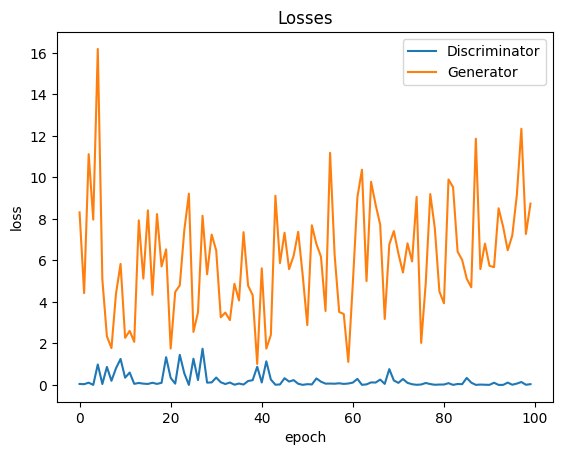

In [98]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

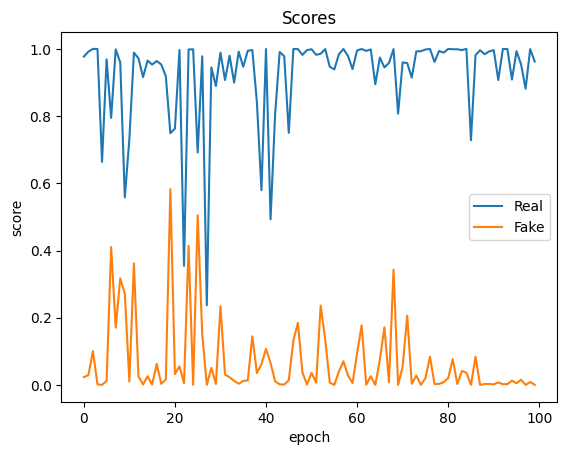

In [99]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');